# Analogical Transfer Learning Experiments

All server files are accessible from this Google Drive folder location: https://drive.google.com/drive/folders/1owPLCv5ZA3XVXnWPx3zjK6_ZKQ9fqt5l?usp=sharing

Every 2-hourly sync was created with ISI Google Drive location: https://drive.google.com/drive/folders/1T-dE2tzF6iZDcDnaAmJeWERV-d3QwAk8?usp=sharing

Command used for creating GDrive sync client from `../data/` location: 

`screen -dm watch -n 7200 rclone sync --verbose . kshenoy-gdrive:/ALL_FILES`

Overall, the notebook is organized into 4 parts:
* Utility functions and basic analysis
* Ontologies
* Manual analogical dataset analysis
* SemEval 2012 dataseet and the experiments

In [1]:
import json
from datetime import date
from collections import defaultdict
import gzip
import pandas as pd
import scipy.stats as stats
from tqdm.notebook import tqdm
from itertools import combinations, product
from string import ascii_lowercase
import os
import matplotlib.pyplot as plt

In [2]:
LABELS_FILE = "../source_dataset_files/wikidata-20210215-dwd-v2/labels.en.tsv.gz"
DESCRIPTIONS_FILE = "../source_dataset_files/wikidata-20210215-dwd-v2/descriptions.en.tsv.gz"
P279_EDGES_FILE = "../source_dataset_files/wikidata-20210215-dwd-v2/derived.P279.tsv.gz"
P279STAR_EDGES_FILE = "../source_dataset_files/wikidata-20210215-dwd-v2/derived.P279star.tsv.gz"
P31P279STAR_EDGES_FILE = "../source_dataset_files/wikidata-20210215-dwd-v2/derived.P31P279star.tsv.gz"
P31_EDGES_FILE = "../source_dataset_files/wikidata-20210215-dwd-v2/derived.P31.tsv.gz"

In [3]:
COMPOSITIONAL_FILE = "../data/analogical_proj/compositional.tsv"
ANALOGICAL_TEST_FILE = "../data/analogical_proj/Analogical_Test_File.csv"
P31P279STAR_NODE2_COUNTS_FILE = "../data/analogical_proj/P31279star.node2.counts.json"
P31_PARENT_CHILD_DICT_FILE = "../data/analogical_proj/P31_parent_child_dict.json"

In [4]:
GOOGLE_PROJ_FILEPATH = "../data/analogical_proj/emb_files_for_google_projections/"

In [145]:
SEM_EVAL_FILEPATH = "../data/analogical_proj/SemEval-2012-Complete"
SEM_EVAL_GENERATED_TRAINING_FILE = '../data/analogical_proj/SemEval2012_training.csv'
SEM_EVAL_GENERATED_TESTING_FILE = '../data/analogical_proj/SemEval2012_testing.csv'
SEM_EVAL_GENERATED_FINAL_FILE = '../data/analogical_proj/SemEval2012_final.csv'

# Ph1-Tr, Ph1-Te
SEM_EVAL_GENERATED_FINAL_TRAINING_COMPLEX_FILE = '../data/analogical_proj/SemEval2012_final_training_complex.csv'
SEM_EVAL_GENERATED_FINAL_TESTING_COMPLEX_FILE = '../data/analogical_proj/SemEval2012_final_testing_complex.csv'

# SEM_EVAL_GENERATED_TURKER_TRAINING_COMBINED_FILE = '../data/analogical_proj/SemEval2012_turker.csv'

# Ph2-Tr, Ph2-Te
SEM_EVAL_GENERATED_TURKER_TRAINING_DATA_FILE = '../data/analogical_proj/SemEval2012_turker_training_samples.csv'
SEM_EVAL_GENERATED_TURKER_TESTING_DATA_FILE = '../data/analogical_proj/SemEval2012_turker_testing_samples.csv'

# scores
SEM_EVAL_GENERATED_TURKER_SCORES_TRAINING_DATA_FILE = '../data/analogical_proj/SemEval2012_turker_training_samples.scores.csv'
SEM_EVAL_GENERATED_TURKER_SCORES_TESTING_DATA_FILE = '../data/analogical_proj/SemEval2012_turker_testing_samples.scores.csv'

# MCQ
SEM_EVAL_GENERATED_MCQ_FILE = '../data/analogical_proj/SemEval2012_MCQ.jsonl'

In [6]:
COMPLEX_EMB_SOURCE_FILE = "../source_dataset_files/wikidata-20210215-dwd-v2/wikidatadwd.complEx.graph-embeddings.txt"

# Utility Functions

In [7]:
# Fetches latest label for qnode
import requests
def fetch_label(qnode):
    try:
        return requests.get('http://ckg07:9200/wikidatadwd-augmented/_doc/'+qnode).json()['_source']['labels']['en'][0]
    except:
        return str(False)

In [8]:
# Fetches latest description for qnode
import requests
def fetch_desc(qnode):
    try:
        return requests.get('http://ckg07:9200/wikidatadwd-augmented/_doc/'+qnode).json()['_source']['descriptions']['en'][0]
    except:
        return str(False)

In [9]:
# Fetches text matches from ringgaard
import requests
def fetch_matches(qnode_label):
    try:
        return requests.get('https://ringgaard.com/kb/query?fmt=cjson&q='+qnode_label).json()['matches']
    except:
        return str(False)

# Initial Analysis

Initial queries to fetch pairs where node and its ancestor have a common substring which we store in `compositional.tsv`. We then sort the list according to the length of the Qnode ID and then pick few of those. Smaller ID lengths mean more commonly used words. We generate this final sheet [here](https://docs.google.com/spreadsheets/d/1Z6XQJWTsX87ZrCEJMvpYXCwgCb622unyAFLW1rl2xV4/edit#gid=1004447672) in "Common words set 2" sheet. We perform additional analysis as the headers describe. Accordingly, later we find analogies manually by searching for more P279 relations either using same node2 or same parent of node2 or same ancestor of node2 and compile this list in "Analogical Dataset" sheet.

In [10]:
# !isa_file=../data/P279_dataset/wikidata-P279.tsv
# !labels_file=../data/labels.en.tsv
!kgtk query -i ../source_dataset_files/wikidata-20210215-dwd-v2/derived.P279.tsv.gz -i ../source_dataset_files/wikidata-20210215-dwd-v2/labels.en.tsv.gz \
--match 'i: (x)-[:P279]->(y), l: (x)-[:label]->(lbl), (y)-[:label]->(lbl2)' \
--where 'lbl =~ ".* .*" AND instr(kgtk_unstringify(kgtk_lqstring_text(lbl)), kgtk_unstringify(kgtk_lqstring_text(lbl2))) AND lbl!=lbl2' \
--return 'distinct x as node1, y as node2, kgtk_lqstring_text_string(lbl), kgtk_lqstring_text_string(lbl2)' \
-o ../data/analogical_proj/compositional.tsv


In [11]:
!head ../data/analogical_proj/compositional.tsv

node1	node2	kgtk_lqstring_text_string(graph_2_c2."node2")	kgtk_lqstring_text_string(graph_2_c3."node2")
Q1000064	Q11016	"nuclear reactor technology"	"technology"
Q1000120	Q12510	"maximal torus"	"torus"
Q100061973	Q1799072	"presentation method"	"method"
Q1000828	Q918385	"team training"	"training"
Q1000850	Q748	"Buddhism in Germany"	"Buddhism"
Q1000859	Q748	"Buddhism in Iceland"	"Buddhism"
Q1000861	Q748	"Buddhism in Ireland"	"Buddhism"
Q1000863	Q376	"master clock"	"clock"
Q1000869	Q748	"Buddhism in Bangladesh"	"Buddhism"


In [12]:
import pandas as pd

comp = pd.read_csv(COMPOSITIONAL_FILE, sep='\t')

In [13]:
comp['node1_len'] = comp.node1.apply(lambda p: len(p))
comp['node2_len'] = comp.node2.apply(lambda p: len(p))
comp = comp.sort_values(by=['node1_len', 'node2_len'])

In [14]:
comp.head()

node1    node2 kgtk_lqstring_text_string(graph_2_c2."node2")  \
233844  Q561     Q553                                   human tooth   
454979  Q825     Q190                           God in Christianity   
219269  Q416   Q41298                                 disk magazine   
460735  Q944   Q41217                             quantum mechanics   
206360  Q305  Q186361                           corporal punishment   

       kgtk_lqstring_text_string(graph_2_c3."node2")  node1_len  node2_len  
233844                                         tooth          4          4  
454979                                           God          4          4  
219269                                      magazine          4          6  
460735                                     mechanics          4          6  
206360                                    punishment          4          7

In [15]:
from tabulate import tabulate

In [16]:
comp[:50].sample(n=25, random_state=13)

node1      node2 kgtk_lqstring_text_string(graph_2_c2."node2")  \
427360  Q6745      Q6718                                    down quark   
206360   Q305    Q186361                           corporal punishment   
250186  Q5886       Q523                                       OB star   
427575  Q6778      Q6718                                     top quark   
233844   Q561       Q553                                   human tooth   
223319  Q4812       Q527                                       day sky   
219582  Q4188      Q3937                       superluminous supernova   
455613  Q8465       Q198                                     civil war   
448203  Q7141       Q420                                  cell biology   
220067   Q426   Q2386606                                 animal rights   
453953  Q7991       Q336                               natural science   
381607  Q6251       Q523                               Wolf–Rayet star   
411414  Q6311      Q8104                            stellar atmosphere   
250025  Q5860       Q161                                 carbon fibers   
228461  Q5275       Q376                            astronomical clock   
461043  Q9585       Q432                                    Shia Islam   
427506  Q6763      Q6718                                 strange quark   
182733   Q250   Q1921606                             computer keyboard   
460735   Q944     Q41217                             quantum mechanics   
442460   Q699  Q17991521                                    fairy tale   
427450  Q6754      Q6718                                   charm quark   
219336  Q4169       Q107                                   outer space   
454508  Q8124        Q58                                   human penis   
415742  Q6635      Q6592               resonant trans-Neptunian object   
447753  Q7076      Q6199                       individualist anarchism   

       kgtk_lqstring_text_string(graph_2_c3."node2")  node1_len  node2_len  
427360                                         quark          5          5  
206360                                    punishment          4          7  
250186                                          star          5          4  
427575                                         quark          5          5  
233844                                         tooth          4          4  
223319                                           sky          5          4  
219582                                     supernova          5          5  
455613                                           war          5          4  
448203                                       biology          5          4  
220067                                         right          4          8  
453953                                       science          5          4  
381607                                          star          5          4  
411414                                    atmosphere          5          5  
250025                                         fiber          5          4  
228461                                         clock          5          4  
461043                                         Islam          5          4  
427506                                         quark          5          5  
182733                                      keyboard          4          8  
460735                                     mechanics          4          6  
442460                                          tale          4          9  
427450                                         quark          5          5  
219336                                         space          5          4  
454508                                         penis          5          3  
415742                        trans-Neptunian object          5          5  
447753                                     anarchism          5          5

In [17]:
print(tabulate(comp[:50].sample(n=25, random_state=13), headers = 'keys', tablefmt = 'simple'))

        node1    node2      kgtk_lqstring_text_string(graph_2_c2."node2")    kgtk_lqstring_text_string(graph_2_c3."node2")      node1_len    node2_len
------  -------  ---------  -----------------------------------------------  -----------------------------------------------  -----------  -----------
427360  Q6745    Q6718      down quark                                       quark                                                      5            5
206360  Q305     Q186361    corporal punishment                              punishment                                                 4            7
250186  Q5886    Q523       OB star                                          star                                                       5            4
427575  Q6778    Q6718      top quark                                        quark                                                      5            5
233844  Q561     Q553       human tooth                                      tooth            

In [18]:
comp.sample(n=20, random_state=13)

node1      node2  \
349093   Q62247423      Q8054   
227648    Q5165876    Q567696   
418482   Q66514842  Q66514840   
344574   Q62234654      Q8054   
59297    Q22336657      Q8054   
202225   Q28561607      Q8054   
286645   Q60016122      Q8054   
226797   Q51156346  Q55550972   
171334   Q24223110      Q8054   
41967    Q22233113      Q8054   
214765     Q363988    Q167844   
431202   Q68310966      Q8054   
3362    Q105102267   Q3249551   
213484   Q34313519  Q34313517   
153708   Q24107918      Q8054   
79553    Q23455032      Q8054   
299733   Q61549022      Q8054   
366794   Q62422639      Q8054   
417873   Q66511406  Q66511401   
270879   Q59964671      Q8054   

            kgtk_lqstring_text_string(graph_2_c2."node2")  \
349093                    hypothetical protein, conserved   
227648                                      Control order   
418482                  medial lumbar intertransversarius   
344574     Soluble NSF attachment protein, SNAP, putative   
59297         Rhodanese domain-containing protein lpg1850   
202225                             Centrosomal protein 70   
286645                             protein UIS3, putative   
226797                          first Sunday in September   
171334  GTP-binding tyrosin phosphorylated protein blr...   
41967                        Hypothetical protein Rv2024c   
214765                            neonatal conjunctivitis   
431202  Trypanosomal VSG domain containing protein, pu...   
3362                              problem-solving process   
213484  negative regulation of adenylate cyclase-activ...   
153708       1,4-alpha-glucan-branching protein SM_b21447   
79553                          Regulatory protein BT_0110   
299733             hypothetical protein, unknown function   
366794  serine/threonine-protein phosphatase PP1, puta...   
417873  anterior radicular branch of spinal branch of ...   
270879     conserved Plasmodium protein, unknown function   

            kgtk_lqstring_text_string(graph_2_c3."node2")  node1_len  \
349093                                            protein          9   
227648                                              order          8   
418482                         lumbar intertransversarius          9   
344574                                            protein          9   
59297                                             protein          9   
202225                                            protein          9   
286645                                            protein          9   
226797                                Sunday in September          9   
171334                                            protein          9   
41967                                             protein          9   
214765                                     conjunctivitis          7   
431202                                            protein          9   
3362                                              process         10   
213484  regulation of adenylate cyclase-activating glu...          9   
153708                                            protein          9   
79553                                             protein          9   
299733                                            protein          9   
366794                                            protein          9   
417873  radicular branch of spinal branch of lumbar ar...          9   
270879                                            protein          9   

        node2_len  
349093          5  
227648          7  
418482          9  
344574          5  
59297           5  
202225          5  
286645          5  
226797          9  
171334          5  
41967           5  
214765          7  
431202          5  
3362            8  
213484          9  
153708          5  
79553           5  
299733          5  
366794          5  
417873          9  
270879          5

In [19]:
print(tabulate(comp.sample(n=20, random_state=13), headers = 'keys', tablefmt = 'simple'))

        node1       node2      kgtk_lqstring_text_string(graph_2_c2."node2")                                                                       kgtk_lqstring_text_string(graph_2_c3."node2")                                                                node1_len    node2_len
------  ----------  ---------  ------------------------------------------------------------------------------------------------------------------  ---------------------------------------------------------------------------------------------------------  -----------  -----------
349093  Q62247423   Q8054      hypothetical protein, conserved                                                                                     protein                                                                                                              9            5
227648  Q5165876    Q567696    Control order                                                                                                       order           

# Determine Top Parents based on transitive child count

In this section, we use P279* file and count the transitive counts of all node2's. We then sort this list in descending order of these counts. We then peruse this list to determine which top parents can we consider as primary high level categories. This list is compiled in this [spreadsheet](https://docs.google.com/spreadsheets/d/1Z6XQJWTsX87ZrCEJMvpYXCwgCb622unyAFLW1rl2xV4/edit) in "Top Parents" sheet.

In [21]:
import pandas as pd
import gzip

p279StarDF = pd.read_csv(P279STAR_EDGES_FILE, sep='\t', compression='gzip')

In [22]:
p279StarDF_node2_counts = p279StarDF.node2.value_counts()

In [23]:
p279StarDF_node2_counts = p279StarDF_node2_counts.sort_values(ascending=False)

In [24]:
p279StarDF_node2_counts[:20]

Q35120       2461205
Q99527517    2254395
Q28813620    1362928
Q16887380    1362453
Q488383      1286224
Q20937557    1267086
Q58415929    1201237
Q4406616     1175201
Q223557      1164914
Q6671777     1122327
Q337060      1079444
Q7184903     1072353
Q219858      1057006
Q50365914    1056956
Q23958946    1038338
Q97669203    1007383
Q15712714    1007381
Q3511065     1007335
Q3771876     1004686
Q37500013    1004683
Name: node2, dtype: int64

In [25]:
import requests

for qnode,qnode_count in zip(p279StarDF_node2_counts[:100].index, p279StarDF_node2_counts[:100]):
    print(qnode+','+requests.get('http://ckg07:9200/wikidatadwd-augmented/_doc/'+qnode).json()['_source']['labels']['en'][0] + "," + str(qnode_count))

Q35120,entity,2461205
Q99527517,collection entity,2254395
Q28813620,set,1362928
Q16887380,group,1362453
Q488383,object,1286224
Q20937557,series,1267086
Q58415929,spatio-temporal entity,1201237
Q4406616,concrete object,1175201
Q223557,physical object,1164914
Q6671777,structure,1122327
Q337060,perceptible object,1079444
Q7184903,abstract object,1072353
Q219858,zone,1057006
Q50365914,biological region,1056956
Q23958946,individual entity,1038338
Q97669203,molecular conformation,1007383
Q15712714,biomolecular structure,1007381
Q3511065,biological sequence,1007335
Q3771876,nucleic acid structure,1004686
Q37500013,primary structure,1004683
Q863908,nucleic acid sequence,1004680
Q7187,gene,1004634
Q103940464,continuant,1003327
Q53617489,independent continuant,1003326
Q27043950,anatomical entity,1003324
Q28732711,physical substance,977520
Q4503801,part and whole,969424
Q1310239,component,960112
Q20747295,protein-coding gene,942018
Q58416391,spatial entity,927235
Q43460564,chemical entity,894601


# Analyze Parents


In [4]:
import pandas as pd
import gzip
from collections import defaultdict
from tqdm.notebook import tqdm

# p31p279StarDF_node2_counts_dict = defaultdict(int)
# p31p279StarDF_parent_child_dict = defaultdict(list)
# with gzip.open(P31P279STAR_EDGES_FILE) as fIN:
#     first_line = True
#     for line in tqdm(fIN, total=1779066990):
#         if first_line:
#             first_line = False
#             continue
#         line_s = line.decode("utf-8").strip().split('\t')
#         p31p279StarDF_node2_counts_dict[line_s[2]] += 1
#         p31p279StarDF_parent_child_dict[line_s[2]].append(line_s[0])
# json.dump(p31p279StarDF_node2_counts_dict, open(P31P279STAR_NODE2_COUNTS_FILE, 'w'))

p31p279StarDF_node2_counts_dict = json.load(open(P31P279STAR_NODE2_COUNTS_FILE))

In [5]:
# P31_parent_child_dict = defaultdict(set)
# with gzip.open(P31_EDGES_FILE) as fIN:
#     first_line = True
#     for line in tqdm(fIN):
#         if first_line:
#             first_line = False
#             continue
#         line_s = line.decode("utf-8").strip().split('\t')
#         P31_parent_child_dict[line_s[3]].add(line_s[1])
# for parent in P31_parent_child_dict:
#     P31_parent_child_dict[parent] = list(P31_parent_child_dict[parent])
# json.dump(P31_parent_child_dict, open(P31_PARENT_CHILD_DICT_FILE, 'w'))
P31_parent_child_dict = json.load(open(P31_PARENT_CHILD_DICT_FILE))
for parent in P31_parent_child_dict:
    P31_parent_child_dict[parent] = set(P31_parent_child_dict[parent])

In [6]:
from collections import defaultdict
from tqdm.notebook import tqdm

child_parent_dict = defaultdict(set)
parent_child_dict = defaultdict(set)
with gzip.open(P279_EDGES_FILE) as fIN:
    first_line = True
    for line in tqdm(fIN):
        if first_line:
            first_line = False
            continue
        line_s = line.decode("utf-8").strip().split('\t')
        child_parent_dict[line_s[1]].add(line_s[3])
        parent_child_dict[line_s[3]].add(line_s[1])

0it [00:00, ?it/s]

In [7]:
max_depths = {}
min_depths = {}

def find_max_depth(qnode, depth=0, visited=set()):
    global parent_child_dict
#     print(qnode, depth, visited)
    if qnode not in parent_child_dict:
        return depth
    max_val = depth
    for child in parent_child_dict[qnode]:
        if child not in visited:
            if child not in max_depths:
                max_depths[child] = find_max_depth(child, depth+1, visited | {child})
            max_val = max(max_val, max_depths[child])
    return max_val

def find_min_depth(qnode, depth=0, visited=set()):
    global parent_child_dict
#     print(qnode, depth, visited)
    if qnode not in parent_child_dict:
        return depth
    min_val = float('inf')
    for child in parent_child_dict[qnode]:
        if child not in visited:
            if child not in min_depths:
                min_depths[child] = find_min_depth(child, depth+1, visited | {child})
            min_val = min(min_val, min_depths[child])
    if min_val == float('inf'):
        return depth
    else:
        return min_val

In [8]:
import numpy as np
def entropy_of_children(qnode):
    entropy_sum = 0
    for child in parent_child_dict[qnode]:
        if child in p279StarDF_node2_counts_dict:
            assert p279StarDF_node2_counts_dict[child] <= p279StarDF_node2_counts_dict[qnode], (child, qnode)
            entropy_sum -= p279StarDF_node2_counts_dict[child] / p279StarDF_node2_counts_dict[qnode] * np.log2(p279StarDF_node2_counts_dict[child] / p279StarDF_node2_counts_dict[qnode])
    return float(entropy_sum)

In [9]:
import scipy.stats as st
import numpy as np
def entropy_of_children_v_inst(qnode, debug=False):
    entropy_sum = 0
    if p31p279StarDF_node2_counts_dict[qnode] == 0:
        return "N/A"
    for child in parent_child_dict[qnode]:
        if child in p31p279StarDF_node2_counts_dict:
            assert p31p279StarDF_node2_counts_dict[child] <= p31p279StarDF_node2_counts_dict[qnode], (child, qnode)
            if p31p279StarDF_node2_counts_dict[child] == 0:
                continue
            entropy_sum -= p31p279StarDF_node2_counts_dict[child] / p31p279StarDF_node2_counts_dict[qnode] * np.log2(p31p279StarDF_node2_counts_dict[child] / p31p279StarDF_node2_counts_dict[qnode])
    return float(entropy_sum)
#     if debug:
#         print([(child,p31p279StarDF_node2_counts_dict[child]) for child in parent_child_dict[qnode]])
# #     arr = np.array([p31p279StarDF_node2_counts_dict[child] for child in parent_child_dict[qnode] if p31p279StarDF_node2_counts_dict[child] != 0])
# #     return -np.sum(arr / np.sum(arr) * np.log(arr / np.sum(arr)))
# #     print(sum([p31p279StarDF_node2_counts_dict[child] for child in parent_child_dict[qnode]]))
#     return st.entropy([p31p279StarDF_node2_counts_dict[child] for child in parent_child_dict[qnode]])

In [10]:
def get_reduction_ratio(qnode, parent=None):
    if parent is None:
        return [round(p31p279StarDF_node2_counts_dict[qnode] / p31p279StarDF_node2_counts_dict[parent],2) for parent in child_parent_dict[qnode] if p31p279StarDF_node2_counts_dict[parent] != 0]
    else:
        return round(p31p279StarDF_node2_counts_dict[qnode] / p31p279StarDF_node2_counts_dict[parent],2) if p31p279StarDF_node2_counts_dict[parent] != 0 else None

In [11]:
def find_leaves(qnode, visited=set()):
    if qnode in visited:
        return set()
    if qnode not in parent_child_dict:
        if qnode in P31_parent_child_dict:
            return P31_parent_child_dict[qnode]
        else:
            return set()
    children = set()
    for child in parent_child_dict[qnode]:
        children |= find_leaves(child, visited | {qnode})
    return children

In [12]:
def compute_overlap_ratio(node1, node2):
    if node1 == node2:
        return 0
    if node1 not in parent_child_dict:
        return 0        
    if node2 not in parent_child_dict:
        return 0
    node1_set = (find_leaves(node1))
    node2_set = (find_leaves(node2))
    if len(node1_set | node2_set) == 0:
        return 0
    return len(node1_set & node2_set) / len(node1_set | node2_set)

In [ ]:
# newRows = []
# for _, row in tqdm(top_parents.iterrows()):
#     row['child_count'] = len(parent_child_dict[row['qnode']])
#     row['max_no_of_siblings'] = max([len(parent_child_dict[parent]) - 1 for parent in child_parent_dict[row['qnode']]]) if child_parent_dict[row['qnode']] else 0
#     row['min_no_of_siblings'] = min([len(parent_child_dict[parent]) - 1 for parent in child_parent_dict[row['qnode']]]) if child_parent_dict[row['qnode']] else 0
#     row['max_depth'] = find_max_depth(row['qnode'])
#     row['min_depth'] = find_min_depth(row['qnode'])
#     row['entropy'] = entropy_of_children(row['qnode'])
#     row['red_ratios'] = get_reduction_ratio(row['qnode'])
#     newRows.append(row)

In [ ]:
# parent_child_dict['Q2424752']

In [ ]:
# pd.DataFrame(newRows)

In [ ]:
# pd.DataFrame(newRows).to_csv('../data/Analogical_Dataset/top_parents_analysis.csv',index=None)

## Ontology Generator

Analyze Product (Q15401930) Ontology

Here, using different types of constraints, we try to construct multiple ontology trees. The aim of this experiment was to check the candidate top categories that we could consider. We broaden this search by considering nodes from this ontology tree.

In [13]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    GRAY = '\033[37m'

In [40]:
def print_ontology_subtree(ont_obj, first_sibling, max_children, compute_overlap=False, superparent=None):
    
#     print(ont_obj)
    _, qnode, parent, levels, start_level, tree_prefix, children = ont_obj
    
    if superparent is None:
        superparent = qnode
    
    overlap_thresh = 0.5
    
    ent = entropy_of_children_v_inst(qnode)
    ent = round(ent, 2) if ent != 'N/A' else ent
    child_count = len(parent_child_dict[qnode])
    inst_count = p31p279StarDF_node2_counts_dict[qnode]
    max_siblings = max([len(parent_child_dict[parent]) - 1 for parent in child_parent_dict[qnode]]) if child_parent_dict[qnode] else 0
    min_siblings = min([len(parent_child_dict[parent]) - 1 for parent in child_parent_dict[qnode]]) if child_parent_dict[qnode] else 0
    red_ratio = get_reduction_ratio(qnode, parent) if parent is not None else '-'
    superP_red_ratio = get_reduction_ratio(qnode, superparent) if superparent is not None else '-'
    overlap_ratio = round(compute_overlap_ratio(first_sibling, qnode),2) if compute_overlap else 0
    node_color = bcolors.GRAY if overlap_ratio >= overlap_thresh else ''
    
    if levels >= start_level - 7:
        ret_str = f"{node_color}{tree_prefix}── {fetch_label(qnode)}: {qnode}{bcolors.ENDC}\
= {bcolors.OKBLUE}ch:{child_count}{bcolors.ENDC}, \
{bcolors.FAIL}ins:{inst_count}{bcolors.ENDC},\
{bcolors.OKGREEN}maxs:{max_siblings}{bcolors.ENDC},\
{bcolors.OKCYAN}mins:{min_siblings}{bcolors.ENDC},\
{bcolors.BOLD}e:{ent}{bcolors.ENDC},\
{bcolors.UNDERLINE}RR:{red_ratio}{bcolors.ENDC},SPRR:{superP_red_ratio}{',OR:'+str(overlap_ratio) if overlap_ratio != 0 else ''}"
    else:
        ret_str = f"{node_color}{tree_prefix}── {fetch_label(qnode)}: {qnode}{bcolors.ENDC}\
= {bcolors.OKBLUE}ch:{child_count}{bcolors.ENDC},\
{bcolors.FAIL}ins:{inst_count}{bcolors.ENDC},\
{bcolors.BOLD}e:{ent}{bcolors.ENDC},\
{bcolors.UNDERLINE}RR:{red_ratio}{bcolors.ENDC},SPRR:{superP_red_ratio}{',OR:'+str(overlap_ratio) if overlap_ratio != 0 else ''}"
            
    print(ret_str)
    if overlap_ratio < overlap_thresh:
        for child in children[:max_children]:
            print_ontology_subtree(child, children[0][1], max_children, compute_overlap, superparent)

In [52]:
def generate_ontology_tree(qnode, tree_prefix, levels, start_level, parent=None, superparent=None):
    
    if prune_here(qnode, parent, levels, start_level, superparent):
        return None
    
    if superparent is None:
        superparent = qnode
    
#     print(ret_str)
    if levels == 1:
        return (p31p279StarDF_node2_counts_dict[qnode], qnode, parent, levels, start_level, tree_prefix, [])
    
    children = []
    
    for child in parent_child_dict[qnode]:
        temp = generate_ontology_tree(child, tree_prefix + '   ├', levels - 1, start_level, qnode, superparent)
        if temp is not None:
#             print(temp)
            children += [temp]
    if len(children) > 0:
#         print((children))
        children.sort(key=lambda p: -p[0])
    return (p31p279StarDF_node2_counts_dict[qnode], qnode, parent, levels, start_level, tree_prefix, children)

def prune_here(qnode, parent, levels, start_level, superparent):
    ent = entropy_of_children_v_inst(qnode)
    inst_count = p31p279StarDF_node2_counts_dict[qnode]
    red_ratio = get_reduction_ratio(qnode, parent) if parent is not None else None
    superP_red_ratio = get_reduction_ratio(qnode, superparent) if superparent is not None else None
    
#     if fetch_label(qnode) == fetch_label(parent):
#         return True
#     if start_level - levels <= 1:
#         return False
    if inst_count < 1000:
        return True
    if red_ratio is not None and not(0.15 <= red_ratio):
        return True
    if start_level - levels <= 3 and ent >= 1:
        return False
    if superP_red_ratio is not None and not(0.05 <= superP_red_ratio):
        return True
#     if ent < 1:
#         return True
    
    return False

### Candidate 1

Allowed children rules (excluding top 2 levels):

inst count >= 1000

red_ratio >= 0.15

overlap ratio with top non-pruned sibling < 0.5

In [46]:
print_ontology_subtree(generate_ontology_tree('Q15401930', " ├", levels=20, start_level=20, parent=None), first_sibling=None, max_children=100, compute_overlap=True)

 ├── product: Q15401930= ch:17, ins:17979820,maxs:55,mins:55,e:0.3,RR:-,SPRR:1.0
 ├   ├── work: Q386724= ch:117, ins:17735874,maxs:42,mins:16,e:3.07,RR:0.99,SPRR:0.99
 ├   ├   ├── intellectual work: Q15621286= ch:33, ins:12661271,maxs:116,mins:116,e:0.64,RR:0.71,SPRR:0.7
 ├   ├   ├   ├── creative work: Q17537576= ch:105, ins:12405623,maxs:32,mins:32,e:2.16,RR:0.98,SPRR:0.69
 ├   ├   ├   ├   ├── written work: Q47461344= ch:42, ins:10219113,maxs:104,mins:104,e:1.09,RR:0.82,SPRR:0.57
 ├   ├   ├   ├   ├   ├── text: Q234460= ch:108, ins:9993905,maxs:85,mins:25,e:1.23,RR:0.98,SPRR:0.56
 ├   ├   ├   ├   ├   ├   ├── document: Q49848= ch:288, ins:8541423,maxs:107,mins:5,e:1.02,RR:0.85,SPRR:0.48
 ├   ├   ├   ├   ├   ├   ├   ├── web page: Q36774= ch:10, ins:7848214,maxs:287,mins:0,e:0.0,RR:0.92,SPRR:0.44
 ├   ├   ├   ├   ├   ├   ├   ├   ├── MediaWiki page: Q15474042= ch:10,ins:7847545,e:0.56,RR:1.0,SPRR:0.44
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── Wikimedia page outside the main knowledge tree: 

 ├   ├   ├   ├   ├   ├   ├   ├── Wikimedia list article: Q13406463= ch:42, ins:421604,maxs:77,mins:3,e:0.87,RR:0.31,SPRR:0.02
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Wikimedia set index article: Q15623926= ch:3,ins:71959,e:0.11,RR:0.17,SPRR:0.0
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── Wikimedia human name disambiguation page: Q22808320= ch:0,ins:69656,e:0.0,RR:0.97,SPRR:0.0
 ├   ├   ├   ├   ├   ├── MediaWiki main-namespace page: Q15633587= ch:4, ins:2024595,maxs:9,mins:9,e:1.22,RR:0.26,SPRR:0.11,OR:0.29
 ├   ├   ├   ├   ├   ├   ├── Wikimedia disambiguation page: Q4167410= ch:5, ins:1409031,maxs:77,mins:3,e:0.22,RR:0.7,SPRR:0.08
 ├   ├   ├   ├   ├   ├   ├── Wikimedia list article: Q13406463= ch:42, ins:421604,maxs:77,mins:3,e:0.87,RR:0.21,SPRR:0.02
 ├   ├   ├   ├   ├   ├   ├   ├── Wikimedia set index article: Q15623926= ch:3, ins:71959,maxs:41,mins:41,e:0.11,RR:0.17,SPRR:0.0
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Wikimedia human name disambiguation page: Q22808320= ch:0,ins:69656,e:0.0,RR:0.

 ├   ├── product: Q2424752= ch:152, ins:757932,maxs:135,mins:16,e:4.78,RR:0.04,SPRR:0.04,OR:0.04
 ├   ├   ├── equipment: Q16798631= ch:93, ins:395939,maxs:151,mins:135,e:1.19,RR:0.52,SPRR:0.02
 ├   ├   ├   ├── tool: Q39546= ch:548, ins:390735,maxs:151,mins:10,e:1.77,RR:0.99,SPRR:0.02
 ├   ├   ├   ├   ├── device: Q1183543= ch:517, ins:323475,maxs:547,mins:42,e:2.38,RR:0.83,SPRR:0.02
 ├   ├   ├   ├   ├   ├── machine: Q11019= ch:209, ins:280478,maxs:547,mins:516,e:1.77,RR:0.87,SPRR:0.02
 ├   ├   ├   ├   ├   ├   ├── vehicle: Q42889= ch:72, ins:140666,maxs:286,mins:2,e:2.09,RR:0.5,SPRR:0.01
 ├   ├   ├   ├   ├   ├   ├   ├── watercraft: Q1229765= ch:48, ins:115521,maxs:71,mins:7,e:0.8,RR:0.82,SPRR:0.01
 ├   ├   ├   ├   ├   ├   ├   ├   ├── ship: Q11446= ch:479,ins:107262,e:1.72,RR:0.93,SPRR:0.01
 ├   ├   ├   ├   ├   ├   ├   ├── vessel: Q16391167= ch:7, ins:110250,maxs:71,mins:71,e:0.55,RR:0.78,SPRR:0.01,OR:0.94
 ├   ├   ├   ├   ├   ├   ├── electronic machine: Q2858615= ch:72, ins:121322,maxs:2

 ├   ├   ├── tool: Q39546= ch:548, ins:390735,maxs:151,mins:10,e:1.77,RR:0.52,SPRR:0.02,OR:0.92
 ├   ├   ├── finished good: Q3245975= ch:3, ins:140671,maxs:151,mins:151,e:0.0,RR:0.19,SPRR:0.01,OR:0.34
 ├   ├   ├   ├── vehicle: Q42889= ch:72, ins:140666,maxs:286,mins:2,e:2.09,RR:1.0,SPRR:0.01
 ├   ├   ├   ├   ├── watercraft: Q1229765= ch:48, ins:115521,maxs:71,mins:7,e:0.8,RR:0.82,SPRR:0.01
 ├   ├   ├   ├   ├   ├── ship: Q11446= ch:479, ins:107262,maxs:47,mins:6,e:1.72,RR:0.93,SPRR:0.01
 ├   ├   ├   ├   ├── vessel: Q16391167= ch:7, ins:110250,maxs:71,mins:71,e:0.55,RR:0.78,SPRR:0.01,OR:0.94
 ├   ├   ├── electrical element: Q210729= ch:24, ins:123089,maxs:151,mins:13,e:0.07,RR:0.16,SPRR:0.01,OR:0.12
 ├   ├   ├   ├── electrical load: Q931447= ch:6, ins:122411,maxs:23,mins:23,e:0.0,RR:0.99,SPRR:0.01
 ├   ├   ├   ├   ├── electrical apparatus: Q2425052= ch:28, ins:122408,maxs:516,mins:5,e:0.21,RR:1.0,SPRR:0.01
 ├   ├   ├   ├   ├   ├── electronic machine: Q2858615= ch:72, ins:121322,maxs:208,

 ├   ├── recombinant protein: Q50209538= ch:29, ins:40,maxs:764037,mins:16,e:0.0,RR:0.0,SPRR:0.0
 ├   ├── deliverable: Q2297847= ch:1, ins:33,maxs:151,mins:16,e:0.0,RR:0.0,SPRR:0.0
 ├   ├── LR parser: Q1756442= ch:4, ins:2,maxs:16,mins:6,e:1.0,RR:0.0,SPRR:0.0
 ├   ├── masonry: Q18087969= ch:2, ins:2,maxs:16,mins:16,e:0.0,RR:0.0,SPRR:0.0
 ├   ├── combustion product: Q10861378= ch:2, ins:2,maxs:16,mins:16,e:0.0,RR:0.0,SPRR:0.0
 ├   ├── hologram: Q3139490= ch:1, ins:1,maxs:46,mins:16,e:0.0,RR:0.0,SPRR:0.0
 ├   ├── counterfeit money: Q854851= ch:3, ins:0,maxs:34,mins:16,e:N/A,RR:0.0,SPRR:0.0
 ├   ├── test result: Q91615379= ch:1, ins:0,maxs:49,mins:16,e:N/A,RR:0.0,SPRR:0.0
 ├   ├── False: Q61864308= ch:1, ins:0,maxs:16,mins:16,e:N/A,RR:0.0,SPRR:0.0
 ├   ├── breath: Q13428325= ch:0, ins:0,maxs:16,mins:16,e:N/A,RR:0.0,SPRR:0.0


### Candidate 2

Allowed children rules (excluding top 2 levels):

inst count >= 1000

0.15 <= red_ratio <= 0.9

overlap ratio with top non-pruned sibling < 0.5

In [29]:
print_ontology_subtree(generate_ontology_tree('Q15401930', " ├", levels=20, start_level=20, parent=None), first_sibling=None, max_children=100, compute_overlap=True)

 ├── product: Q15401930= ch:17, ins:17979820,maxs:55,mins:55,e:0.3,RR:-,
 ├   ├── work: Q386724= ch:117, ins:17735874,maxs:42,mins:16,e:3.07,RR:0.99,
 ├   ├   ├── intellectual work: Q15621286= ch:33, ins:12661271,maxs:116,mins:116,e:0.64,RR:0.71,
 ├   ├   ├── electronic page: Q5358404= ch:1, ins:7848214,maxs:116,mins:6,e:0.0,RR:0.44,OR:0.1
 ├   ├   ├── human-made geographic feature: Q811430= ch:136, ins:4163999,maxs:116,mins:9,e:1.17,RR:0.23,OR:0.02
 ├   ├   ├── architectural structure: Q811979= ch:315, ins:3863811,maxs:135,mins:2,e:3.94,RR:0.22,OR:0.01
 ├   ├   ├   ├── building: Q41176= ch:433, ins:1870447,maxs:330,mins:314,e:3.76,RR:0.48,
 ├   ├   ├   ├   ├── residential building: Q11755880= ch:82, ins:441990,maxs:432,mins:56,e:1.26,RR:0.24,
 ├   ├   ├   ├   ├   ├── house: Q3947= ch:386, ins:364855,maxs:116,mins:81,e:2.17,RR:0.83,
 ├   ├   ├   ├   ├── religious building: Q24398318= ch:53, ins:363055,maxs:432,mins:53,e:1.76,RR:0.19,OR:0.01
 ├   ├   ├   ├   ├   ├── church building: Q16

 ├   ├── False: Q61864308= ch:1, ins:0,maxs:16,mins:16,e:N/A,RR:0.0,
 ├   ├── breath: Q13428325= ch:0, ins:0,maxs:16,mins:16,e:N/A,RR:0.0,


### Candidate 3

Allowed children rules (excluding top 2 levels):

inst count >= 1000

red_ratio >= 0.15

superparent_red_ratio >= 0.15

overlap ratio with top non-pruned sibling < 0.5

child node label different from parent

In [44]:
print_ontology_subtree(generate_ontology_tree('Q15401930', " ├", levels=20, start_level=20, parent=None), first_sibling=None, max_children=100, compute_overlap=True)

 ├── product: Q15401930= ch:17, ins:17979820,maxs:55,mins:55,e:0.3,RR:-,SPRR:1.0
 ├   ├── work: Q386724= ch:117, ins:17735874,maxs:42,mins:16,e:3.07,RR:0.99,SPRR:0.99
 ├   ├   ├── intellectual work: Q15621286= ch:33, ins:12661271,maxs:116,mins:116,e:0.64,RR:0.71,SPRR:0.7
 ├   ├   ├   ├── creative work: Q17537576= ch:105, ins:12405623,maxs:32,mins:32,e:2.16,RR:0.98,SPRR:0.69
 ├   ├   ├   ├   ├── written work: Q47461344= ch:42, ins:10219113,maxs:104,mins:104,e:1.09,RR:0.82,SPRR:0.57
 ├   ├   ├   ├   ├   ├── text: Q234460= ch:108, ins:9993905,maxs:85,mins:25,e:1.23,RR:0.98,SPRR:0.56
 ├   ├   ├   ├   ├   ├   ├── document: Q49848= ch:288, ins:8541423,maxs:107,mins:5,e:1.02,RR:0.85,SPRR:0.48
 ├   ├   ├   ├   ├   ├   ├   ├── web page: Q36774= ch:10, ins:7848214,maxs:287,mins:0,e:0.0,RR:0.92,SPRR:0.44
 ├   ├   ├   ├   ├   ├   ├   ├   ├── MediaWiki page: Q15474042= ch:10,ins:7847545,e:0.56,RR:1.0,SPRR:0.44
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── Wikimedia page outside the main knowledge tree: 

### Candidate 4

Allowed children rules:

inst count >= 1000

red_ratio >= 0.15

superparent_red_ratio >= 0.1

overlap ratio with top non-pruned sibling < 0.5

child node label different from parent

In [49]:
print_ontology_subtree(generate_ontology_tree('Q15401930', " ├", levels=20, start_level=20, parent=None), first_sibling=None, max_children=100, compute_overlap=True)

 ├── product: Q15401930= ch:17, ins:17979820,maxs:55,mins:55,e:0.3,RR:-,SPRR:1.0
 ├   ├── work: Q386724= ch:117, ins:17735874,maxs:42,mins:16,e:3.07,RR:0.99,SPRR:0.99
 ├   ├   ├── intellectual work: Q15621286= ch:33, ins:12661271,maxs:116,mins:116,e:0.64,RR:0.71,SPRR:0.7
 ├   ├   ├   ├── creative work: Q17537576= ch:105, ins:12405623,maxs:32,mins:32,e:2.16,RR:0.98,SPRR:0.69
 ├   ├   ├   ├   ├── written work: Q47461344= ch:42, ins:10219113,maxs:104,mins:104,e:1.09,RR:0.82,SPRR:0.57
 ├   ├   ├   ├   ├   ├── text: Q234460= ch:108, ins:9993905,maxs:85,mins:25,e:1.23,RR:0.98,SPRR:0.56
 ├   ├   ├   ├   ├   ├   ├── document: Q49848= ch:288, ins:8541423,maxs:107,mins:5,e:1.02,RR:0.85,SPRR:0.48
 ├   ├   ├   ├   ├   ├   ├   ├── web page: Q36774= ch:10, ins:7848214,maxs:287,mins:0,e:0.0,RR:0.92,SPRR:0.44
 ├   ├   ├   ├   ├   ├   ├   ├   ├── MediaWiki page: Q15474042= ch:10,ins:7847545,e:0.56,RR:1.0,SPRR:0.44
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── Wikimedia page outside the main knowledge tree: 

### Candidate 5

Allowed children rules:

inst count >= 1000

red_ratio >= 0.15

!important starting from 4th level if entropy >= 1

superparent_red_ratio >= 0.05

overlap ratio with top non-pruned sibling < 0.5

child node label different from parent

In [53]:
print_ontology_subtree(generate_ontology_tree('Q15401930', " ├", levels=20, start_level=20, parent=None), first_sibling=None, max_children=100, compute_overlap=True)

 ├── product: Q15401930= ch:17, ins:17979820,maxs:55,mins:55,e:0.3,RR:-,SPRR:1.0
 ├   ├── work: Q386724= ch:117, ins:17735874,maxs:42,mins:16,e:3.07,RR:0.99,SPRR:0.99
 ├   ├   ├── intellectual work: Q15621286= ch:33, ins:12661271,maxs:116,mins:116,e:0.64,RR:0.71,SPRR:0.7
 ├   ├   ├   ├── creative work: Q17537576= ch:105, ins:12405623,maxs:32,mins:32,e:2.16,RR:0.98,SPRR:0.69
 ├   ├   ├   ├   ├── written work: Q47461344= ch:42, ins:10219113,maxs:104,mins:104,e:1.09,RR:0.82,SPRR:0.57
 ├   ├   ├   ├   ├   ├── text: Q234460= ch:108, ins:9993905,maxs:85,mins:25,e:1.23,RR:0.98,SPRR:0.56
 ├   ├   ├   ├   ├   ├   ├── document: Q49848= ch:288, ins:8541423,maxs:107,mins:5,e:1.02,RR:0.85,SPRR:0.48
 ├   ├   ├   ├   ├   ├   ├   ├── web page: Q36774= ch:10, ins:7848214,maxs:287,mins:0,e:0.0,RR:0.92,SPRR:0.44
 ├   ├   ├   ├   ├   ├   ├   ├   ├── MediaWiki page: Q15474042= ch:10,ins:7847545,e:0.56,RR:1.0,SPRR:0.44
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── Wikimedia page outside the main knowledge tree: 

### Other Attempts

In [150]:
print_ontology_subtree(generate_ontology_tree('Q15401930', " ├", 20, 20, None), 100)

 ├── product : Q15401930 = [ ch:17, ins:55141522, maxs:55, mins:55, e: 0.13, RR: - ]
 ├   ├── work : Q386724 = [ ch:126, ins:54897575, maxs:42, mins:16, e: 1.92, RR: 1.0 ]
 ├   ├── product : Q2424752 = [ ch:152, ins:757975, maxs:135, mins:16, e: 4.78, RR: 0.01 ]
 ├   ├   ├── equipment : Q16798631 = [ ch:93, ins:395968, maxs:151, mins:135, e: 1.19, RR: 0.52 ]
 ├   ├   ├   ├── tool : Q39546 = [ ch:548, ins:390764, maxs:151, mins:10, e: 1.77, RR: 0.99 ]
 ├   ├   ├   ├   ├── device : Q1183543 = [ ch:517, ins:323476, maxs:547, mins:42, e: 2.38, RR: 0.83 ]
 ├   ├   ├   ├   ├   ├── machine : Q11019 = [ ch:209, ins:280478, maxs:547, mins:516, e: 1.77, RR: 0.87 ]
 ├   ├   ├   ├   ├   ├   ├── vehicle : Q42889 = [ ch:72, ins:140666, maxs:286, mins:2, e: 2.09, RR: 0.5 ]
 ├   ├   ├   ├   ├── machine : Q11019 = [ ch:209, ins:280478, maxs:547, mins:516, e: 1.77, RR: 0.72 ]
 ├   ├   ├   ├   ├   ├── vehicle : Q42889 = [ ch:72, ins:140666, maxs:286, mins:2, e: 2.09, RR: 0.5 ]
 ├   ├   ├   ├   ├── contai

In [155]:
print_ontology_subtree(generate_ontology_tree('Q15401930', " ├", 20, 20, None), 20)

 ├── product : Q15401930 = [ ch:17, ins:55141522, maxs:55, mins:55, e: 0.13, RR: - ]
 ├   ├── work : Q386724 = [ ch:126, ins:54897575, maxs:42, mins:16, e: 1.92, RR: 1.0 ]
 ├   ├   ├── intellectual work : Q15621286 = [ ch:33, ins:49822972, maxs:125, mins:125, e: 0.52, RR: 0.91 ]
 ├   ├   ├   ├── creative work : Q17537576 = [ ch:105, ins:49567324, maxs:32, mins:32, e: 0.76, RR: 0.99 ]
 ├   ├   ├   ├   ├── written work : Q47461344 = [ ch:42, ins:47380814, maxs:104, mins:104, e: 1.13, RR: 0.96 ]
 ├   ├   ├   ├   ├   ├── text : Q234460 = [ ch:108, ins:47155606, maxs:85, mins:25, e: 0.91, RR: 1.0 ]
 ├   ├   ├   ├   ├   ├   ├── article : Q191067 = [ ch:26, ins:38191639, maxs:107, mins:41, e: 0.39, RR: 0.81 ]
 ├   ├   ├   ├   ├   ├   ├   ├── scholarly article : Q13442814 = [ ch:19, ins:37161695, maxs:25, mins:9, e: 0.32, RR: 0.97 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── False : Q7318358 = [ ch:4, ins:2085921 e: 0.0, RR: 0.06 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── False : Q18918145 = [ ch:2, ins

 ├   ├   ├   ├   ├   ├   ├   ├   ├── Central Ba : Q73580208 = [ ch:0, ins:4741 e: 0.0, RR: 0.04 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Axis Bank  : Q65954138 = [ ch:0, ins:4242 e: 0.0, RR: 0.04 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Indian Ove : Q73839412 = [ ch:0, ins:3341 e: 0.0, RR: 0.03 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Yes Bank b : Q65954125 = [ ch:0, ins:3215 e: 0.0, RR: 0.03 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Allahabad  : Q69529214 = [ ch:0, ins:3131 e: 0.0, RR: 0.03 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Union Bank : Q71713967 = [ ch:0, ins:2945 e: 0.0, RR: 0.02 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Andhra Ban : Q66496996 = [ ch:0, ins:2814 e: 0.0, RR: 0.02 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Indian Ban : Q73986959 = [ ch:0, ins:2807 e: 0.0, RR: 0.02 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── Industrial : Q73717181 = [ ch:0, ins:2759 e: 0.0, RR: 0.02 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── UCO Bank b : Q66877717 = [ ch:0, ins:2610 e: 0.0, RR: 0.02 ]
 ├   ├   ├   ├   ├  

 ├   ├   ├   ├   ├   ├   ├── funeral chapel : Q55579392 = [ ch:2, ins:1353, maxs:52, mins:39, e: 0.85, RR: 0.09 ]
 ├   ├   ├   ├   ├   ├── grave : Q173387 = [ ch:41, ins:14080, maxs:82, mins:26, e: 2.27, RR: 0.17 ]
 ├   ├   ├   ├   ├   ├   ├── stone grave : Q15120977 = [ ch:3, ins:3074, maxs:85, mins:14, e: 0.0, RR: 0.22 ]
 ├   ├   ├   ├   ├   ├   ├── mausoleum : Q162875 = [ ch:12, ins:2203, maxs:40, mins:26, e: 0.48, RR: 0.16 ]
 ├   ├   ├   ├   ├   ├── sepulchral monument : Q56055312 = [ ch:13, ins:8879, maxs:99, mins:26, e: 0.33, RR: 0.11 ]
 ├   ├   ├   ├   ├   ├   ├── tombstone : Q203443 = [ ch:11, ins:8040, maxs:12, mins:12, e: 0.83, RR: 0.91 ]
 ├   ├   ├   ├   ├   ├   ├   ├── grave slab : Q11832720 = [ ch:0, ins:3310, maxs:127, mins:10, e: 0.0, RR: 0.41 ]
 ├   ├   ├   ├   ├   ├── mausoleum : Q162875 = [ ch:12, ins:2203, maxs:40, mins:26, e: 0.48, RR: 0.03 ]
 ├   ├   ├   ├   ├── shrine : Q697295 = [ ch:17, ins:61820, maxs:314, mins:48, e: 1.03, RR: 0.02 ]
 ├   ├   ├   ├   ├   ├── t

 ├   ├   ├   ├   ├   ├── vessel : Q16391167 = [ ch:7, ins:110250, maxs:71, mins:71, e: 0.55, RR: 0.78 ]
 ├   ├   ├   ├   ├   ├   ├── ship : Q11446 = [ ch:479, ins:107262, maxs:47, mins:6, e: 1.72, RR: 0.97 ]
 ├   ├   ├   ├   ├   ├   ├   ├── naval ship : Q177597 = [ ch:24, ins:13935, maxs:478, mins:27, e: 1.01, RR: 0.13 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── warship : Q3114762 = [ ch:61, ins:11599 e: 3.58, RR: 0.83 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── destroyer : Q174736 = [ ch:285, ins:2874 e: 0.51, RR: 0.25 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── attack sub : Q4818021 = [ ch:107, ins:2162 e: 0.62, RR: 0.19 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── U-boat : Q428661 = [ ch:33, ins:1571 e: 0.09, RR: 0.73 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── amphibious : Q2300236 = [ ch:20, ins:1295 e: 0.85, RR: 0.11 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├   ├   ├── tank landi : Q11229656 = [ ch:17, ins:1110 e: 0.0, RR: 0.86 ]
 ├   ├   ├   ├   ├   ├   ├   ├   ├── auxiliary  : Q1286790 = [

# Dataset Subset 2 (Common Parent)

In [26]:
import pandas as pd

comp = pd.read_csv('../data/compositional.tsv', sep='\t')

In [39]:
compDict = {row['node1']: row['node2'] for _, row in comp.iterrows()}

In [61]:
trainingDF = pd.read_csv(ANALOGICAL_TEST_FILE)

In [31]:
trainingDF[trainingDF.type == 'POS_SAME_PAR'].head()

node1     node2        node1_label node2_label  relation other_node1  \
25   Q250  Q1921606  computer keyboard    keyboard   PURPOSE     Q444321   
26   Q250  Q1921606  computer keyboard    keyboard   PURPOSE     Q807980   
27  Q7991      Q336    natural science     science  PROPERTY    Q2914650   
28  Q7991      Q336    natural science     science  PROPERTY    Q4259813   
29  Q7991      Q336    natural science     science  PROPERTY   Q10404171   

   other_node2  other_node1_label other_node2_label other_relation  \
25    Q2009740   telephone keybad            keypad        PURPOSE   
26      Q82744     barcode reader     image scanner        PURPOSE   
27       Q7163  identity politics          politics       PROPERTY   
28       Q9174   liberal religion          religion       PROPERTY   
29     Q186005    thermal therapy     physiotherapy       PROPERTY   

            type  
25  POS_SAME_PAR  
26  POS_SAME_PAR  
27  POS_SAME_PAR  
28  POS_SAME_PAR  
29  POS_SAME_PAR

In [40]:
trainingDFSubset = trainingDF[trainingDF.type == 'POS_SAME_PAR']

In [41]:
trainingDFSubset.head()

node1     node2          node1_label node2_label  relation  \
25       Q250  Q1921606    computer keyboard    keyboard   PURPOSE   
26  Q54854916  Q1921606  typewriter keyboard    keyboard   PURPOSE   
27      Q7991      Q336      natural science     science  PROPERTY   
28   Q1637030      Q336         food science     science  PROPERTY   
29     Q16387      Q336  information science     science  PROPERTY   

   other_node1 other_node2  other_node1_label other_node2_label  \
25     Q444321    Q2009740   telephone keybad            keypad   
26     Q807980      Q82744     barcode reader     image scanner   
27    Q2914650       Q7163  identity politics          politics   
28    Q4259813       Q9174   liberal religion          religion   
29   Q10404171     Q186005    thermal therapy     physiotherapy   

   other_relation          type Unnamed: 11  
25        PURPOSE  POS_SAME_PAR         NaN  
26        PURPOSE  POS_SAME_PAR         NaN  
27       PROPERTY  POS_SAME_PAR         NaN  
28       PROPERTY  POS_SAME_PAR         NaN  
29       PROPERTY  POS_SAME_PAR         NaN

In [44]:
def checkIfExists(row, node1_col, node2_col):
    return row[node1_col] in compDict and row[node2_col] == compDict[row[node1_col]]
trainingDFSubset['pair1_exists'] = trainingDFSubset.apply(checkIfExists, args=('node1','node2'), axis=1)
trainingDFSubset['pair2_exists'] = trainingDFSubset.apply(checkIfExists, args=('other_node1','other_node2'), axis=1)

<ipython-input-44-dd012d3407e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingDFSubset['pair1_exists'] = trainingDFSubset.apply(checkIfExists, args=('node1','node2'), axis=1)
<ipython-input-44-dd012d3407e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingDFSubset['pair2_exists'] = trainingDFSubset.apply(checkIfExists, args=('other_node1','other_node2'), axis=1)


In [45]:
trainingDFSubset['pair2_exists'].value_counts()

True     35
False    15
Name: pair2_exists, dtype: int64

In [ ]:
def checkIfCommonParent(row):
    if row['node2'] not in compDict or row['other_node2'] not in compDict:
        return -1
    elif compDict[row['node2']] == compDict[row['other_node2']]:
        return 1
    else:
        return 0
# trainingDFSubset.apply(checkIfCommonParent, axis=1)

# Dataset Subset 3 (Common Ancestor)

In [29]:
trainingDF = pd.read_csv('../data/Analogical_Dataset/Analogical_Test_File.csv')

In [30]:
trainingDFSubset = trainingDF[trainingDF.type == 'POS_SAME_ANC']

In [31]:
trainingDFSubset

node1      node2              node1_label node2_label   relation  \
75        Q250   Q1921606        computer keyboard    keyboard    PURPOSE   
76       Q7991       Q336          natural science     science   PROPERTY   
77      Q16387       Q336      information science     science   PROPERTY   
78       Q9192      Q7850         Mandarin Chinese     Chinese   LOCATION   
79      Q56479      Q7850              Jin Chinese     Chinese   LOCATION   
80        Q561       Q553              human tooth       tooth  OWNERSHIP   
81       Q5856       Q161          synthetic fiber       fiber   MATERIAL   
82       Q4543      Q1734         beach volleyball  volleyball   LOCATION   
83   Q15728017      Q1734          snow volleyball  volleyball   LOCATION   
84       Q9778       Q638         electronic music       music   PROPERTY   
85    Q1045756       Q638         microtonal music       music   PROPERTY   
86        Q699  Q17991521               fairy tale        tale   PROPERTY   
87       Q9585       Q432               Shia Islam       Islam   INSTANCE   
88       Q6786      Q6718             bottom quark       quark   PROPERTY   
89       Q7141       Q420             cell biology     biology   PROPERTY   
90       Q5860       Q161            carbon fibers       fiber   MATERIAL   
91       Q6311      Q8104       stellar atmosphere  atmosphere   LOCATION   
92        Q426   Q2386606            animal rights       right   PROPERTY   
93        Q305    Q186361      corporal punishment  punishment   PROPERTY   
94       Q4812       Q527                  day sky         sky   TEMPORAL   
95     Q318887       Q527              evening sky         sky   TEMPORAL   
96  Q104857623       Q374          raspberry vodka       vodka   MATERIAL   
97       Q7076      Q6199  individualist anarchism   anarchism   PROPERTY   
98     Q380528     Q73792             color charge      charge   PROPERTY   
99       Q1111     Q73792          electric charge      charge   PROPERTY   

   other_node1 other_node2                   other_node1_label  \
75     Q614379     Q327065                          scoreboard   
76    Q1140700      Q11635             improvisational theatre   
77     Q442927      Q11032                     party newspaper   
78    Q1122452      Q29536                   Germanic paganism   
79     Q702065       Q9134                    Korean mythology   
80  Q104539126     Q211709                    human blood cell   
81   Q67890691    Q6584340                       coconut syrup   
82      Q55491      Q55488         underground railway station   
83   Q99689267    Q3305213                    leather painting   
84   Q20358335       Q8261                     political novel   
85    Q5707594     Q191067                        news article   
86   Q58079064       Q2977                protestant cathedral   
87    Q4775051     Q132203                   Antiochian Greeks   
88   Q55511397     Q107968                    monoatomic anion   
89      Q81197        Q413                    nuclear physics    
90    Q5567094      Q80228                        glass bottle   
91    Q1037499      Q36133                          lunar soil   
92    Q2845837      Q11210                tripolar coordinates   
93    Q3436733      Q50000                    decisive victory   
94   Q30587693    Q1107656                       winter garden   
95   Q18354756        Q344                          far future   
96   Q68439971      Q13317                   goat milk yoghurt   
97   Q16000505     Q200726  symmetric probability distribution   
98     Q184550      Q11379                   mechanical energy   
99     Q240105      Q11465                     radial velocity   

           other_node2_label other_relation  ...  \
75            display device        PURPOSE  ...   
76                   theatre       PROPERTY  ...   
77                 newspaper       PROPERTY  ...   
78                  paganism       LOCATION  ...   
79                 mythology 

In [178]:
from collections import defaultdict
from tqdm.notebook import tqdm

subset_nodes = set(trainingDFSubset.node1.to_list() + trainingDFSubset.node2.to_list() + trainingDFSubset.other_node1.to_list() + trainingDFSubset.other_node2.to_list())
parent_dict = defaultdict(set)
with gzip.open('../../wd-correctness/wikidata-20210215/derived.P279star.tsv.gz') as fIN:
    first_line = True
    for line in tqdm(fIN):
        if first_line:
            first_line = False
            continue
        line_s = line.decode("utf-8").strip().split('\t')
        if line_s[0] in subset_nodes:
            parent_dict[line_s[0]].add(line_s[2])

0it [00:00, ?it/s]

In [166]:
top_nodes = {'Q35120': 'entity', 'Q488383': 'object', 'Q223557': 'physical object', 'Q7184903': 'abstract object',
             'Q6671777': 'structure', 'Q219858': 'zone', 'Q1621273': 'particle', 'Q174211': 'organic compound', 
             'Q4026292': 'action', 'Q937228': 'property', 'Q2424752': 'product', 'Q215627': 'person', 'Q4897819': 'role',
             'Q7239': 'organism', 'Q930933': 'relation', 'Q16722960': 'phenomenon'}

In [167]:
list(top_nodes.values())

['entity',
 'object',
 'physical object',
 'abstract object',
 'structure',
 'zone',
 'particle',
 'organic compound',
 'action',
 'property',
 'product',
 'person',
 'role',
 'organism',
 'relation',
 'phenomenon']

## Pairwise Top Parent Analysis

In [191]:
from collections import defaultdict
from tqdm.notebook import tqdm

child_parent_dict = defaultdict(set)
parent_child_dict = defaultdict(set)
with gzip.open('../../wd-correctness/wikidata-20210215/derived.P279.tsv.gz') as fIN:
    first_line = True
    for line in tqdm(fIN):
        if first_line:
            first_line = False
            continue
        line_s = line.decode("utf-8").strip().split('\t')
        child_parent_dict[line_s[1]].add(line_s[3])
        parent_child_dict[line_s[3]].add(line_s[1])

0it [00:00, ?it/s]

In [141]:
def find_parent_path(curr, top_parent, path):
    if curr == top_parent:
        return path + [top_parent]
    elif curr not in child_parent_dict:
        return False
    
    for par in child_parent_dict[curr]:
        new_path = find_parent_path(par, top_parent, path + [curr])
        if new_path:
            return new_path

    return None

In [143]:
def find_common_top_parents(node1, node2):
    pars1, pars2 = set(), set()
    for top_node in top_nodes:
        if top_node in parent_dict[node1]:
            pars1.add(top_node)
        if top_node in parent_dict[node2]:
            pars2.add(top_node)
    return pars1 & pars2

In [168]:
def shortest_common_path(node1, node2):
    node1_shortest, node2_shortest = [], []
    shortest_len = float('inf')
    for top_par in find_common_top_parents(node1, node2):
        node1_path = find_parent_path(node1, top_par, [])
        node2_path = find_parent_path(node2, top_par, [])
        
        if node1_path and node2_path and max(len(node1_path), len(node2_path)) < shortest_len:
            node1_shortest = node1_path
            node2_shortest = node2_path
            shortest_len = max(len(node1_path), len(node2_path))
    node1_shortest = "|".join([node + ':' + fetch_label(node) for node in node1_shortest])
    node2_shortest = "|".join([node + ':' + fetch_label(node) for node in node2_shortest])
    pars1 = {}
    pars2 = {}
    for top_node in top_nodes:
        if top_node in parent_dict[row['node2']]:
            pars1[top_node] = top_nodes[top_node]
        if top_node in parent_dict[row['other_node2']]:
            pars2[top_node] = top_nodes[top_node]
    return node1_shortest + ";" + node2_shortest + ';' + ",".join(list(pars1.values())) + ';' + ",".join(list(pars2.values()))

In [10]:
def fetch_label(qnode):
    try:
        return requests.get('http://ckg07:9200/wikidatadwd-augmented/_doc/'+qnode).json()['_source']['labels']['en'][0]
    except:
        return str(False)

In [276]:
trainingSubsetCommonPaths = []
for _,row in tqdm(trainingDFSubset.iterrows()):
    trainingSubsetCommonPaths.append(shortest_common_path(row['node2'], row['other_node2']))

0it [00:00, ?it/s]

In [277]:
trainingSubsetCommonPaths

['Q1921606:keyboard|Q864114:input device|Q47146:user interface|Q23808:interface|Q230629:connection|Q930933:relation;Q327065:display device|Q778637:output device|Q47146:user interface|Q23808:interface|Q230629:connection|Q930933:relation;entity,object,physical object,abstract object,product,person,relation;entity,object,physical object,abstract object,product,relation',
 'Q336:science|Q11862829:academic discipline|Q1047113:specialty|Q9081:knowledge|Q104127086:memory|Q11028:information|Q7184903:abstract object;Q11635:theater|Q184485:performing arts|Q2018526:arts|Q80083:humanities|Q9081:knowledge|Q104127086:memory|Q11028:information|Q7184903:abstract object;entity,object,abstract object;entity,object,abstract object,structure',
 'Q336:science|Q11862829:academic discipline|Q1047113:specialty|Q9081:knowledge|Q104127086:memory|Q11028:information|Q7184903:abstract object;Q11032:newspaper|Q1002697:periodical|Q234460:text|Q11028:information|Q7184903:abstract object;entity,object,abstract object;

In [11]:
def fetchDescription(qnode):
    try:
        return requests.get('http://ckg07:9200/wikidatadwd-augmented/_doc/'+qnode).json()['_source']['descriptions']['en'][0]
    except:
        return str(False)

## Find Candidates

In [281]:
fetchDescription('Q1107656')

'planned space set aside for the display, cultivation, and enjoyment of plants'

In [305]:
par_qnode = 'Q2424752'
results = []
for child in tqdm(parent_child_dict[par_qnode]):
    if fetch_label(child) != 'False' and fetchDescription(child) != 'False':
        results.append((child, fetch_label(child), fetchDescription(child), ))
pd.DataFrame(results).head(50)

  0%|          | 0/152 [00:00<?, ?it/s]

0                                         1  \
0      Q251473                                      foil   
1      Q133080                          public relations   
2     Q1823435                                 reflector   
3       Q45621                                   ceramic   
4       Q49393                                projectile   
5    Q29560312                   imitation tortoiseshell   
6       Q62577                                  haystack   
7      Q207822                    packaging and labeling   
8      Q281066                                 vaporware   
9      Q259864                         microarchitecture   
10     Q235783                                flashlight   
11   Q15056995                            aircraft model   
12    Q1654284  semiconductor intellectual property core   
13    Q3303759                                    Me too   
14   Q16968978                                   bespoke   
15    Q1097859                                      pill   
16    Q1065413                  institutional repository   
17    Q7860695                            Type 2 product   
18     Q169545                                      tire   
19   Q93903271                               Havyard 932   
20   Q22815098                  Magic: The Gathering set   
21    Q2467478                                    widget   
22   Q86458093                         product of Sweden   
23    Q1017198                 artificial Christmas tree   
24    Q1067203                              trading card   
25    Q7918273                                     vegan   
26    Q1191988                 counterfeit consumer good   
27    Q3244175                             tabletop game   
28    Q5164843                             Contact paper   
29    Q1069267                          chemical product   
30     Q210729                        electrical element   
31     Q214609                                  material   
32   Q64503717                               Being Molvi   
33    Q6887188                    mobile phone accessory   
34    Q2318337                        hydraulic cylinder   
35   Q42175928                  original production unit   
36     Q121182                        information system   
37     Q130286                     management consulting   
38    Q7860676                            Type 1 product   
39      Q14745                                 furniture   
40  Q104259946                      outboard motor model   
41     Q233320                                  scaffold   
42   Q16798631                                 equipment   
43    Q7897474                         unsolicited goods   
44    Q5589432                       government spin-off   
45    Q5609780                                   Grizzly   
46   Q99902121                             Kent (guitar)   
47    Q3450175        Bigelow Expandable Activity Module   
48    Q2184715                              durable good   
49   Q63981612                          product category   

                                                    2  
0   very thin sheet metal, usually made by hammeri...  
1   broad term for the management of public commun...  
2   reflective surface used to redirect light towa...  
3   inorganic, nonmetallic solid prepared by the a...  
4   any object thrown into space (empty or not) by...  
5   material made of translucent plastic or other ...  
6                                         pile of hay  
7   enclosure or protection of products for distri...  
8   product that is announced but is never actuall...  
9   way a given instruction set architecture (ISA)...  
10                 portable, hand-held electric light  
11  specific aircraft design and specification, di...  
12  reusable unit of integrated circuit design tha...  
13                                     Marketing term  
14                 made to order, usually one-of-kind  
15                                 form of medication  


In [278]:
trainingSubsetCommonPaths = []
for _,row in tqdm(trainingDF.iterrows()):
    trainingSubsetCommonPaths.append((fetchDescription(row['node1']) + '&' + fetchDescription(row['node2']) + '&' + \
                                     fetchDescription(row['other_node1']) + '&' + fetchDescription(row['other_node2'])))

0it [00:00, ?it/s]

In [279]:
trainingSubsetCommonPaths

['device comprising an arrangement of buttons or keys used to input text in computers&data input device&keyboard of a typewriter&data input device',
 'branch of science about the natural world&systematic enterprise that builds and organizes knowledge&applied science devoted to the study of food&systematic enterprise that builds and organizes knowledge',
 'study of the philosophical, biological, social, and cultural aspects of human life.&systematic enterprise that builds and organizes knowledge&field primarily concerned with the analysis, collection, classification, manipulation, storage, retrieval and dissemination of information&systematic enterprise that builds and organizes knowledge',
 'group of related varieties or dialects spoken across most of Northern and Southwestern China&group of languages that belongs to the Sino-Tibetan family&language family&group of languages that belongs to the Sino-Tibetan family',
 'language&group of languages that belongs to the Sino-Tibetan family&

# Embedding based analogical analysis

In this section, we try different embeddings - GLOVE, W2VEC, BERT and determine if we are able to predict the analogy classification between the 2 pairs.

In [50]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import cm
from sklearn.manifold import TSNE

In [60]:
corpus = api.load('text8')
model_glove = api.load("glove-wiki-gigaword-300")

In [61]:
model_w2v = api.load("word2vec-google-news-300")

In [162]:
trainingDF = pd.read_csv(ANALOGICAL_TEST_FILE)

In [12]:
def get_dict_embeddings(text, embMap):
    missesChild = 0
    childAvgEmb = None
    text1 = text.lower().replace("-", " ")
    for word in text1.split():
        if word not in embMap:
            missesChild += 1
            continue
        if childAvgEmb is None:
            childAvgEmb = np.array(embMap[word])
        else:
            childAvgEmb += np.array(embMap[word])
    if childAvgEmb is not None:
        childAvgEmb /= (len(text1.split()) - missesChild)
    return childAvgEmb, missesChild

In [13]:
def generate_distance_values(df, col1, col2, embMap):
    resultsArr = []
    for _, row in tqdm(df[[col1, col2]].iterrows()):
        
        childAvgEmb, missesChild = get_dict_embeddings(row[col1], embMap)
        parentAvgEmb, missesParent = get_dict_embeddings(row[col2], embMap)
        
        if childAvgEmb is None or parentAvgEmb is None:
            diffArr = None
        else:
#             cosSim = cosine_similarity(childAvgEmb.reshape(1, -1), parentAvgEmb.reshape(1, -1))[0][0]
            diffArr = childAvgEmb - parentAvgEmb
        resultsArr.append((diffArr, (len(row[col1].split()) - missesChild), (len(row[col2].split()) - missesParent)))
    
    return resultsArr

In [14]:
def get_results(analogicalDF, model_glove):
    diff = []
    for tup1, tup2, relation in zip(generate_distance_values(analogicalDF, 'node1_label', 'node2_label', model_glove), 
                                                 generate_distance_values(analogicalDF, 'other_node1_label', 'other_node2_label', model_glove), analogicalDF['relation'].to_list()):
        diffArr1, childLen1, parLen1 = tup1
        diffArr2, childLen2, parLen2 = tup2
#         diff.append((abs(cosSim1-cosSim2) if cosSim1 is not None and cosSim2 is not None else 0, cosSim1, childLen1, parLen1, cosSim2, childLen2, parLen2, relation))
        diff.append((cosine_similarity(diffArr1.reshape(1, -1), diffArr2.reshape(1, -1))[0][0] if diffArr1 is not None and diffArr2 is not None else 0, diffArr1, childLen1, parLen1, diffArr2, childLen2, parLen2))
    return pd.DataFrame(diff, columns=['cosSim', 'diffArr1', 'childLen1', 'parLen1', 'diffArr2', 'childLen2', 'parLen2'])

In [15]:
def plot_hist_distributions(trainingDF_cosSimed):
    plt.figure(figsize=(20, 12))
    
    plt.subplot(3,2,1).title.set_text("NEG")
    trainingDF_cosSimed[trainingDF_cosSimed.type == 'NEG'].cosSim.hist()
    
    plt.subplot(3,2,2).title.set_text("POS")
    trainingDF_cosSimed[trainingDF_cosSimed.type != 'NEG'].cosSim.hist()
    
    plt.subplot(3,2,3).title.set_text("POS - Same Node2")
    trainingDF_cosSimed[trainingDF_cosSimed.type == 'POS_SAME_NODE2'].cosSim.hist()
    
    plt.subplot(3,2,4).title.set_text("POS - Same Parent")
    trainingDF_cosSimed[trainingDF_cosSimed.type == 'POS_SAME_PAR'].cosSim.hist()
    
    plt.subplot(3,2,5).title.set_text("POS - Same Ancestor")
    trainingDF_cosSimed[trainingDF_cosSimed.type == 'POS_SAME_ANC'].cosSim.hist()

In [16]:
def train_and_generate_curves(analogicalDF):
    
    def plot_accuracies(thresh_range, train_accuracies, val_accuracies, title):
        plt.plot(thresh_range, train_accuracies, color='red', label='Training')
        plt.plot(thresh_range, val_accuracies, color='blue', label='Test')
        plt.title(title)
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.legend()
    
    analogicalDF['target'] = analogicalDF['type'].apply(lambda p: 0 if p == 'NEG' else 1)
    
    X, Y = analogicalDF.drop(columns=['target']), analogicalDF['target']

    skf = StratifiedKFold(n_splits=10, random_state=13, shuffle=True)
    X_train_splits, X_test_splits, Y_train_splits, Y_test_splits = [], [], [], []
    for train_index, test_index in skf.split(X, Y):
        X_train_splits.append(X.iloc[train_index])
        X_test_splits.append(X.iloc[test_index])
        Y_train_splits.append(Y.iloc[train_index])
        Y_test_splits.append(Y.iloc[test_index])
    
    trainAcc = []
    testAcc = []
    thresh_range = np.arange(min(0, analogicalDF['cosSim'].min()),1.05,0.05)
    for thresh in thresh_range:
        avgTrain, avgVal = 0, 0
        for X_train1, Y_train1, X_test1, Y_test1 in zip(X_train_splits, Y_train_splits, X_test_splits, Y_test_splits):
            avgTrain += (X_train1['cosSim'].apply(lambda p: int(p >= thresh)) == Y_train1).sum() * 100 / len(Y_train1)
            avgVal += (X_test1['cosSim'].apply(lambda p: int(p >= thresh)) == Y_test1).sum() * 100 / len(Y_test1)
        trainAcc.append(avgTrain / 10)
        testAcc.append(avgVal / 10)
    print(max(trainAcc))
    plot_accuracies(thresh_range, trainAcc, testAcc, "Accuracies over different thresholds")

In [17]:
def train_and_generate_rel_based_acc_curves(analogicalDF):
    
    analogicalDF['target'] = analogicalDF['type'].apply(lambda p: 0 if p == 'NEG' else 1)
    
    X, Y = analogicalDF.drop(columns=['target']), analogicalDF['target']
    
    rel_vals = list(analogicalDF.relation.unique())
    accs = {rel_val: [] for rel_val in rel_vals}
    
    thresh_range = np.arange(min(0, analogicalDF['cosSim'].min()),1.05,0.05)
    for thresh in thresh_range:
        for rel_val in rel_vals:
            accs[rel_val].append((analogicalDF[analogicalDF.relation == rel_val]['cosSim'].apply(lambda p: int(p >= thresh)) == analogicalDF[analogicalDF.relation == rel_val].target).sum() * 100 / (analogicalDF.relation == rel_val).sum())
    accs['Threshold'] = thresh_range
    melted_df = pd.melt(pd.DataFrame(accs), ['Threshold']).rename(columns={'value':'Accuracy', 'variable': 'Relation'})
    sns.lineplot(x='Threshold', y='Accuracy', hue='Relation', data=melted_df, palette="bright")

In [18]:
def supervised_train_and_compute_acc(analogicalDF):
    analogicalDF['target'] = analogicalDF['type'].apply(lambda p: 0 if p == 'NEG' else 1)
    
    X, Y = analogicalDF[['cosSim']], analogicalDF['target']

    skf = StratifiedKFold(n_splits=10, random_state=13, shuffle=True)
    X_train_splits, X_test_splits, Y_train_splits, Y_test_splits = [], [], [], []
    for train_index, test_index in skf.split(X, Y):
        X_train_splits.append(X.iloc[train_index])
        X_test_splits.append(X.iloc[test_index])
        Y_train_splits.append(Y.iloc[train_index])
        Y_test_splits.append(Y.iloc[test_index])
    
    preds = []
    for X_train1, Y_train1, X_test1, Y_test1 in zip(X_train_splits, Y_train_splits, X_test_splits, Y_test_splits):
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto', random_state=100))
        clf.fit(X_train1, Y_train1)
        preds.append(clf.predict(X_test1))

    acc = 0
    for pred, Y_test1 in zip(preds, Y_test_splits):
        acc += accuracy_score(pred, Y_test1)
    
    return acc * 100 / 10

In [19]:
def get_relwise_acc(analogicalDF, thresh):
    rel_vals = list(analogicalDF.relation.unique())
    accs = {rel_val: [] for rel_val in rel_vals}
    
    for rel_val in rel_vals:
        accs[rel_val] = (analogicalDF[analogicalDF.relation == rel_val]['cosSim'].apply(lambda p: int(p >= thresh)) == analogicalDF[analogicalDF.relation == rel_val].target).sum() * 100 / (analogicalDF.relation == rel_val).sum()
    return pd.DataFrame.from_dict(accs,orient='index')

In [20]:
def get_typewise_acc(analogicalDF, thresh):
    rel_vals = list(analogicalDF.type.unique())
    accs = {rel_val: [] for rel_val in rel_vals}
    
    for rel_val in rel_vals:
        accs[rel_val] = (analogicalDF[analogicalDF.type == rel_val]['cosSim'].apply(lambda p: int(p >= thresh)) == analogicalDF[analogicalDF.type == rel_val].target).sum() * 100 / (analogicalDF.type == rel_val).sum()
    return pd.DataFrame.from_dict(accs,orient='index')

In [21]:
def get_overall_acc(analogicalDF, thresh):
    return (analogicalDF['cosSim'].apply(lambda p: int(p >= thresh)) == analogicalDF.target).sum() * 100 / len(analogicalDF)

In [22]:
def tSNE_2D(embeddings, labels, unique_labels):
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(embeddings)
    # Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    for label_i in range(len(unique_labels)):
        indices = labels == unique_labels[label_i]
        ax.scatter(tsne_proj[indices,0], tsne_proj[indices,1], c=np.array(cmap(label_i)).reshape(1,4), label = unique_labels[label_i] ,alpha=0.8)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()

In [23]:
def tSNE_3D(embeddings, labels, unique_labels):
    tsne = TSNE(3, verbose=1)
    tsne_proj = tsne.fit_transform(embeddings)
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    for label_i in range(len(unique_labels)):
        indices = labels == unique_labels[label_i]
        ax.scatter(tsne_proj[indices, 0],
                   tsne_proj[indices, 1],
                   tsne_proj[indices, 2],
                   c=np.array(cmap(label_i)).reshape(1,4), label = unique_labels[label_i] ,alpha=0.8)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()

In [24]:
def flatten_relation_embeddings(df):
    embeddings = pd.concat([df.diffArr1, df.diffArr2], ignore_index=True).apply(pd.Series).fillna(0)
    relations = pd.concat([df.relation, df.other_relation], ignore_index=True)
    labels = pd.concat([df.node1_label + ' - ' + df.node2_label, df.other_node1_label + ' - ' + df.other_node2_label], ignore_index=True)
    indices = ~labels.duplicated()
    print(f"Extracted {indices.sum()} embeddings")
    return embeddings[indices], relations[indices], labels[indices]

In [25]:
def analyse_tsne_clusters(df):
    embeddings, relations, _ = flatten_relation_embeddings(df)
    tSNE_2D(embeddings, relations, relations.unique())
    tSNE_3D(embeddings, relations, relations.unique())

In [26]:
def train_embed_analogy_svc(analogicalDF, target_col, embed_len):
    def plot_confusion_matrix(conf_matrix, title, labels):
        plt.close()
        sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(title+' Confusion Matrix')
        
    if 'diffArr1' not in set (analogicalDF.columns) or 'diffArr1' not in set (analogicalDF.columns):
        raise "diffArr_ columns not found"
#     X, Y = flatten_relation_embeddings(analogicalDF)
    X, Y = pd.DataFrame(analogicalDF.apply(lambda r: np.concatenate((r.diffArr1, r.diffArr2), axis=None) if r.diffArr1 is not None and r.diffArr2 is not None else np.zeros(embed_len * 2), axis=1).to_list()), analogicalDF[target_col]
#     print(X)
#     print(Y)

    skf = StratifiedKFold(n_splits=10, random_state=13, shuffle=True)
    X_train_splits, X_test_splits, Y_train_splits, Y_test_splits = [], [], [], []
    for train_index, test_index in skf.split(X, Y):
        X_train_splits.append(X.iloc[train_index])
        X_test_splits.append(X.iloc[test_index])
        Y_train_splits.append(Y.iloc[train_index])
        Y_test_splits.append(Y.iloc[test_index])
    
    trainAcc = []
    testAcc = []
    avgTrain, avgVal = 0, 0
    labels = Y.unique()
    cm = {lab: {lab: 0 for lab in labels} for lab in labels}
    for X_train1, Y_train1, X_test1, Y_test1 in zip(X_train_splits, Y_train_splits, X_test_splits, Y_test_splits):
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto', random_state=100))
        clf.fit(X_train1, Y_train1)
        avgTrain += accuracy_score(clf.predict(X_train1), Y_train1)
        preds = clf.predict(X_test1)
        avgVal += accuracy_score(preds, Y_test1)
        for pred, act in zip(preds, Y_test1):
            cm[act][pred] += 1
    trainAcc.append(avgTrain / 10)
    testAcc.append(avgVal / 10)
    plot_confusion_matrix(pd.DataFrame.from_dict(cm, orient='index'), "", labels)
    return trainAcc, testAcc

In [27]:
_today = date.today()
today_date = _today.strftime("%b_%d_%Y")
def generate_google_proj_files(df, emb_title):
    emb, rel, lab = flatten_relation_embeddings(df)
    emb_fname = GOOGLE_PROJ_FILEPATH + emb_title + '.emb.' + today_date + '.tsv'
    lab_fname = GOOGLE_PROJ_FILEPATH + emb_title + '.lab.' + today_date + '.tsv'
    emb.to_csv(emb_fname,sep='\t',index=None, header=None)
    pd.DataFrame({'label': lab, 'relation': rel}).to_csv(lab_fname,sep='\t',index=None)
    print(f"Saved emb file: {emb_fname}")
    print(f"Saved labels file: {lab_fname}")

## GLOVE analysis

In [217]:
trainingDF_cosSimed_glove = trainingDF.join(get_results(trainingDF, model_glove))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [218]:
trainingDF_cosSimed_glove[trainingDF_cosSimed_glove.cosSim == 0]

node1    node2         node1_label node2_label  relation other_node1  \
60   Q6046150  Q170321  interdunal wetland     wetland  LOCATION      Q23442   
88      Q6786    Q6718        bottom quark       quark  PROPERTY   Q55511397   
137     Q5860     Q161       carbon fibers       fiber  MATERIAL   Q26227893   
160  Q6046150  Q170321  interdunal wetland     wetland  LOCATION   Q23579684   

    other_node2    other_node1_label other_node2_label other_relation  ...  \
60      Q205895               island          landmass       LOCATION  ...   
88      Q107968     monoatomic anion             anion       PROPERTY  ...   
137      Q36192            childlore          folklore       PROPERTY  ...   
160       Q1071  cognitive geography         geography       PROPERTY  ...   

                                        pair2_ancestor  \
60                                                 NaN   
88   Q107968:anion|Q36496:ion|Q2393187:molecular en...   
137                                                NaN   
160                                                NaN   

                              top_pars_list  \
60                                      NaN   
88   entity,object,physical object,particle   
137                                     NaN   
160                                     NaN   

                                Unnamed: 22 cosSim  \
60                                      NaN    0.0   
88   entity,object,physical object,particle    0.0   
137                                     NaN    0.0   
160                                     NaN    0.0   

                                              diffArr1 childLen1 parLen1  \
60   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1       1   
88   [0.2225755, -0.18418998, -0.2144398, 0.2036349...         2       1   
137  [-0.031735003, -0.13342, -0.561495, -0.637523,...         2       1   
160  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1       1   

                                              diffArr2 childLen2 parLen2  
60   [-0.161246, -0.39464998, -0.46156, 0.070820004...         1       1  
88   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...         1       1  
137                                               None         0       1  
160  [-0.31826502, 0.0160795, 0.1894335, 0.07468498...         2       1  

[4 rows x 30 columns]

In [219]:
trainingDF_cosSimed_glove[trainingDF_cosSimed_glove.cosSim > 0.5]

node1     node2       node1_label node2_label   relation other_node1  \
1     Q7991      Q336   natural science     science   PROPERTY    Q1637030   
4    Q56479     Q7850       Jin Chinese     Chinese   LOCATION      Q34290   
5      Q561      Q553       human tooth       tooth  OWNERSHIP    Q6745750   
6     Q5856      Q161   synthetic fiber       fiber   MATERIAL    Q1192049   
8   Q812848     Q5372  beach basketball  basketball   LOCATION    Q1462938   
12    Q9585      Q432        Shia Islam       Islam   INSTANCE     Q483654   
13    Q6786     Q6718      bottom quark       quark   PROPERTY       Q6732   
15    Q5860      Q161     carbon fibers       fiber   MATERIAL       Q5856   
17     Q426  Q2386606     animal rights       right   PROPERTY    Q5278334   
19    Q4812      Q527           day sky         sky   TEMPORAL     Q318887   
21    Q1827      Q282          red wine        wine   PROPERTY      Q10210   

   other_node2 other_node1_label other_node2_label other_relation  ...  \
1         Q336      food science           science       PROPERTY  ...   
4        Q7850        Wu Chinese           Chinese       LOCATION  ...   
5         Q553      mammal tooth             tooth      OWNERSHIP  ...   
6         Q161     natural fiber             fiber       MATERIAL  ...   
8        Q5372  water basketball        basketball       LOCATION  ...   
12        Q432       Sunni Islam             Islam       INSTANCE  ...   
13       Q6718          up quark             quark       PROPERTY  ...   
15        Q161  synthetic fibers             fiber       MATERIAL  ...   
17    Q2386606     dining rights             right       PROPERTY  ...   
19        Q527       evening sky               sky       TEMPORAL  ...   
21        Q282        white wine              wine       PROPERTY  ...   

   pair2_ancestor top_pars_list Unnamed: 22    cosSim  \
1             NaN           NaN         NaN  0.557836   
4             NaN           NaN         NaN  0.601410   
5             NaN           NaN         NaN  0.540182   
6             NaN           NaN         NaN  0.580297   
8             NaN           NaN         NaN  0.572813   
12            NaN           NaN         NaN  0.652856   
13            NaN           NaN         NaN  0.751902   
15            NaN           NaN         NaN  0.767811   
17            NaN           NaN         NaN  0.760710   
19            NaN           NaN         NaN  0.735176   
21            NaN           NaN         NaN  0.743577   

                                             diffArr1 childLen1 parLen1  \
1   [-0.0029949993, 0.2845415, -0.25137502, 0.1610...         2       1   
4   [-0.028985001, 0.045213, 0.109856, 0.26905, -0...         2       1   
5   [0.26208, -0.056800008, -0.074025005, 0.099965...         2       1   
6   [0.089656994, 0.048079997, -0.08558799, 0.1059...         2       1   
8   [-0.28742498, -0.403695, -0.554, -0.0047924966...         2       1   
12  [0.3401, 0.21421498, 0.28529298, 0.22783649, 0...         2       1   
13  [0.2225755, -0.18418998, -0.2144398, 0.2036349...         2       1   
15  [-0.031735003, -0.13342, -0.561495, -0.637523,...         2       1   
17  [0.23491, 0.55730003, -0.145735, 0.03498, 0.24...         2       1   
19  [-0.10934801, 0.045100003, -0.48782, 0.0709800...         2       1   
21  [0.129426, -0.30563, 0.098255, 0.09499502, -0....         2       1   

                                             diffArr2 childLen2 parLen2  
1   [0.09759, 0.1987865, 0.04563999, -0.118115, 0....         2       1  
4   [0.0175775, -0.087781005, -0.059839003, 0.0935...         2       1  
5   [0.252675, -0.2353925, -0.016895026, 0.185655,...         2       1  
6   [0.20468, 0.11503497, -0.267615, 0.100921, -0....         2       1  
8   [0.03960499, -0.41903, -0.425785, -0.437866, 0...         2       1  
12  [0.459055, 0.39396802, 0.380373, 0.183816, 0.3...         2       1  
13  [-0.088989496, -0.287095, -0.0515988, 0.419915...         2       1  
15

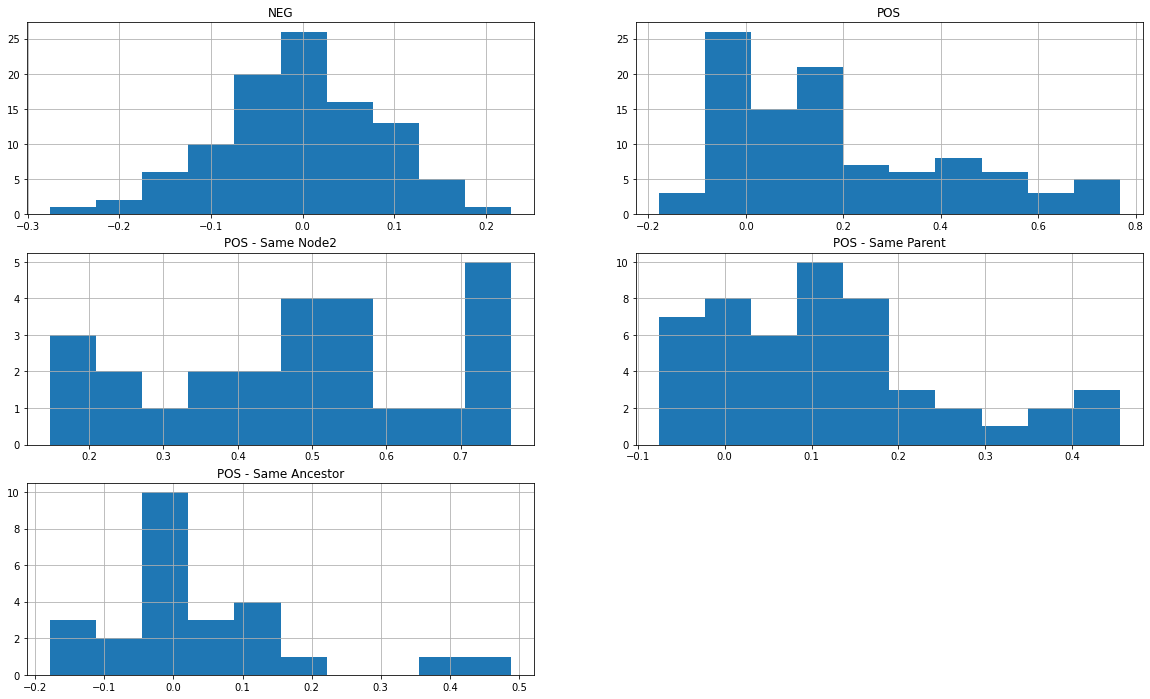

In [220]:
plot_hist_distributions(trainingDF_cosSimed_glove)

72.0


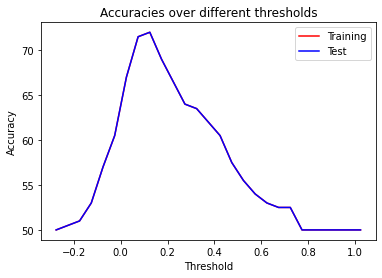

In [221]:
train_and_generate_curves(trainingDF_cosSimed_glove)

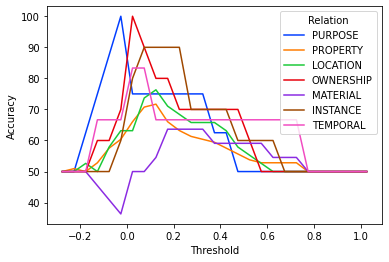

In [222]:
train_and_generate_rel_based_acc_curves(trainingDF_cosSimed_glove)

In [223]:
supervised_train_and_compute_acc(trainingDF_cosSimed_glove)

74.0

Extracted 234 embeddings
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 234 samples in 0.000s...
[t-SNE] Computed neighbors for 234 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 234 / 234
[t-SNE] Mean sigma: 1.935393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 124.982422
[t-SNE] KL divergence after 1000 iterations: 1.889792


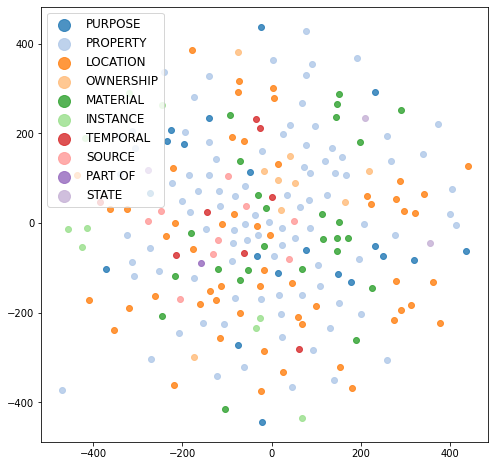

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 234 samples in 0.001s...
[t-SNE] Computed neighbors for 234 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 234 / 234
[t-SNE] Mean sigma: 1.935393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 184.550507
[t-SNE] KL divergence after 1000 iterations: 3.450617


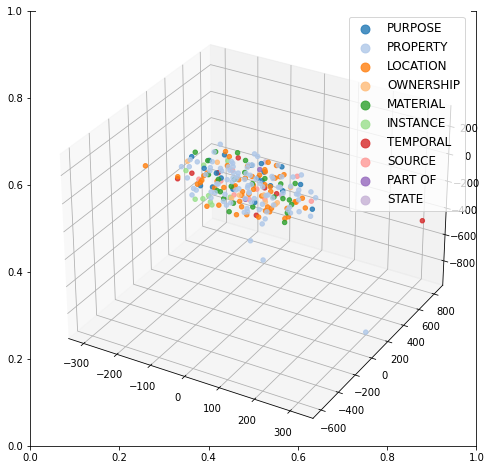

In [224]:
analyse_tsne_clusters(trainingDF_cosSimed_glove)

In [225]:
trainingDF_cosSimed_glove.columns

Index(['node1', 'node2', 'node1_label', 'node2_label', 'relation',
       'other_node1', 'other_node2', 'other_node1_label', 'other_node2_label',
       'other_relation', 'type', 'Verified', 'node1_desc', 'node2_desc',
       'other_node1_desc', 'other_node2_desc', 'comment', 'par_node',
       'par_label', 'pair1_ancestor', 'pair2_ancestor', 'top_pars_list',
       'Unnamed: 22', 'cosSim', 'diffArr1', 'childLen1', 'parLen1', 'diffArr2',
       'childLen2', 'parLen2', 'target'],
      dtype='object')

Train, Val accuracies for yes/no target ([0.99], [0.48500000000000004])


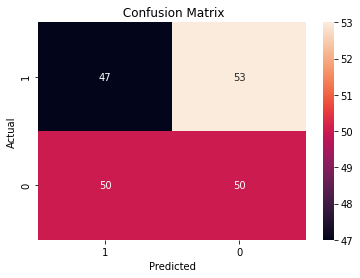

In [240]:
print("Train, Val accuracies for yes/no target", train_embed_analogy_svc(trainingDF_cosSimed_glove, 'target', 300))

In [241]:
trainingDF_cosSimed_glove[:100].relation.value_counts()

PROPERTY     53
LOCATION     19
MATERIAL     11
INSTANCE      5
OWNERSHIP     5
PURPOSE       4
TEMPORAL      3
Name: relation, dtype: int64

/nas/home/kshenoy/miniconda3/envs/kgtkEnv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Train, Val accuracies for relation ([0.9911111111111112], [0.71])


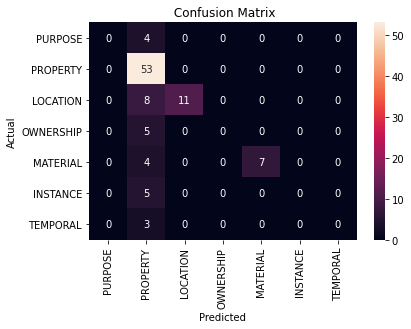

In [244]:
print("Train, Val accuracies for relation", train_embed_analogy_svc(trainingDF_cosSimed_glove[:100], 'relation', 300))

In [245]:
generate_google_proj_files(trainingDF_cosSimed_glove, 'glove')

Extracted 234 embeddings
Saved emb file: ../data/analogical_proj/emb_files_for_google_projections/glove.emb.Nov_22_2021.tsv
Saved labels file: ../data/analogical_proj/emb_files_for_google_projections/glove.lab.Nov_22_2021.tsv


## W2vec analysis

In [246]:
trainingDF_cosSimed_w2vec = trainingDF.join(get_results(trainingDF, model_w2v))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [247]:
trainingDF_cosSimed_w2vec[trainingDF_cosSimed_w2vec.cosSim == 0]

node1     node2           node1_label node2_label  relation  \
48    Q605175  Q2352616  astronomical catalog   catalogue  PROPERTY   
50    Q483654      Q432           Sunni Islam       Islam  INSTANCE   
60   Q6046150   Q170321    interdunal wetland     wetland  LOCATION   
76      Q7991      Q336       natural science     science  PROPERTY   
78      Q9192     Q7850      Mandarin Chinese     Chinese  LOCATION   
88      Q6786     Q6718          bottom quark       quark  PROPERTY   
110  Q1045756      Q638      microtonal music       music  PROPERTY   
130  Q1587903      Q336         human science     science  PROPERTY   
137     Q5860      Q161         carbon fibers       fiber  MATERIAL   
148   Q605175  Q2352616  astronomical catalog   catalogue  PROPERTY   
160  Q6046150   Q170321    interdunal wetland     wetland  LOCATION   

    other_node1 other_node2           other_node1_label other_node2_label  \
48     Q5707594     Q191067                news article           article   
50    Q17055687       Q9598                  Yao Taoism            Taoism   
60       Q23442     Q205895                      island          landmass   
76     Q1140700      Q11635     improvisational theatre           theatre   
78     Q1122452      Q29536           Germanic paganism          paganism   
88    Q55511397     Q107968            monoatomic anion             anion   
110    Q8001361     Q241741        wildlife of Botswana          wildlife   
130   Q12208528       Q7188       Government of Algeria        government   
137   Q26227893      Q36192                   childlore          folklore   
148     Q583355       Q1071  geography of North America         geography   
160   Q23579684       Q1071         cognitive geography         geography   

    other_relation  ...                                     pair2_ancestor  \
48        PROPERTY  ...                                                NaN   
50        INSTANCE  ...                                                NaN   
60        LOCATION  ...                                                NaN   
76        PROPERTY  ...  Q11635:theater|Q184485:performing arts|Q201852...   
78        LOCATION  ...  Q29536:paganism|Q9174:religion|Q3702971:person...   
88        PROPERTY  ...  Q107968:anion|Q36496:ion|Q2393187:molecular en...   
110       LOCATION  ...                                                NaN   
130       LOCATION  ...                                                NaN   
137       PROPERTY  ...                                                NaN   
148       LOCATION  ...                                                NaN   
160       PROPERTY  ...                                                NaN   

                              top_pars_list  \
48                                      NaN   
50                                      NaN   
60                                      NaN   
76            entity,object,abstract object   
78   entity,object,abstract object,property   
88   entity,object,physical object,particle   
110                                     NaN   
130                                     NaN   
137                                     NaN   
148                                     NaN   
160                                     NaN   

                                           Unnamed: 22 cosSim  \
48                                                 NaN    0.0   
50                                                 NaN    0.0   
60                                                 NaN    0.0   
76             entity,object,abstract object,structure    0.0   
78   entity,object,abstract object,structure,proper...    0.0   
88              entity,object,physical object,particle    0.0   
110                                                NaN    0.0   
130                                                NaN    0.0   
137                                                NaN    0.0   
148                                                NaN    0.0   
160          

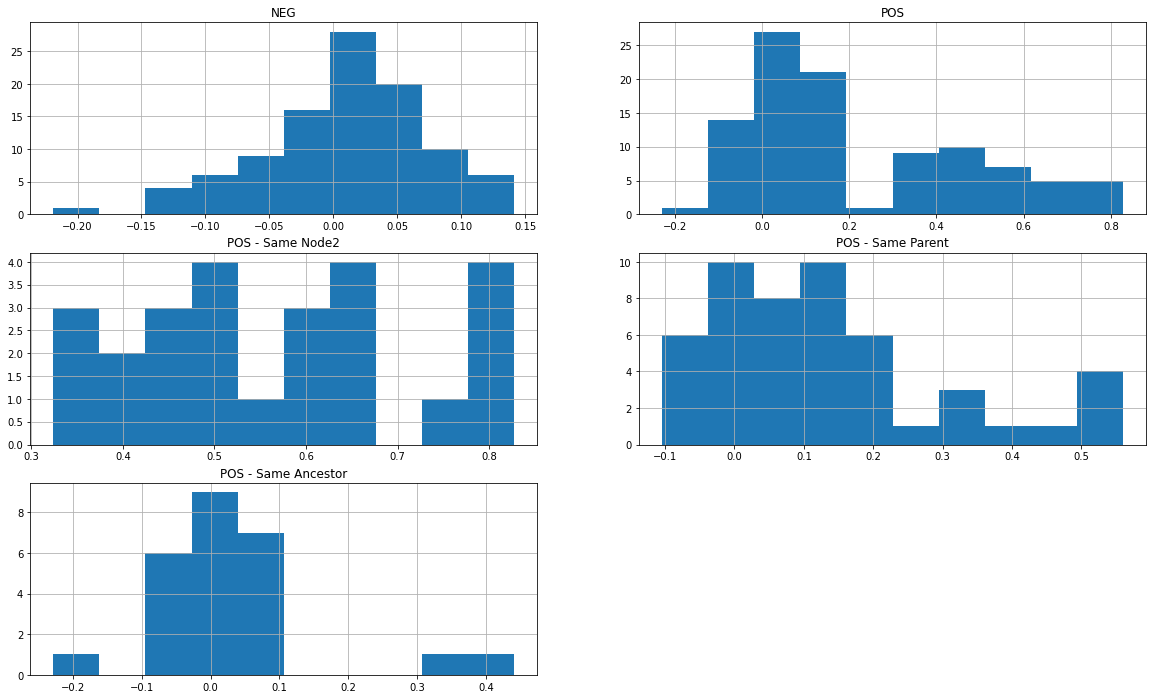

In [248]:
plot_hist_distributions(trainingDF_cosSimed_w2vec)

74.00000000000001


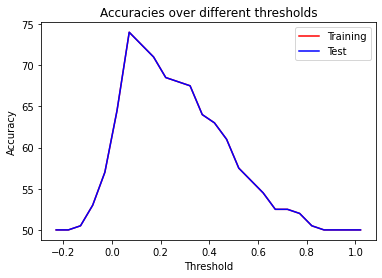

In [249]:
train_and_generate_curves(trainingDF_cosSimed_w2vec)

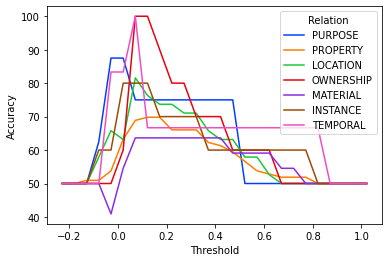

In [250]:
train_and_generate_rel_based_acc_curves(trainingDF_cosSimed_w2vec)

In [251]:
supervised_train_and_compute_acc(trainingDF_cosSimed_w2vec)

72.0

Extracted 234 embeddings
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 234 samples in 0.000s...
[t-SNE] Computed neighbors for 234 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 234 / 234
[t-SNE] Mean sigma: 0.896764
[t-SNE] KL divergence after 250 iterations with early exaggeration: 137.975464
[t-SNE] KL divergence after 1000 iterations: 2.340683


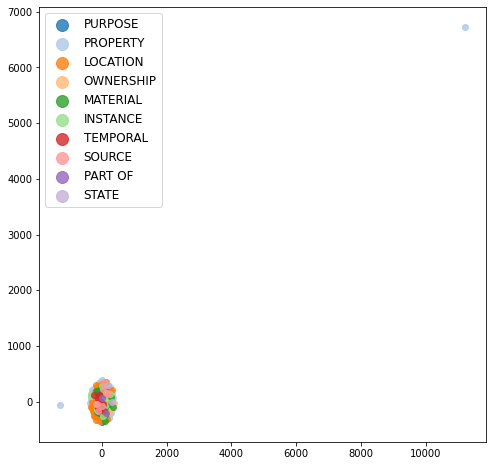

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 234 samples in 0.000s...
[t-SNE] Computed neighbors for 234 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 234 / 234
[t-SNE] Mean sigma: 0.896764
[t-SNE] KL divergence after 250 iterations with early exaggeration: 192.596817
[t-SNE] KL divergence after 1000 iterations: 3.171241


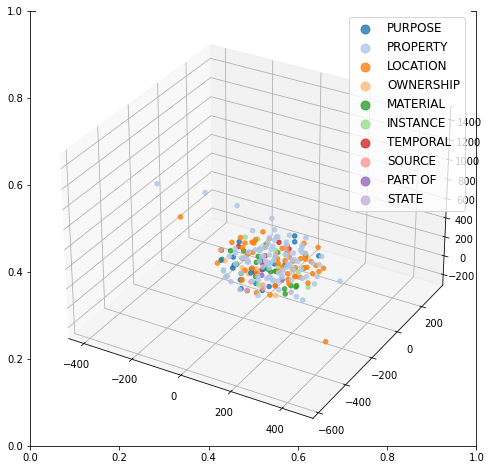

In [252]:
analyse_tsne_clusters(trainingDF_cosSimed_w2vec)

Train, Val accuracies for yes/no target ([0.971111111111111], [0.45499999999999996])


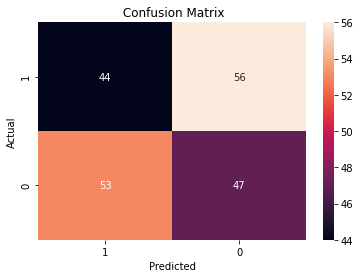

In [253]:
print("Train, Val accuracies for yes/no target", train_embed_analogy_svc(trainingDF_cosSimed_w2vec, 'target', 300))

/nas/home/kshenoy/miniconda3/envs/kgtkEnv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Train, Val accuracies for relation ([0.9766666666666666], [0.69])


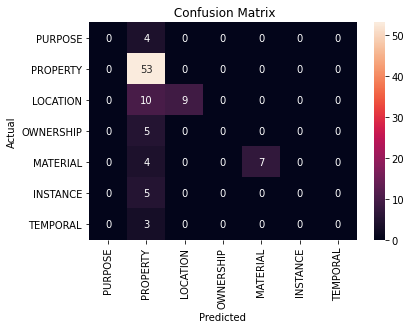

In [254]:
print("Train, Val accuracies for relation", train_embed_analogy_svc(trainingDF_cosSimed_w2vec[:100], 'relation', 300))

In [255]:
generate_google_proj_files(trainingDF_cosSimed_w2vec, 'w2vec')

Extracted 234 embeddings
Saved emb file: ../data/analogical_proj/emb_files_for_google_projections/w2vec.emb.Nov_22_2021.tsv
Saved labels file: ../data/analogical_proj/emb_files_for_google_projections/w2vec.lab.Nov_22_2021.tsv


## BERT analysis

In [65]:
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from time import time
import pandas as pd
import requests

def get_bert_based_cosSim(trainingDF, modelName, structure_index):
    def fetchDescription(qnode):
        try:
            return requests.get('http://ckg07:9200/wikidatadwd-augmented/_doc/'+qnode).json()['_source']['descriptions']['en'][0]
        except:
            return str(False)
    def fetch_label(qnode):
        try:
            return requests.get('http://ckg07:9200/wikidatadwd-augmented/_doc/'+qnode).json()['_source']['labels']['en'][0]
        except:
            return str(False)
    
    def getSentEmbeddings(valSeries, modelName):
        model = SentenceTransformer(modelName)
        start = time()
        encodings = model.encode(valSeries)
        return encodings
    
    rows = []
    for _,row in tqdm(trainingDF.iterrows()):
        if structure_index == 1: 
            # node1_label node1_desc is related to node2_label node2_desc
            row['pair1_desc'] = fetch_label(row['node1']) + ' ' + fetchDescription(row['node1']) + \
                                ' is related to ' + fetch_label(row['node2']) + ' ' + fetchDescription(row['node2'])
            row['pair2_desc'] = fetch_label(row['other_node1']) + ' ' + fetchDescription(row['other_node1']) + \
                                ' is related to ' + fetch_label(row['other_node2']) + ' ' + fetchDescription(row['other_node2'])
        elif structure_index == 2:
            # node1_label is node1_desc
            row['pair1_desc'] = fetch_label(row['node1']) + ' is ' + fetchDescription(row['node1'])
            row['pair2_desc'] = fetch_label(row['other_node1']) + ' is ' + fetchDescription(row['other_node1'])
        elif structure_index == 3:
            # node1_label is related to node2_label
            row['pair1_desc'] = fetch_label(row['node1']) + \
                                ' is related to ' + fetch_label(row['node2'])
            row['pair2_desc'] = fetch_label(row['other_node1']) + \
                                ' is related to ' + fetch_label(row['other_node2'])
        rows.append(row)
    analogicalDF = pd.DataFrame(rows)
    analogicalDF['pair1_emb'] = pd.Series(list(getSentEmbeddings(analogicalDF['pair1_desc'], modelName)))
    analogicalDF['pair2_emb'] = pd.Series(list(getSentEmbeddings(analogicalDF['pair2_desc'], modelName)))
    analogicalDF['cosSim'] = analogicalDF.apply(lambda p: cosine_similarity(np.array(p['pair1_emb']).reshape(1,-1),np.array(p['pair2_emb']).reshape(1,-1))[0][0], axis=1)
    return analogicalDF

def get_bert_based_pairwise_cosSim(trainingDF, modelName, structure_index):
    def fetchDescription(qnode):
        try:
            return requests.get('http://ckg07:9200/wikidatadwd-augmented/_doc/'+qnode).json()['_source']['descriptions']['en'][0]
        except:
            return str(False)
    def fetch_label(qnode):
        try:
            return requests.get('http://ckg07:9200/wikidatadwd-augmented/_doc/'+qnode).json()['_source']['labels']['en'][0]
        except:
            return str(False)
    
    def getSentEmbeddings(valSeries, modelName):
        model = SentenceTransformer(modelName)
        start = time()
        encodings = model.encode(valSeries)
        return encodings

    rows = []
    for _,row in tqdm(trainingDF.iterrows()):
        if structure_index == 4: 
            # node1_label node1_desc is related to node2_label node2_desc
            row['node1_desc_1'] = fetch_label(row['node1']) + ' ' + fetchDescription(row['node1'])
            row['node2_desc_1'] = fetch_label(row['node2']) + ' ' + fetchDescription(row['node2'])
            
            row['other_node1_desc_1'] = fetch_label(row['other_node1']) + ' ' + fetchDescription(row['other_node1'])
            row['other_node2_desc_1'] = fetch_label(row['other_node2']) + ' ' + fetchDescription(row['other_node2'])
            
        rows.append(row)
    analogicalDF = pd.DataFrame(rows)
    analogicalDF['node1_desc_1'] = pd.Series(list(getSentEmbeddings(analogicalDF['node1_desc_1'], modelName)))
    analogicalDF['node2_desc_1'] = pd.Series(list(getSentEmbeddings(analogicalDF['node2_desc_1'], modelName)))
    
    analogicalDF['other_node1_desc_1'] = pd.Series(list(getSentEmbeddings(analogicalDF['other_node1_desc_1'], modelName)))
    analogicalDF['other_node2_desc_1'] = pd.Series(list(getSentEmbeddings(analogicalDF['other_node2_desc_1'], modelName)))
    
    analogicalDF['cosSim'] = analogicalDF.apply(lambda p: cosine_similarity(
                    np.array(p['node1_desc_1']).reshape(1,-1) - np.array(p['node2_desc_1']).reshape(1,-1),
                    np.array(p['other_node1_desc_1']).reshape(1,-1) - np.array(p['other_node2_desc_1']).reshape(1,-1)
                )[0][0], axis=1)
    return analogicalDF


### node1_label is node1_desc

In [257]:
trainingDF_cosSimed_bert = get_bert_based_cosSim(trainingDF, 'sentence-transformers/all-distilroberta-v1', 2)

0it [00:00, ?it/s]

Exception when trying to download https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip not found. Try to create it from scratch
Try to create Transformer Model sentence-transformers/all-distilroberta-v1 with mean pooling
Exception when trying to download https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip not found. Try to create it from scratch
Try to create Transformer Model sentence-transformers/all-distilroberta-v1 with mean pooling


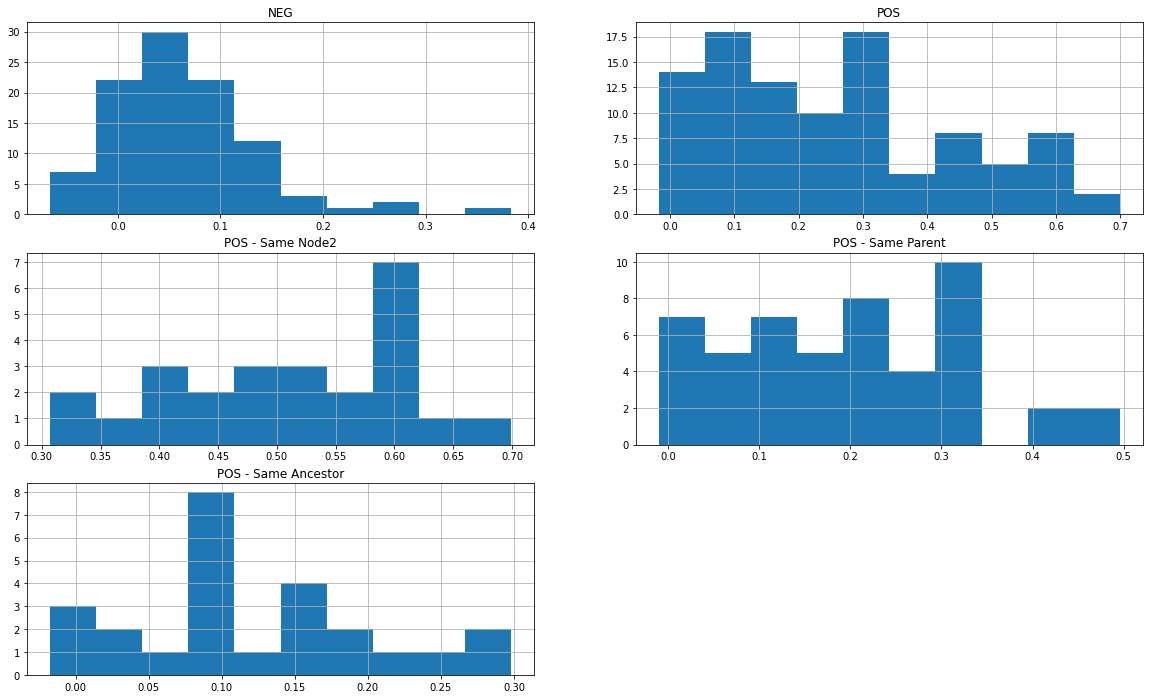

In [258]:
plot_hist_distributions(trainingDF_cosSimed_bert)

77.5


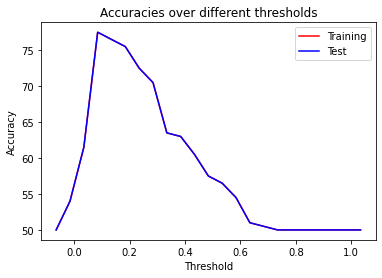

In [259]:
train_and_generate_curves(trainingDF_cosSimed_bert)

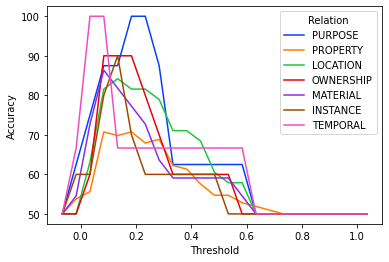

In [260]:
train_and_generate_rel_based_acc_curves(trainingDF_cosSimed_bert)

In [261]:
supervised_train_and_compute_acc(trainingDF_cosSimed_bert)

76.0

### node1_label node1_desc is related to node2_label node2_desc

In [262]:
trainingDF_cosSimed_bert = get_bert_based_cosSim(trainingDF, 'sentence-transformers/all-distilroberta-v1', 1)

0it [00:00, ?it/s]

Exception when trying to download https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip not found. Try to create it from scratch
Try to create Transformer Model sentence-transformers/all-distilroberta-v1 with mean pooling
Exception when trying to download https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip not found. Try to create it from scratch
Try to create Transformer Model sentence-transformers/all-distilroberta-v1 with mean pooling


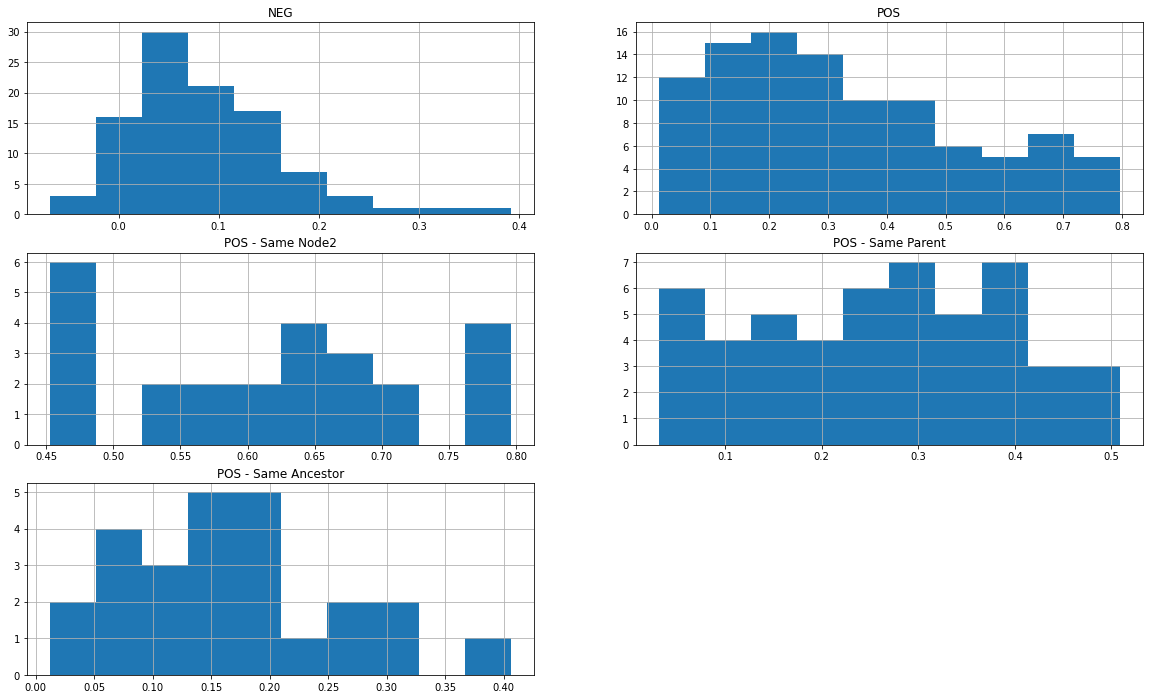

In [263]:
plot_hist_distributions(trainingDF_cosSimed_bert)

81.49999999999999


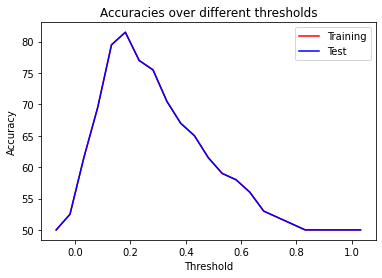

In [264]:
train_and_generate_curves(trainingDF_cosSimed_bert)

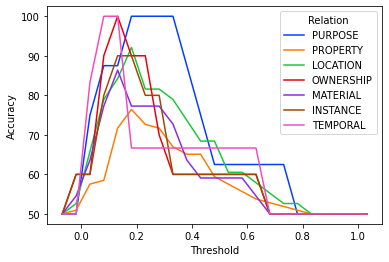

In [265]:
train_and_generate_rel_based_acc_curves(trainingDF_cosSimed_bert)

In [266]:
supervised_train_and_compute_acc(trainingDF_cosSimed_bert)

79.0

In [267]:
trainingDF_cosSimed_bert[:100].relation.value_counts()

PROPERTY     53
LOCATION     19
MATERIAL     11
INSTANCE      5
OWNERSHIP     5
PURPOSE       4
TEMPORAL      3
Name: relation, dtype: int64

In [268]:
trainingDF_cosSimed_bert['diffArr1'] = trainingDF_cosSimed_bert['pair1_emb']
trainingDF_cosSimed_bert['diffArr2'] = trainingDF_cosSimed_bert['pair2_emb']

In [269]:
trainingDF_cosSimed_bert.columns

Index(['node1', 'node2', 'node1_label', 'node2_label', 'relation',
       'other_node1', 'other_node2', 'other_node1_label', 'other_node2_label',
       'other_relation', 'type', 'Verified', 'node1_desc', 'node2_desc',
       'other_node1_desc', 'other_node2_desc', 'comment', 'par_node',
       'par_label', 'pair1_ancestor', 'pair2_ancestor', 'top_pars_list',
       'Unnamed: 22', 'pair1_desc', 'pair2_desc', 'pair1_emb', 'pair2_emb',
       'cosSim', 'target', 'diffArr1', 'diffArr2'],
      dtype='object')

Extracted 234 embeddings
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 234 samples in 0.000s...
[t-SNE] Computed neighbors for 234 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 234 / 234
[t-SNE] Mean sigma: 3.780096
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.023659
[t-SNE] KL divergence after 1000 iterations: 0.804325


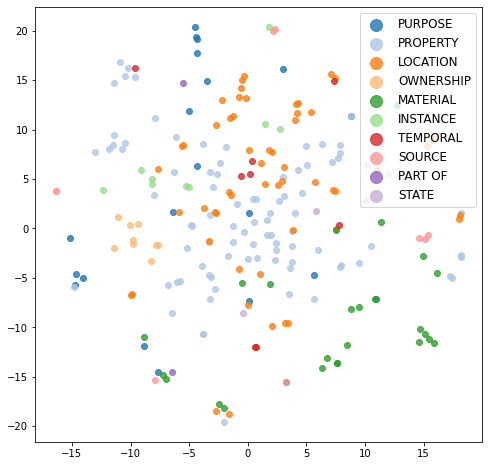

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 234 samples in 0.000s...
[t-SNE] Computed neighbors for 234 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 234 / 234
[t-SNE] Mean sigma: 3.780096
[t-SNE] KL divergence after 250 iterations with early exaggeration: 153.050140
[t-SNE] KL divergence after 1000 iterations: 2.205989


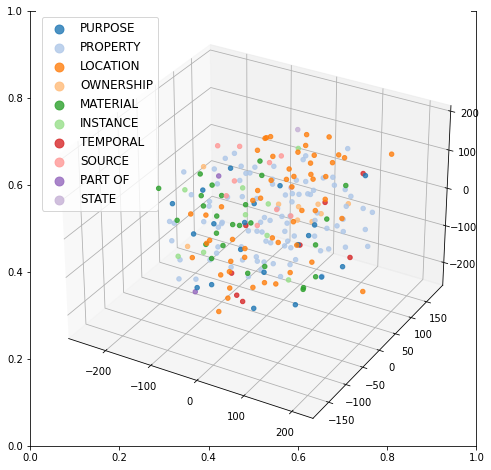

In [270]:
analyse_tsne_clusters(trainingDF_cosSimed_bert)

Train, Val accuracies for yes/no target ([0.9994444444444444], [0.535])


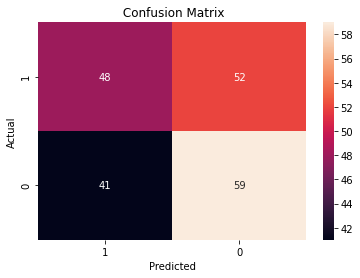

In [271]:
print("Train, Val accuracies for yes/no target", train_embed_analogy_svc(trainingDF_cosSimed_bert, 'target', 300))

In [ ]:
print("Train, Val accuracies for relation", train_embed_analogy_svc(trainingDF_cosSimed_bert[:100], 'relation'))

In [ ]:
generate_google_proj_files(trainingDF_cosSimed_bert, 'bert_v2')

### node1_label is related to node2_label

In [ ]:
trainingDF_cosSimed_bert = get_bert_based_cosSim(trainingDF, 'sentence-transformers/all-distilroberta-v1', 3)

In [ ]:
plot_hist_distributions(trainingDF_cosSimed_bert)

In [ ]:
train_and_generate_curves(trainingDF_cosSimed_bert)

In [ ]:
train_and_generate_rel_based_acc_curves(trainingDF_cosSimed_bert)

In [ ]:
supervised_train_and_compute_acc(trainingDF_cosSimed_bert)

### node1_label - node2_label

In [ ]:
trainingDF_cosSimed_bert = get_bert_based_pairwise_cosSim(trainingDF, 'sentence-transformers/all-distilroberta-v1', 4)

In [ ]:
plot_hist_distributions(trainingDF_cosSimed_bert)

In [ ]:
train_and_generate_curves(trainingDF_cosSimed_bert)

In [ ]:
train_and_generate_rel_based_acc_curves(trainingDF_cosSimed_bert)

In [ ]:
supervised_train_and_compute_acc(trainingDF_cosSimed_bert)

In [ ]:
get_relwise_acc(trainingDF_cosSimed_w2vec, 0.1).join(get_relwise_acc(trainingDF_cosSimed_bert, 0.1), rsuffix='_bert')

In [ ]:
get_typewise_acc(trainingDF_cosSimed_w2vec, 0.1).join(get_typewise_acc(trainingDF_cosSimed_bert, 0.1), rsuffix='_bert')

In [ ]:
get_overall_acc(trainingDF_cosSimed_w2vec, 0.1),  get_overall_acc(trainingDF_cosSimed_bert, 0.1)

# SemEval 2012 Dataset Generation

SemEval dataset has Testing and Training folders. In both of them, the dataset is divided into a collection of Phase 1 files and Phase 2 files. 

In Phase 1, given a list of 3-4 question pairs, first the turkers were asked to infer the common relation amongst them given a list of 4 relation choices and then were asked to suggest more answer pairs analogous to the question pairs.

In Phase 2, these proposed pairs were also taken into consideration and given the set of same question pairs, the turkers were asked to find the most similar and least similar answer pair amongst 4 choices.

Using the phase 2 results and the perl script provided, we can determine the similarity score between the answer pair and the question pairs as per the answers provided.

Using this dataset, we create the following datasets:

* Phase 1 Datasets
    * Ph1-Tr: Used Phase 1's training folder's question pairs to create all combinations of question pairs
    * Ph1-Te: Repeated the process for testing folder of Phase 1
* Phase 2 Datasets
    * Ph2-Tr: Used turker perl scripts and receieved scores for all candidate answer pairs. Used the top 10 candidate answer pairs as positive samples and bottom 10 as the negative ones. This dataset corresponds to the Training results
    * Ph2-Te: Repeated the process for testing folder of Phase 2
* MCQ Dataset: Used Ph1-Te's Q pair as Q, the A pair as correct choice and randomly picked other choices to create an MCQ dataset designed to evaluate MCQ task
* Scores dataset: Based on Ph1-Te Q pairs, added all turker scores for candidate A pairs. This creates a dataset of size |Q pairs| x |A pairs per set of questions|

## Fetch Phase 1 Q-A pairs

In [333]:
from itertools import combinations, product
from string import ascii_lowercase
import os

dataset = {'Training': [], 'Testing': []}

for mode in ['Training', 'Testing']:
    for num, alpha in product(range(1,11), ascii_lowercase):
        num = str(num)

        if not(os.path.exists(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt')) or \
            not(os.path.exists(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Answers/' + 'Phase1Answers-' + num + alpha + '.txt')):
            continue
        try:
            with open(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt') as sem_eval_f:
                lines = sem_eval_f.readlines()
                line1 = lines[0].strip().split()
                file_id, class_relation, relation = line1[1], line1[2][:-1], line1[3]
                line_num = 0
                for i, line in enumerate(lines):
                    if "What relation best describes" in line:
                        line_num = i
                        break
                examples = []
                for line in lines[4:line_num-1]:
                    for pair in line.strip().split('.'):
                        examples.append([pair_elem.strip() for pair_elem in pair.split(':')])
    #             examples = [[pair_elem for pair_elem in pair.strip().split(':')] for pair in lines[4:7]]
                for i, line in enumerate(lines):
                    if "Correct Answer" in line:
                        line_num = i + 2
                        break
                explanation = lines[line_num].strip()
            #     print(line1, examples, explanation)
    #         with open(SEM_EVAL_FILEPATH + '/Testing/Phase1Answers/' + 'Phase1Answers-' + num + alpha + '.txt') as sem_eval_f:
    #             lines = sem_eval_f.readlines()
    #             answer_pairs = []
    #             for line in lines:
    #                 answer_pairs.append([pair_elem for pair_elem in line.strip()[1:-1].split(':')])
            #     print(answer_pairs)
            for pair1, pair2 in combinations(examples,2):
                dataset[mode].append([pair1[0], pair1[1], class_relation, relation, pair2[0], pair2[1], file_id, explanation])
    #         print(dataset[mode])
        except Exception as err:
            print(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt')
            print(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Answers/' + 'Phase1Answers-' + num + alpha + '.txt')
            raise(err)

In [334]:
sem_eval_training_df = pd.DataFrame(dataset['Training'], columns=['node1', 'node2', 'class', 'relation', 'other_node1', 'other_node2', 'file_id', 'explanation'])
sem_eval_training_df = sem_eval_training_df.rename(columns={'node1': 'node1_label', 'node2': 'node2_label', 'node1_qnode': 'node1', 'node2_qnode': 'node2', 'other_node1': 'other_node1_label', 'other_node2': 'other_node2_label', 'other_node1_qnode': 'other_node1', 'other_node2_qnode': 'other_node2', 'relation': 'subrelation', 'class': 'relation'})
sem_eval_training_df['other_relation'] = sem_eval_training_df['relation']

sem_eval_testing_df = pd.DataFrame(dataset['Testing'], columns=['node1', 'node2', 'class', 'relation', 'other_node1', 'other_node2', 'file_id', 'explanation'])
sem_eval_testing_df = sem_eval_testing_df.rename(columns={'node1': 'node1_label', 'node2': 'node2_label', 'node1_qnode': 'node1', 'node2_qnode': 'node2', 'other_node1': 'other_node1_label', 'other_node2': 'other_node2_label', 'other_node1_qnode': 'other_node1', 'other_node2_qnode': 'other_node2', 'relation': 'subrelation', 'class': 'relation'})
sem_eval_testing_df['other_relation'] = sem_eval_testing_df['relation']

In [335]:
sem_eval_training_df.to_csv(SEM_EVAL_GENERATED_TRAINING_FILE, index=None)
sem_eval_testing_df.to_csv(SEM_EVAL_GENERATED_TESTING_FILE, index=None)
len(sem_eval_training_df), len(sem_eval_testing_df)

(30, 234)

In [336]:
sem_eval_training_df = pd.read_csv(SEM_EVAL_GENERATED_TRAINING_FILE)
sem_eval_testing_df = pd.read_csv(SEM_EVAL_GENERATED_TESTING_FILE)
sem_eval_training_df.head()

node1_label node2_label         relation  subrelation other_node1_label  \
0      flower       tulip  CLASS-INCLUSION    Taxonomic           emotion   
1      flower       tulip  CLASS-INCLUSION    Taxonomic              poem   
2     emotion        rage  CLASS-INCLUSION    Taxonomic              poem   
3       water        drop       PART-WHOLE  Mass:Potion              mile   
4       water        drop       PART-WHOLE  Mass:Potion              time   

  other_node2_label file_id                     explanation   other_relation  
0              rage    1(a)  Y is a kind/type/instance of X  CLASS-INCLUSION  
1            sonnet    1(a)  Y is a kind/type/instance of X  CLASS-INCLUSION  
2            sonnet    1(a)  Y is a kind/type/instance of X  CLASS-INCLUSION  
3              yard    2(c)         X may be divided into Y       PART-WHOLE  
4            moment    2(c)         X may be divided into Y       PART-WHOLE

## Label to Qnodes mapping

In [87]:
# Create Labels to Qnodes dict from Wikidata
def fetch_labels_to_qnodes_dict():
    labels_to_qnodes_dict = defaultdict(str)
    with gzip.open(LABELS_FILE) as lab_f:
        first_line = True
        for line in tqdm(lab_f, total=41845781):
            if first_line:
                first_line = False
                continue
            line = line.decode('utf-8').strip().split()
            str1 = line[3][1:-4]
            qnode = line[1]
            if qnode.startswith('Q'):
                if str1 in labels_to_qnodes_dict:
                    if int(qnode[1:]) < int(labels_to_qnodes_dict[str1][1:]):
                        labels_to_qnodes_dict[str1] = qnode
                else:
                    labels_to_qnodes_dict[str1] = qnode
    return labels_to_qnodes_dict
labels_to_qnodes_dict = fetch_labels_to_qnodes_dict()

  0%|          | 0/41845781 [00:00<?, ?it/s]

In [212]:
print(f"Created dict of {len(labels_to_qnodes_dict)} label to qnode mappings")

Created dict of 5853870 label to qnode mappings


In [112]:
fix_labels_to_qnodes_dict = {
    'crescendo': 'Q2347888',
    'fight': 'Q650711', # combat
    'kickoff': 'Q10545289',
    'dishes': 'Q746549',
    'plagiarize': 'Q164666',
    'groceries': 'Q951964', # grocery,
    'destroy': 'Q17781833',
    'inexperience': 'Q108816154',
    'bequeath': 'Q211557',
    'minds': 'Q450',
    'hurry': 'Q17598913',
    'passionate': 'Q335046',
    'bookshelf': 'Q215857',
    'comforted': 'Q1367353',
    'sandwiches': 'Q28803',
    'textbooks': 'Q83790',
    'gullibility': 'Q10841408',
    'austere': 'Q2814650',
    'projectiles': 'Q49393',
    'potable': 'Q7892',
    'infectious': 'Q18123741',
    'calculate': 'Q622821',
    'saucers': 'Q1422576',
    'graduate': 'Q508719',
    'movie': 'Q11424',
    'apostate': 'Q223681',
    'malleable': 'Q34669510',
    'infancy': 'Q49257364',
    'buying': 'Q1369832',
    'contaminate': 'Q60528603',
    'destitute': 'Q2714378',
    'numbness': 'Q1641556',
    'simmer': 'Q240164',
    'moist': 'Q217651',
    'reticent': 'Q24238091',
    'brave': 'Q208160',
    'molded': 'Q1770806',
    'criticized': 'Q17955',
    'celibate': 'Q191778',
    'vigilant': 'Q1418914',
    'trackpad': 'Q20137',
    'discount': 'Q1047056',
    'eavesdrop': 'Q320769',
    'deny': 'Q100268981',
    'socialize': 'Q185467',
    'exemplary': 'Q1383678',
    'sterilize': 'Q191618',
    'bulwark': 'Q81851',
    'gently': 'Q5533755',
    'brighten': 'Q221656',
    'scream': 'Q1932016',
    'eaten': 'Q213449',
    'protege': 'Q17138417',
    'puzzlement': 'Q557945',
    'embellish': 'Q5370025',
    'immortal': 'Q193942',
    'lubricate': 'Q1455803',
    'edible': 'Q2095',
    'obliterate': 'Q17781833',
    'lateness': 'Q25339847',
    'young': 'Q190007',
    'indulge': 'Q44777',
    'crush': 'Q4388656',
    'remember': 'Q492',
    'morbid': 'Q65169293',
    'comprehend': 'Q46744',
    'vigorous': 'Q56037291',
    'popular': 'Q1357284',
    'careless': 'Q691101',
    'disparage': 'Q5282527',
    'juggernaut': 'Q145660',
    'fertilize': 'Q83323',
    'enigma': 'Q47054',
    'extant': 'Q468777',
    'rich': 'Q106804044',
    'inception': 'P571',    # Q3406134
    'listener': 'Q6646450',
    'discordant': 'Q104813442',
    'mend': 'Q2144962',
    'tiny': 'Q24245823',
    'lushness': 'Q336019',
    'abruptly': 'P1478',
    'plenitude': 'Q336019',
    'quietly': 'Q502261',
    'live': 'Q3',
    'alive': 'Q3',
    'garbled': 'Q1347355',
    'leer': 'Q600717',
    'fast': 'Q3711325',
    'vista': 'Q107425',
    'broken': 'Q5120022',
    'elusive': 'Q50388354',
    'obtrusive': 'Q19357896',
    'flimsy': 'Q898288',
    'refreshments': 'Q749316',
    'satiation flee': 'Q1350299',
    'inconsolable': 'Q1369657',
    'pessimistic': 'Q484954',
    'germinate': 'Q193838',
    'wealthy': 'Q200535',
    'nuts': 'Q3320037',
    'quiet': 'Q502261',
    'impermeable': 'Q256699',
    'sterile': 'Q723758',
    'laugh': 'Q170579',
    'jump': 'Q1151752',
    'chopping': 'Q196751',
    'weapons': 'Q728',
    'ignorant': 'Q815577',
    'energized': 'Q11379',
    'eyeshadow': 'Q964307',
    'clothes': 'Q11460',
    'germs': 'Q39833',
    'elderly': 'Q191089',
    'innovative': 'Q174165',
    'forgive': 'Q537963',
    'cards': 'Q142714',
    'enjoy': 'Q8',
    'drunk': 'Q250062',
    'tv': 'Q289',
    'yell': 'Q1932016',
    'coerce': 'Q325980',
    'jobless': 'Q41171',
    'legs': 'Q133105',
    'lethal': 'Q1720706',
    'subordinate': 'Q188619',
    'selfish': 'Q36381317',
    'humor': 'Q35874',
    'persuade': 'Q1231428',
    'shopper': 'Q830036',
    'breathe': 'Q9530',
    'burns': 'Q170518',
    'salesperson': 'Q685433',
    'stitching': 'Q652122',
    'scarce': 'Q815758',
    'smiling': 'Q487',
    'alert': 'Q1751569',
    'obese': 'Q12174',
    'infringement': 'Q16963602',
    'satisfied': 'Q1350299',
    'tastebuds': 'Q862867',
    'uphold': 'Q109925608',
    'reject': 'Q1765748',
    'talkative': 'Q302152',
    'divorcee': 'Q93190',
    'smelled': 'Q1541064',
    'corpse': 'Q48422',
    'boyhood': 'Q276258',
    'unfair': 'Q770480',
    'angelic': 'Q235113',
    'communicate': 'Q11024',
    'wearable': 'Q4845080',
    'optimist': 'Q485446',
    'dunes': 'Q25391',
    'numbers': 'Q11563',
    'players': 'Q4197743',
    'burned': 'Q468455',
    'humble': 'Q1186677',
    'destitution': 'Q2714378',
    'girlhood': 'Q3031',
    'desperate': 'Q4340209',
    'pants': 'Q39908',
    'empty': 'Q67932942',
    'snacks': 'Q749316',
    'instrument': 'P1303',
    'betray': 'Q2166722',
    'working': 'Q656365',
    'destination': 'Q12769393',
    'parishioner': 'Q102496',
    'kissing': 'Q7307',
    'misspelled': 'Q1984758',
    'crows': 'Q388450',
    'sewed': 'Q652122',
    'warmth': 'Q28128222',
    'lethargic': 'Q15637420',
    'utensils': 'Q3773693',
    'shoelace': 'Q559045',
    'tired': 'Q9690',
    'chemical': 'Q11173',
    'absolve': 'Q164361',
    'sealed': 'Q17145405',
    'worn': 'Q617224',
    'excited': 'Q215328',
    'shattered': 'Q7490719',
    'sheets': 'Q11472',
    'buoyant': 'Q6497624',
    'threaten': 'Q707125',
    'restful': 'Q20980706',
    'fix': 'Q2144962',
    'impossible': 'Q315562',
    'punctual': 'Q153487',
    'peaceful': 'Q454',
    'pans': 'Q154038',
    'dense': 'Q29539',
    'tycoon': 'Q911554',
    'hive': 'Q165107',
    'dogs': 'Q144',
    'garrulous': 'Q302152',
    'addict': 'Q12029',
    'marchland': 'Q7695',
    'ingredients': 'Q10675206',
    'judging': 'Q12621536',
    'powerful': 'Q25342',
    'shiny': 'Q1079524',
    'interesting': 'Q616314',
    'inspire': 'P941',
    'flammable': 'Q910035',
    'sleepy': 'Q35831',
    'previews': 'Q2751794',
    'borrow': 'Q3196867',
    'sharpen': 'Q237105',
    'decrescendo': 'Q1994559',
    'tires': 'Q169545',
    'initiate': 'Q594939',
    'jog': 'Q816261',
    'feet': 'Q15807',
    'movements': 'Q79782',
    'wooden': 'Q287',
    'shirts': 'Q76768',
    'permanent': 'Q20742557',
    'dizzy': 'Q10916362',
    'airplane': 'Q197',
    'scratch': 'Q3819233',
    'guardrail': 'Q3095365',
    'tylenol': 'Q57055',
    'burp': 'Q209789',
    'volleying': 'Q1202096',
    'stretched': 'Q1183039',
    'gigantic': 'Q501829',
    'garment': 'Q11460',
    'toys': 'Q1255568',
    'shorten': 'Q1194601',
    'intercourse': 'Q5873',
    'bugs': 'Q1390',
    'marketed': 'Q39809',
    'slurred': 'Q21117191',
    'automobile': 'Q3231690',
    'eyes': 'Q7364',
    'treats': 'Q2095',
    'donate': 'Q1124860',
    'forgiven': 'Q537963',
    'cassette': 'Q149757',
    'hormones': 'Q11364',
    'arrogant': 'Q3071551',
    'chips': 'Q173265',
    'hilarity': 'Q35874',
    'chairs': 'Q15026',
    'snowstorms': 'Q1136525',
    'monochromatic': 'Q10770146',
    'fairytale': 'Q699',
    'bathe': 'Q327651',
    'moisturize': 'Q3006091',
    'apples': 'Q89',
    'expired': 'Q898931',
    'injured': 'Q193078',
    'deceased': 'Q4',
    'dirtiness': 'Q107998873',
    'forgetful': 'Q1377840',
    'hungry': 'Q3535686',
    'waning': 'Q34604447',
    'slurp': 'Q86915760',
    'loudly': 'Q622324',
    'meal': 'Q6460735',
    'aloof': 'Q913668',
    'loving': 'Q316',
    'shoes': 'Q22676',
    'helping': 'Q5710255',
    'chewing': 'Q827742',
    'harvesting': 'Q213753',
    'pitching': 'Q1048902',
    'nourishment': 'Q2138622',
    'angry': 'Q79871',
    'salty': 'Q3734963',
    'filled': 'Q745361',
    'preach': 'Q857037',
    'dirty': 'Q555882',
    'safely': 'Q7398460',
    'killer': 'Q931260',
    'sticks': 'Q11162356',
    'starving': 'Q853930',
    'quadriplegic': 'Q944758',
    'bigot': 'Q859781',
    'enthusiastic': 'Q107261265',
    'embarrassed': 'Q1761451',
    'fibers': 'Q161',
    'geese': 'Q16529344',
    'cured': 'Q1595418',
    'negotiate': 'Q202875',
    'atheist': 'Q13211738',
    'cookies': 'Q13266',
    'gutters': 'Q1094134',
    'successfully': 'Q7632586',
    'playing': 'Q1150958',
    'flawed': 'Q5801290',
    'poisonous': 'Q40867',
    'agitated': 'Q394129',
    'damaged': 'Q481609',
    'stinky': 'Q485537',
    'honest': 'Q337349',
    'curtains': 'Q49005',
    'generous': 'Q1549811',
    'delicious': 'Q4173974',
    'employed': 'Q656365',
    'makeup': 'Q131207',
    'frosting': 'Q29437',
    'maps': 'Q42515',
    'empathetic': 'Q182263',
    'waitress': 'Q157195',
    'shiver': 'Q1060890',
    'dishonest': 'Q4925193',
    'knead': 'Q3089784',
    'fragrant': 'Q15043636',
    'forks': 'Q81881',
    'meek': 'Q1623449',
    'below': 'Q15332388',
    'discreet': 'Q1503443',
    'pets': 'Q39201',
    'melodic': 'Q170412',
    'unpleasant': 'Q47455774',
    'explode': 'Q179057',
    'satanic': 'Q58185862',
    'gloves': 'Q169031',
    'encapsulate': 'Q1305241',
    'offended': 'Q571571',
    'tiredness': 'Q9690',
    'tedious': 'Q34255',
    'unorganized': 'Q41581869',
    'dusting': 'Q165632',
    'muscles': 'Q7060553',
    'cruel': 'Q1936750',
    'skinny': 'Q1146902',
    'tease': 'Q518090',
    'rotten': 'Q696715',
    'snobby': 'Q728497',
    'tasty': 'Q124794',
    'bike': 'Q11442',
    'apologize': 'Q18425994',
    'infinite': 'Q205',
    'bodies': 'Q23852',
    'lashes': 'Q160108',
    'thirsty': 'Q474187',
    'courageous': 'Q208160',
    'raise': 'Q1326354',
    'presents': 'Q184303',
    'invisible': 'Q762018',
    'fridge': 'Q37828',
    'students': 'Q48282',
    'omniscient': 'Q1424662',
    'exhausted': 'Q9690',
    'abundant': 'Q4670625',
    'instructions': 'Q1665268',
    'noisy': 'Q11306265',
    'revived': 'Q188681',
    'therapy': 'Q179661',
    'miniscule': 'Q24245823',
    'messy': 'Q19267329',
    'chubby': 'Q332428',
    'sneaker': 'Q1929383',
    'witty': 'Q2238195',
    'trendy': 'Q13427002',
    'twisted': 'Q852345',
    'intangible': 'Q427581',
    'growing': 'Q732240',
    'growl': 'Q3118129',
    'stutter': 'Q186676',
    'sale': 'Q194189',
    'groan': 'Q4115495',
    'diapers': 'Q187359',
    'bunch': 'Q10619158',
    'apathetic': 'Q309406',
    'fizzy': 'Q2797526',
    'intoxicate': 'Q205972',
    'cheered': 'Q15729215',
    'yelling': 'Q1932016',
    'truthful': 'Q7949',
    'pennies': 'Q234129',
    'terrible': 'Q28484760',
    'tangible': 'Q1485500',
    'pregnant': 'Q104720811',
    'cleaned': 'Q692096',
    'acclaim': 'Q419736',
    'backward': 'Q16938807',
    'attentive': 'Q6501338',
    'experimenting': 'Q101965',
    'crimes': 'Q83267',
    'clean': 'Q692096',
    'glutton': 'Q181022',
    'traveler': 'Q22813352',
    'courses': 'Q14915034',
    'reluctant': 'Q17285919',
    'slippery': 'Q2306510',
    'phd': 'Q209896',
    'bricks': 'Q40089',
    'soothe': 'Q20740046',
    'productive': 'Q2634309',
    'trees': 'Q10884',
    'fornicate': 'Q927079',
    'antibiotics': 'Q12187',
    'shampooing': 'Q180204',
    'honestly': 'Q337349',
    'seating': 'Q2207370',
    'tall': 'Q476112',
    'dolls': 'Q168658',
    'retiree': 'Q64825398',
    'around': 'Q5727902',
    'wounded': 'Q184753',
    'changed': 'Q1150070',
    'injure': 'Q193078',
    'cars': 'Q1420',
    'survive': 'Q104482419',
    'animals': 'Q729',
    'talking': 'Q52943',
    'insured': 'Q43183',
    'attorney': 'Q40348',
    'senators': 'Q15686806',
    'fixed': 'Q2144962',
    'oceans': 'Q9430',
    'plants': 'Q756',
    'tears': 'Q76469',
    'raucous': 'Q3930506',
    'cooperate': 'Q380962',
    'sew': 'Q652122',
    'tarnished': 'Q445686',
    'generalize': 'Q170084',
    'chilly': 'Q270952',
    'paycheck': 'Q1344886',
    'understood': 'Q46744',
    'gorilla': 'Q307157',
    'christmas': 'Q19809',
    'heal': 'Q1581290',
    'languages': 'Q34770',
    'shined': 'Q47495874',
    'barren': 'Q4863385',
    'emotional': 'Q9415',
    'rides': 'Q1144661',
    'believers': 'Q5410500',
    'fail': 'Q1121708',
    'above': 'Q15332375',
    'lazy': 'Q484',
    'sickness': 'Q12136',
    'libraries': 'Q7075',
    'polish': 'Q107353683',
    'hateful': 'Q160232',
    'appliance': 'Q212920',
    'touched': 'Q1485500',
    'hairy': 'Q28472',
    'whisper': 'Q1434962',
    'stamps': 'Q37930',
    'psychotic': 'Q170082',
    'giggle': 'Q170579',
    'sexy': 'Q464859',
    'curable': 'Q1595418',
    'lazily': 'Q484',
    'fruitful': 'Q2111958',
    'give': 'Q31807746',
    'doable': 'Q21159976',
    'defiantly': 'Q3153728',
    'operate': 'Q28972820',
    'hindering': 'Q264661',
    'flexible': 'Q65921492',
    'ecstatic': 'Q625143',
    'emaciated': 'Q568378',
    'deliver': 'Q2334804',
    'cashews': 'Q7885904',
    'humorlessly': 'Q35874',
    'peal': 'Q178812',
    'dazed': 'Q333173',
    'blindly': 'Q737460',
    'valuables': 'Q194112',
    'audible': 'Q160289',
    'lumpy': 'Q109186',
    'soiled': 'Q107998873',
    'arrhythmia': 'Q189331',
    'surround': 'Q23497974',
    'conservative': 'Q107183156',
    'authoring': 'Q482980',
    'reins': 'Q2196000',
    'suckle': 'Q174876',
    'bejewelled': 'Q161439',
    'studying': 'Q2647254',
    'guests': 'Q18089644',
    'penetrated': 'Q4096960',
    'scold': 'Q1932016',
    'pliable': 'Q65921492',
    'bland': 'Q30100868',
    'hearty': 'Q13056977',
    'detested': 'Q160232',
    'preserver': 'Q4795923',
    'fecund': 'Q2587899',
    'photogenic': 'Q11633',
    'alacrity': 'Q104776247',
    'warn': 'Q1759104',
    'irresponsible': 'Q314112',
    'unkempt': 'Q79091443',
    'motionlessly': 'Q5788637',
    'lightened': 'Q84761689',
    'disgruntled': 'Q290620',
    'darken': 'Q204170',
    'bees': 'Q1390',
    'outgoing': 'Q4116378',
    'choppy': 'Q190132',
    'blemishes': 'Q5801290',
    'blemish': 'Q5801290',
    'purling': 'Q652122',
    'kindly': 'Q488085',
    'imply': 'Q3149445',
    'fearless': 'Q208160',
    'venus': 'Q313',
    'carefully': 'Q21127725',
    'obnoxious': 'Q256401',
    'sports': 'Q349',
    'liked': 'Q1124198',
    'calories': 'Q87260855',
    'earsplitting': 'Q622324',
    'softly': 'Q12894628',
    'unkind': 'Q47455774',
    'disobedient': 'Q57399871',
    'unplug': 'Q5281646',
    'splurge': 'Q2518026',
    'inflexible': 'Q2333152',
    'halted': 'Q22083730',
    'agonizing': 'Q1436482',
    'plenteousness': 'Q659662',
    'shatter': 'Q17781833',
    'harmed': 'Q15098235',
    'mexico': 'Q96',
    'reparable': 'Q2144962',
    'gaggle': 'Q16529344',
    'shine': 'Q1079524',
    'playbook': 'Q58142059',
    'knowingly': 'Q9081',
    'purchase': 'Q1369832',
    'unflappable': 'Q20740046',
    'discard': 'Q106561871',
    'unpardonable': 'Q96280471',
    'fords': 'Q44294',
    'invincible': 'Q2526135',
    'incomprehensible': 'Q723897',
    'irreparable': 'Q30317309',
    'cower': 'Q44619',
    'inexorable': 'Q5788637',
    'unbreakable': 'Q486802',
    'invulnerable': 'Q2526135',
    'diary': 'Q185598',
    'rich': 'Q200535',
    'viable': 'Q624501',
    'course': 'Q1962728',
    'kickoff': 'Q570364',
    'hug': 'Q328703',
    'hole': 'Q20204151',
    'holes': 'Q20204151',
    'hate': 'Q160232',
    'obsessed': 'Q848036',
    'pedantic': 'Q2066166',
    'twirl': 'Q733010',
    'careful': 'Q16514836',
    'separated': 'Q898987',
    'naivete': 'Q1642590',
    'underdeveloped': 'Q2476047',
    'habitual': 'Q1299714',
    'elevate': 'Q302334',
    'educated': 'Q8434',
    'burnt': 'Q133235',
    'vegetables': 'Q11004',
    'heist': 'Q2727213',
    'thoughtful': 'Q9420',
    'fashions': 'Q12684',
    'cautious': 'Q21127725',
    'scepter': 'Q152065',
    'homogenize': 'Q25345654',
    'defend': 'Q838247',
    'anorexic': 'Q254327',
    'inches': 'Q218593',
    'decorate': 'Q335261',
    'succeed': 'Q7632586',
    'pretty': 'Q7242',
    'pages': 'Q1069725',
    'investments': 'Q4290',
    'sofa': 'Q131514',
    'hyperventilate': 'Q575168',
    'letters': 'Q133492',
    'lovable': 'Q316',
    'attract': 'Q4818701',
    'desecrate': 'Q2111921',
    'residents': 'Q2359691',
    'feathers': 'Q81025',
    'insomniac': 'Q1869874',
    'tunes': 'Q2254667',
    'pizza': 'Q177',
    'beautify': 'Q7242',
    'shrubs': 'Q42295',
    'enraged': 'Q153641',
    'incompetent': 'Q62562253',
    'criticize': 'Q17955',
    'seconds': 'Q11574',
    'hate': 'Q160232',
    'magnanimous': 'Q1549475',
    'nutritious': 'Q2138622',
    'depressed': 'Q42844',
    'droplets': 'Q185789',
    'mature': 'Q3543263',
    'poop': 'Q204015',
    'hyperventilating': 'Q575168',
    'efficient': 'Q1034411',
    'quick': 'Q3711325',
    'concerned': 'Q1436482',
    'iron': 'Q1650142',
    'pressed': 'Q1650142',
    'obsessed': 'Q848036',
    'frigid': 'Q270952',
    'rapid': 'Q3711325',
    'taciturn': 'Q502261',
    'roots': 'Q41500',
    'contentious': 'Q1255828',
    'inflammable': 'Q910035',
    'divide': 'Q18511800',
    'overcooked': 'cooking',
    'snip': 'Q196751',
    'christianity': 'Q5043',
    'morose': 'Q192077',
    'astilbe': 'Q159001',
    'dismayed': 'Q104776588',
    'entreat': 'Q106954307',
    'fastidious': 'Q108039762',
    'vital': 'Q191631',
    'slums': 'Q201759',
    'crazy': 'Q505619',
    'womb': 'Q9612',
    'reclusive': 'Q2303143',
    'forms': 'Q279749',
    'antiquity': 'Q2906114',
    'wrinkled': 'Q349185',
    'behind': 'Q16938807',
    'babies': 'Q998',
    'thawed': 'Q1368357',
    'cute': 'Q1183652',
    'bankrupt': 'Q152074',
    'skilled': 'Q205961',
    'curious': 'Q366791',
    'drown': 'Q506616',
    'uninformed': 'Q815577',
    'drunkenness': 'Q205972',
    'timely': 'Q153487',
    'shops': 'Q126793',
    'cellphone': 'Q17517',
    'gild': 'Q1334300',
    'flirtation': 'Q208704',
    'antihistamine': 'Q324089',
    'teachers': 'Q37226',
    'workout': 'Q219067',
    'melancholy': 'Q192077',
    'thirstiness': 'Q474187',
    'silverware': 'Q1683099',
    'gradually': 'Q948814',
    'forgiving': 'Q537963',
    'loans': 'Q189539',
    'evanescent': 'Q4916901',
    'passively': 'Q396568',
    'renter': 'Q157171',
    'confused': 'Q557945',
    'belligerence': 'Q2363432',
    'dehydrate': 'Q194290',
    'understand': 'Q46744',
    'invalid': 'Q12131',
    'entertained': 'Q173799',
    'guffaw': 'Q170579',
    'frangible': 'Q1442743',
    'profligate': 'Q3044834',
    'useable': 'Q216378',
    'porous': 'Q622669',
    'windy': 'Q8094',
    'shaking': 'Q223907',
    'separate': 'P807',
    'volatile': 'Q908990',
    'lavatory': 'Q7813355',
    'recipient': 'Q28008314',
    'drawings': 'Q93184',
    'dismantle': 'Q52161698',
    'sober': 'Q1791388',
    'hating': 'Q160232',
    'intermittently': 'Q1666248',
    'insist': 'Q106781449',
    'envelop': 'Q170124',
    'artwork': 'Q838948',
    'bachelorhood': 'Q516445',
    'donations': 'P8093',
    'lobes': 'Q1637174',
    'excused': 'Q552754',
    'combustible': 'Q910035',
    'grimace': 'Q1546830',
    'rooms': 'Q180516',
    'sombreros': 'Q326735',
    'recycled': 'Q132580',
    'obey': 'Q1456974',
    'painful': 'Q81938',
    'mines': 'Q178795',
    'mollusk': 'Q6445670',
    'riverbed': 'Q1429491',
    'illuminate': 'Q210064',
    'poisoned': 'Q40867',
    'modern': 'Q11084414',
    'cowardly': 'Q1401607',
    'ashes': 'Q152079',
    'progressive': 'Q821102',
    'chimpanzee': 'Q4126704',
    'ennui': 'Q34255',
    'cluttered': 'Q79091443',
    'captive': 'Q1862087',
    'surrounded': 'P501',
    'cows': 'Q830',
    'buttons': 'Q160464',
    'shriek': 'Q1932016',
    'jeer': 'Q335046',
    'musical': 'Q2743',
    'eternal': 'Q138045',
    'repaired': 'Q1043452',
    'markets': 'Q37654',
    'sobbing': 'Q152247',
    'aching': 'Q474959',
    'criminals': 'Q2159907',
    'dusty': 'Q165632',
    'exaggerate': 'Q5419252',
    'fingertip': 'Q108915766',
    'mogul': 'Q903810',
    'soften': 'Q12887073',
    'verses': 'Q2616514',
    'saints': 'Q43115',
    'childish': 'Q7569',
    'submerged': 'Q3246517',
    'plates': 'Q57216',
    'bushes': 'Q42295',
    'locks': 'Q105731',
    'restroom': 'Q7813355',
    'friendly': 'Q491',
    'spectacles': 'Q37501',
    'teething': 'Q2393344',
    'mediate': 'Q223871',
    'internet': 'Q1067099',
    'hostile': 'Q2729863',
    'headstone': 'Q203443',
    'faucet': 'Q656656',
    'vintner': 'Q897317',
    'medicate': 'Q12140',
    'precise': 'Q272035',
    'abode': 'Q3947',
    'overbearing': 'Q735766',
    'shove': 'Q69396773',
    'imprisoned': 'Q841236',
    'awake': 'Q246710',
    'flashing': 'Q43405',
    'asking': 'Q189756',
    'holy': 'Q1151419',
    'vengeful': 'Q1712140',
    'offend': 'Q571571',
    'boxes': 'Q1868004',
    'puree': 'Q636056',
    'laws': 'Q7748',
    'correct': 'Q360812',
    'heartless': 'Q3419242',
    'pessimist': 'Q484954',
    'carried': 'Q5046768',
    'relaxing': 'Q180910',
    'creative': 'Q170658',
    'barbeque': 'Q461696',
    'humans': 'Q5',
    'flirt': 'Q208704',
    'cruelly': 'Q1936750',
    'defiant': 'Q3153728',
    'potholder': 'Q736334',
    'sweets': 'Q185583',
    'own': 'Q6498684',
    'pecan': 'Q1119911',
    'quickly': 'Q3711325',
    'intelligent': 'Q83500',
    'ignite': 'Q133235',
    'abstinent': 'Q210978',
    'argue': 'Q186619',
    'deceptive': 'Q170028',
    'exercising': 'Q219067',
    'frustrated': 'Q192242',
    'sewn': 'Q652122',
    'tough': 'Q486802',
    'gluttonous': 'Q181022',
    'holidays': 'Q1445650',
    'irresistible': 'Q4072871',
    'organisms': 'Q7239',
    'antelopes': 'Q25894',
    'gaseous': 'Q11432',
    'skeptical': 'Q1395219',
    'policeman': 'Q384593',
    'roue': 'Q7286558',
    'beverages': 'Q40050',
    'planets': 'Q634',
    'compute': 'Q68',
    'praying': 'Q40953',
    'execute': 'Q1077724',
    'accepted': 'Q424543',
    'behave': 'Q9332',
    'joyful': 'Q935526',
    'squeezed': 'Q2712821',
    'deceit': 'Q170028',
    'pests': 'Q219174',
    'organize': 'P664',
    'firehouse': 'Q1195942',
    'drank': 'Q40050',
    'pane': 'Q11337347',
    'violation': 'Q3537603',
    'cheerful': 'Q8',
    'rules': 'Q1151067',
    'coarse': 'Q4502433',
    'motives': 'Q840594',
    'buildings': 'Q41176',
    'clients': 'Q528166',
    'fashionable': 'Q12684',
    'opaque': 'Q691914',
    'funny': 'Q35874',
    'ask': 'Q189756',
    'helpless': 'Q6578238',
    'incapability': 'Q18694373',
    'infallible': 'Q16847489',
    'crops': 'Q235352',
    'possess': 'Q3543662',
    'preoperative': 'Q2902695',
    'disastrous': 'Q3839081',
    'craggy': 'Q107679',
    'bellicose': 'Q2363432',
    'catastrophic': 'Q5051574',
    'snarl': 'Q16920564',
    'collies': 'Q1196071',
    'poems': 'Q5185279',
    'destroyed': 'P3082',
    'insane': 'Q505619',
    'breeze': 'Q1402881',
    'tranquil': 'Q1181836',
    'fantasize': 'Q1356411',
    'workers': 'Q327055',
    'thinness': 'Q1146902',
    'parents': 'Q7566',
    'confront': 'Q5160297',
    'disgusting': 'Q208351',
    'answers': 'Q33622550',
    'sins': 'Q60227',
    'icy': 'Q23392',
    'artistic': 'Q735',
    'blouses': 'Q152563',
    'reagents': 'Q2356542',
    'cheesy': 'Q10943',
    'determined': 'Q131133',
    'inhale': 'Q840343',
    'adorable': 'Q851918',
    'muddled': 'Q102187265',
    'saturated': 'Q373499',
    'miserly': 'Q1499127',
    'milliner': 'Q18199649',
    'overeat': 'Q331632',
    'certain': 'Q1520777',
    'shoving': 'Q69396773',
    'rocks': 'Q8063',
    'rude': 'Q4122037',
    'embrace': 'Q328703',
    'thrifty': 'Q1858477',
    'products': 'Q542929',
    'subsequently': 'Q1332977',
    'ruined': 'Q109607',
    'inert': 'Q262175',
    'leased': 'Q716894',
    'yarmulke': 'Q215459',
    'faulty': 'Q1095373',
    'sleeplessness': 'Q1869874',
    'copulate': 'Q30600878',
    'ability': 'Q4464441',
    'faithful': 'Q16513416',
    'confuse': 'Q557945',
    'tryst': 'Q376596',
    'nudging': 'Q7068366',
    'verbose': 'Q302152',
    'compassionate': 'Q1412160',
    'seduce': 'Q1527023',
    'previously': 'Q79030196',
    'timid': 'Q107274182',
    'philandering': 'Q261290',
    'hats': 'Q80151',
    'intoxicated': 'Q205972',
    'gentle': 'Q5533755',
    'chuckle': 'Q170579',
    'cramps': 'Q2006818',
    'abnormal': 'Q2724302',
    'horns': 'Q163759',
    'wheels': 'Q446',
    'perseverate': 'Q1499171',
    'laughing': 'Q170579',
    'grieving': 'Q1026040',
    'exempted': 'Q1383686',
    'hurting': 'Q81938',
    'ballpoint': 'Q160137',
    'riches': 'Q200535',
    'heater': 'Q3588251',
    'chalkboard': 'Q235585',
    'squares': 'Q164',
    'impenetrable': 'Q2876670',
    'henhouse': 'Q861182',
    'transparent': 'Q487623',
    'reckless': 'Q3316261',
    'starve': 'Q853930',
    'events': 'Q10290214',
    'dresses': 'Q200539',
    'passengers': 'Q319604',
    'negotiating': 'Q202875',
    'permeable': 'Q256699',
    'chapters': 'Q216285',
    'frowning': 'Q1284304',
    'beverage': 'Q40050',
    'immovable': 'Q29940414',
    'batteries': 'Q267298',
    'unhappiness': 'Q169251',
    'hunt': 'Q36963',
    'distaste': 'Q23749400',
    'photos': 'Q125191',
    'worried': 'Q1436482',
    'wrinkles': 'Q349185',
    'lies': 'Q4925193',
    'insignificant': 'Q6038137',
    'pensive': 'Q107261283',
    'appease': 'Q620737',
    'confusion': 'Q557945',
    'questionable': 'Q2917891',
    'moving': 'Q79782',
    'sinners': 'Q60227',
    'songs': 'Q7366',
    'excellent': 'Q5419420',
    'ridicule': 'Q25635316',
    'conquer': 'Q1361229',
    'meet': 'Q2761147',
    'cats': 'Q146',
    'giddy': 'Q21402620',
    'hemispheres': 'Q12507',
    'adoptee': 'Q25858158',
    'mistaken': 'Q29485',
    'slicing': 'Q196751',
    'reaping': 'Q213753',
    'employees': 'Q656365',
    'sodas': 'Q147538',
    'promote': 'Q215599',
    'infant': 'Q998',
    'acetaminophen': 'Q57055'
}

In [141]:
len(fix_labels_to_qnodes_dict)

941

In [142]:
text = 'infant'
list(filter(lambda p: p['text'][0].islower(), fetch_matches(text)))

[{'ref': 'Q29171',
  'text': 'infantry',
  'description': 'military service branch concerned with combat by individuals on foot'},
 {'ref': 'Q998',
  'text': 'baby',
  'description': 'very young offspring of a human'},
 {'ref': 'Q987190',
  'text': 'infant school',
  'description': 'school for small children'},
 {'ref': 'Q170079',
  'text': 'minor',
  'description': 'person below a certain age prescribed by law, usually distinguished to delineate rights, privileges, and responsibilities'},
 {'ref': 'Q52269163',
  'text': 'infANT',
  'description': 'episode of A.N.T. Farm (S2 E2)'},
 {'ref': 'Q202825',
  'text': 'infantry fighting vehicle',
  'description': 'armored personnel carrier classification designed to provide direct fire support in addition to troop transport'},
 {'ref': 'Q835884',
  'text': 'infant mortality',
  'description': 'overview about infant mortality'},
 {'ref': 'Q10358588',
  'text': 'infantry regiment',
  'description': 'military formation of regiment size built aro

In [111]:
word = 'scales'
sem_eval_temp_df = sem_eval_training_scores_df
sem_eval_temp_df[(sem_eval_temp_df.other_node2_label == word) | (sem_eval_temp_df.other_node1_label == word) | (sem_eval_temp_df.node2_label == word) | (sem_eval_temp_df.node1_label == word)]


Empty DataFrame
Columns: [node1_label, node2_label, relation, subrelation, file_id, turker_rank, explanation, other_node1_label, other_node2_label, score, other_relation, node1, node2, other_node1, other_node2]
Index: []

In [592]:
missing_qnode_suggestions = list(zip(missing_qnodes, [list(filter(lambda p: p['text'][0].islower(), fetch_matches(text))) for text in missing_qnodes]))

In [593]:
for elem in missing_qnode_suggestions:
    print(elem)

('inaudible', [{'ref': 'Q57501180', 'text': 'inaudible (2016-2017)', 'description': 'podiumkunstenproductie'}, {'ref': 'Q57511654', 'text': 'inaudible (2015-2016)', 'description': 'podiumkunstenproductie'}, {'ref': 'Q57504889', 'text': 'inaudible (2017-2018)', 'description': 'podiumkunstenproductie'}])


In [92]:
# Text Corrections
corrections_dict = {
    'forrest': 'forest',
    'prophesy': 'prophecy'
}

labels_fixer = lambda p: corrections_dict[p] if p in corrections_dict else p
label_to_qnode_mapper = lambda p: fix_labels_to_qnodes_dict[p] if p in fix_labels_to_qnodes_dict else labels_to_qnodes_dict[p] if p in labels_to_qnodes_dict else None

def apply_fn_to_cols(df, fn, old_cols, new_cols):
    assert len(old_cols) == len(new_cols)
    for old_col, new_col in zip(old_cols, new_cols):
        df[new_col] = df[old_col].apply(fn)
    return df

col_list1 = ['node1_label', 'node2_label', 'other_node1_label', 'other_node2_label']
col_list2 = ['node1', 'node2', 'other_node1', 'other_node2']

def fetch_node_labels_of_interest(df):
    return set(df['node1_label'].to_list() + \
                    df['node2_label'].to_list() + \
                    df['other_node1_label'].to_list() + \
                    df['other_node2_label'].to_list())

def fetch_qnodes_of_interest(df):
    return set(df['node1'].to_list() + \
                    df['node2'].to_list() + \
                    df['other_node1'].to_list() + \
                    df['other_node2'].to_list())

def fetch_missing_qnode_mappings(df):
    node_labels_of_interest = fetch_node_labels_of_interest(df)
    missing_qnodes = []
    for node_label in node_labels_of_interest:
        if node_label not in labels_to_qnodes_dict and node_label not in fix_labels_to_qnodes_dict:
            missing_qnodes.append(node_label)
    return missing_qnodes

def count_missing_mappings(df):
    print(df.node1.isna().sum(), \
        df.node2.isna().sum(), 
        df.other_node1.isna().sum(), 
        df.other_node2.isna().sum())

In [347]:
sem_eval_training_df = apply_fn_to_cols(sem_eval_training_df, labels_fixer, col_list1, col_list1)
sem_eval_testing_df = apply_fn_to_cols(sem_eval_testing_df, labels_fixer, col_list1, col_list1)

In [348]:
sem_eval_training_df = apply_fn_to_cols(sem_eval_training_df, label_to_qnode_mapper, col_list1, col_list2)
sem_eval_testing_df = apply_fn_to_cols(sem_eval_testing_df, label_to_qnode_mapper, col_list1, col_list2)

In [349]:
training_missing_nodes = fetch_missing_qnode_mappings(sem_eval_training_df)
testing_missing_nodes = fetch_missing_qnode_mappings(sem_eval_testing_df)
training_missing_nodes, testing_missing_nodes

(['robin', 'contentious'], ['inaudible'])

In [ ]:
missing_nodes = training_missing_nodes
missing_qnode_suggestions = list(zip(missing_qnodes, [list(filter(lambda p: p['text'][0].islower(), fetch_matches(text))) for text in missing_qnodes]))
for elem in missing_qnode_suggestions:
    print(elem)

In [243]:
count_missing_mappings(sem_eval_training_df)

5 5 9 7


In [272]:
count_missing_mappings(sem_eval_testing_df)

0 0 0 2


In [245]:
sem_eval_testing_df.relation.value_counts()

NON-ATTRIBUTE      37
CONTRAST           31
SPACE-TIME         30
PART-WHOLE         24
CAS                24
CAUSE-PURPOSE      22
ATTRIBUTE          21
SIMILAR            18
REFERENCE          15
CLASS-INCLUSION    12
Name: relation, dtype: int64

In [ ]:
sem_eval_training_df.to_csv(SEM_EVAL_GENERATED_FINAL_TRAINING_FILE, index=None)
sem_eval_testing_df.to_csv(SEM_EVAL_GENERATED_FINAL_TESTING_FILE, index=None)

## Map Complex Embeddings

In [93]:
def get_complex_emb_dict(nodes_of_interest):
    first_line = True
    complex_emb_dict = {}
    with open(COMPLEX_EMB_SOURCE_FILE) as complex_file:
        for line in tqdm(complex_file,total=53002671):
            if first_line:
                first_line = False
                continue
            line = line.strip().split()
            if line[0] in nodes_of_interest:
                complex_emb_dict[line[0]] = [float(elem) for elem in line[1:]]
    return complex_emb_dict

def missing_embs_wrt_qnodes(nodes_of_interest):
    missing_comp_emb = []
    for node in nodes_of_interest:
        if node not in complex_emb_dict:
            missing_comp_emb.append(node)
    print(missing_comp_emb)
    
def fetch_qnode_pair_embeddings(sem_eval_df, complex_emb_dict):
    sem_eval_df['diffArr1'] = sem_eval_df.apply(lambda p: np.array(complex_emb_dict[p['node1']]) - np.array(complex_emb_dict[p['node2']]) if p['node1'] in complex_emb_dict and p['node2'] in complex_emb_dict else None, axis=1)
    sem_eval_df['diffArr2'] = sem_eval_df.apply(lambda p: np.array(complex_emb_dict[p['other_node1']]) - np.array(complex_emb_dict[p['other_node2']]) if p['other_node1'] in complex_emb_dict and p['other_node2'] in complex_emb_dict else None, axis=1)
    sem_eval_df['cosSim'] = sem_eval_df.apply(lambda p: cosine_similarity(p.diffArr1.reshape(1, -1), p.diffArr2.reshape(1, -1))[0][0] if p.diffArr1 is not None and p.diffArr2 is not None else 0, axis=1)
    sem_eval_df['diffArr1'] = sem_eval_df['diffArr1'].apply(lambda p: p.tolist() if p is not None else p)
    sem_eval_df['diffArr2'] = sem_eval_df['diffArr2'].apply(lambda p: p.tolist() if p is not None else p)
    return sem_eval_df

def deserialize_cols(df, cols):
    deserialize_list_fn = lambda p: [float(t) for t in p[1:-1].split(',')] if type(p) != float else None
    for col in cols:
        df[col] = df[col].apply(deserialize_list_fn)
    return df

In [350]:
nodes_of_interest = fetch_qnodes_of_interest(sem_eval_training_df) | fetch_qnodes_of_interest(sem_eval_testing_df)

In [353]:
complex_emb_dict = get_complex_emb_dict(nodes_of_interest)
len(complex_emb_dict)

  0%|          | 0/53002671 [00:00<?, ?it/s]

424

In [354]:
missing_embs_wrt_qnodes(nodes_of_interest)

[None, 'Q108816154', 'Q24238091', 'Q19357471', 'Q25345654', 'Q10841408', 'Q19357896', 'Q5370025', 'Q848346', 'Q5282527', 'Q1383678', 'Q173567', 'Q624501', 'Q7112940']


In [76]:
def truncate_sem_eval(sem_eval_df):
    sem_eval_df_og = sem_eval_df.drop(columns=['diffArr1', 'diffArr2', 'cosSim'])
    sem_eval_df1 = sem_eval_df[sem_eval_df.apply(lambda p: not(p.diffArr1 is None or p.diffArr2 is None), axis=1)]
    sem_eval_df_og1 = sem_eval_df_og[sem_eval_df.apply(lambda p: not(p.diffArr1 is None or p.diffArr2 is None), axis=1)].reset_index().drop(columns=['index'])
    print(f"Size of dataset reduced from {len(sem_eval_df)} to {len(sem_eval_df1)}")
    return sem_eval_df1, sem_eval_df_og1

In [355]:
sem_eval_training_df = fetch_qnode_pair_embeddings(sem_eval_training_df, complex_emb_dict)
sem_eval_testing_df = fetch_qnode_pair_embeddings(sem_eval_testing_df, complex_emb_dict)

# Ph1-Tr, Ph1-Te datasets
sem_eval_training_df.to_csv(SEM_EVAL_GENERATED_FINAL_TRAINING_COMPLEX_FILE, index=None)
sem_eval_testing_df.to_csv(SEM_EVAL_GENERATED_FINAL_TESTING_COMPLEX_FILE, index=None)

sem_eval_training_df = pd.read_csv(SEM_EVAL_GENERATED_FINAL_TRAINING_COMPLEX_FILE)
sem_eval_testing_df = pd.read_csv(SEM_EVAL_GENERATED_FINAL_TESTING_COMPLEX_FILE)

sem_eval_training_df = deserialize_cols(sem_eval_training_df, ['diffArr1', 'diffArr2'])
sem_eval_testing_df = deserialize_cols(sem_eval_testing_df, ['diffArr1', 'diffArr2'])

In [94]:
def analyze_df_w_embeddings(sem_eval_df, google_proj_file_prefix):
    sem_eval_df.cosSim.hist()
    sem_eval_df1, sem_eval_df_og1 = truncate_sem_eval(sem_eval_df)
    analyse_tsne_clusters(sem_eval_df)
    trainAcc, valAcc = train_embed_analogy_svc(sem_eval_df1, 'relation', 100)
    print(f"Train, Val accuracies for relation {trainAcc}, {valAcc}")
    generate_google_proj_files(sem_eval_df, google_proj_file_prefix)
    
    return sem_eval_df1, sem_eval_df_og1, trainAcc, valAcc

## MCQ dataset creation from Ph1-Te

In [143]:
def generate_mcq_dataset(df):
    same_category_adj_list = defaultdict(set)
    candidates = set()
    for _, row in df.iterrows():
        candidates.add((row.node1_label, row.node2_label))
        candidates.add((row.other_node1_label, row.other_node2_label))

        same_category_adj_list[(row.node1_label, row.node2_label)].add((row.other_node1_label, row.other_node2_label))
        same_category_adj_list[(row.other_node1_label, row.other_node2_label)].add((row.node1_label, row.node2_label))
    candidates = list(candidates)

    import random
    lines = []
    for _, row in df.iterrows():
        count_added = 0
        choice = [[row.other_node1_label, row.other_node2_label]]
        stem = [row.node1_label, row.node2_label]
        answer = 0

        for cand in random.sample(candidates, 6):
            if cand in same_category_adj_list[(row.node1_label, row.node2_label)]:
                continue
            else:
                choice.append(list(cand))
            count_added += 1
            if count_added == 3:
                break

        assert count_added == 3
        lines.append(json.dumps({'stem': stem, 'answer': answer, 'choice': choice, 'prefix': 'SemEval-2012'}) + '\n')
    # MCQ file - ALM style creation
    with open('./analogy-language-model/analogy_test_dataset_with_prediction/sat/test.jsonl', 'w') as f:
        f.writelines(lines)
    with open(SEM_EVAL_GENERATED_MCQ_FILE, 'w') as f:
        f.writelines(lines)
    return lines

In [146]:
sem_eval_mcq_test_set = generate_mcq_dataset(sem_eval_testing_df_og1)
len(sem_eval_mcq_test_set)

205

## PERL Scripts - Turker Rankings MCQ Dataset Phase 2

In [288]:
for num, alpha in tqdm(product(range(1,11), ascii_lowercase)):
    num = str(num)
    
    if not(os.path.exists(SEM_EVAL_FILEPATH + '/Training/Phase2Answers/' + 'Phase2Answers-' + num + alpha + '.txt')):
        continue
    os.system(f"perl {SEM_EVAL_FILEPATH}/maxdiff_to_scale.pl {SEM_EVAL_FILEPATH + '/Training/Phase2Answers/' + 'Phase2Answers-' + num + alpha + '.txt'} {SEM_EVAL_FILEPATH + '/Examples/Training/TurkerScaled-' + num + alpha + '.txt'}")

0it [00:00, ?it/s]

In [ ]:
for num, alpha in tqdm(product(range(1,11), ascii_lowercase)):
    num = str(num)
    
    if not(os.path.exists(SEM_EVAL_FILEPATH + '/Testing/Phase2Answers/' + 'Phase2Answers-' + num + alpha + '.txt')):
        continue
    os.system(f"perl {SEM_EVAL_FILEPATH}/maxdiff_to_scale.pl {SEM_EVAL_FILEPATH + '/Testing/Phase2Answers/' + 'Phase2Answers-' + num + alpha + '.txt'} {SEM_EVAL_FILEPATH + '/Examples/Testing/TurkerScaled-' + num + alpha + '.txt'}")

In [358]:
# Create pos/neg style dataset using top 10 and bottom 10 turker ranked analogy pairs

from itertools import combinations, product
from string import ascii_lowercase
import os

dataset = {'Training': [], 'Testing': []}

for mode in ['Training', 'Testing']:
    for num, alpha in product(range(1,11), ascii_lowercase):
        num = str(num)

        if not(os.path.exists(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt')) or \
            not(os.path.exists(SEM_EVAL_FILEPATH + '/Examples/' + mode + '/' + 'TurkerScaled-' + num + alpha + '.txt')):
            continue
        try:
            with open(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt') as sem_eval_f:
                lines = sem_eval_f.readlines()
                line1 = lines[0].strip().split()
                file_id, class_relation, relation = line1[1], line1[2][:-1], line1[3]
                line_num = 0
                for i, line in enumerate(lines):
                    if "What relation best describes" in line:
                        line_num = i
                        break
                examples = []
                for line in lines[4:line_num-1]:
                    for pair in line.strip().split('.'):
                        examples.append([pair_elem.strip() for pair_elem in pair.split(':')])
    #             examples = [[pair_elem for pair_elem in pair.strip().split(':')] for pair in lines[4:7]]
                for i, line in enumerate(lines):
                    if "Correct Answer" in line:
                        line_num = i + 2
                        break
                explanation = lines[line_num].strip()
            #     print(line1, examples, explanation)
            with open(SEM_EVAL_FILEPATH + '/Examples/' + mode + '/' + 'TurkerScaled-' + num + alpha + '.txt') as sem_eval_f:
                lines = sem_eval_f.readlines()[11:]
                answer_pairs = {}
                for line in lines:
                    score, pair_elem = line.strip().split()
                    answer_pairs[tuple(pair_elem[1:-1].split(':'))] = float(score)
            #     print(answer_pairs)
            for i, pair in enumerate(examples):
                assert len(answer_pairs.keys()) >= 20
                for ans_pair, score in list(answer_pairs.items())[:10]:
                    dataset[mode].append([pair[0], pair[1], class_relation, relation, file_id, i+1, explanation, ans_pair[0], ans_pair[1], score, 'pos'])
                for ans_pair, score in list(answer_pairs.items())[-10:]:
                    dataset[mode].append([pair[0], pair[1], class_relation, relation, file_id, i+1, explanation, ans_pair[0], ans_pair[1], score, 'neg'])
    #         print(dataset)
        except Exception as err:
            print(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt')
            print(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Answers/' + 'Phase1Answers-' + num + alpha + '.txt')
            print(lines)
            raise(err)

In [409]:
sem_eval_training_df_turked = pd.DataFrame(dataset['Training'], columns=['node1_label', 'node2_label', 'class', 'relation', 'file_id', 'Q pair num', 'explanation', 'other_node1_label', 'other_node2_label', 'score', 'type'])
sem_eval_testing_df_turked = pd.DataFrame(dataset['Testing'], columns=['node1_label', 'node2_label', 'class', 'relation', 'file_id', 'Q pair num', 'explanation', 'other_node1_label', 'other_node2_label', 'score', 'type'])
len(sem_eval_training_df_turked), len(sem_eval_testing_df_turked)

(600, 4300)

In [410]:
sem_eval_training_df_turked = apply_fn_to_cols(sem_eval_training_df_turked, labels_fixer, col_list1, col_list1)
sem_eval_testing_df_turked = apply_fn_to_cols(sem_eval_testing_df_turked, labels_fixer, col_list1, col_list1)

sem_eval_training_df_turked = apply_fn_to_cols(sem_eval_training_df_turked, label_to_qnode_mapper, col_list1, col_list2)
sem_eval_testing_df_turked = apply_fn_to_cols(sem_eval_testing_df_turked, label_to_qnode_mapper, col_list1, col_list2)

In [411]:
training_missing_nodes = fetch_missing_qnode_mappings(sem_eval_training_df_turked)
testing_missing_nodes = fetch_missing_qnode_mappings(sem_eval_testing_df_turked)
training_missing_nodes, testing_missing_nodes

(['robin', 'carabao'], ['inaudible'])

In [384]:
missing_qnodes = training_missing_nodes
missing_qnode_suggestions = list(zip(missing_qnodes, [list(filter(lambda p: p['text'][0].islower() if p['text'] is not None else p, fetch_matches(text))) for text in missing_qnodes]))
for elem in missing_qnode_suggestions:
    print(elem)

('robin', [])
('carabao', [])


In [385]:
nodes_of_interest = fetch_qnodes_of_interest(sem_eval_training_df_turked) | fetch_qnodes_of_interest(sem_eval_testing_df_turked)
complex_emb_dict = get_complex_emb_dict(nodes_of_interest)
len(complex_emb_dict)

  0%|          | 0/53002671 [00:00<?, ?it/s]

1847

In [412]:
sem_eval_training_df_turked = fetch_qnode_pair_embeddings(sem_eval_training_df_turked, complex_emb_dict)
sem_eval_testing_df_turked = fetch_qnode_pair_embeddings(sem_eval_testing_df_turked, complex_emb_dict)

In [414]:
# Ph2-Tr dataset
sem_eval_training_df_turked.to_csv(SEM_EVAL_GENERATED_TURKER_TRAINING_DATA_FILE, index=None)
sem_eval_training_df_turked = pd.read_csv(SEM_EVAL_GENERATED_TURKER_TRAINING_DATA_FILE)
sem_eval_training_df_turked = deserialize_cols(sem_eval_training_df_turked, ['diffArr1', 'diffArr2'])

# Ph2-Te dataset
sem_eval_testing_df_turked.to_csv(SEM_EVAL_GENERATED_TURKER_TESTING_DATA_FILE, index=None)
sem_eval_testing_df_turked = pd.read_csv(SEM_EVAL_GENERATED_TURKER_TESTING_DATA_FILE)
sem_eval_testing_df_turked = deserialize_cols(sem_eval_testing_df_turked, ['diffArr1', 'diffArr2'])

len(sem_eval_training_df_turked), len(sem_eval_testing_df_turked)

(600, 4300)

### Scores Dataset

In [84]:
# Create scores dataset directly from turker ranked analogy pairs

from itertools import combinations, product
from string import ascii_lowercase
import os

dataset = {'Training': [], 'Testing': []}

for mode in ['Training', 'Testing']:
    for num, alpha in product(range(1,11), ascii_lowercase):
        num = str(num)

        if not(os.path.exists(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt')) or \
            not(os.path.exists(SEM_EVAL_FILEPATH + '/Examples/' + mode + '/' + 'TurkerScaled-' + num + alpha + '.txt')):
            continue
        try:
            with open(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt') as sem_eval_f:
                lines = sem_eval_f.readlines()
                line1 = lines[0].strip().split()
                file_id, class_relation, relation = line1[1], line1[2][:-1], line1[3]
                line_num = 0
                for i, line in enumerate(lines):
                    if "What relation best describes" in line:
                        line_num = i
                        break
                examples = []
                for line in lines[4:line_num-1]:
                    for pair in line.strip().split('.'):
                        examples.append([pair_elem.strip() for pair_elem in pair.split(':')])
    #             examples = [[pair_elem for pair_elem in pair.strip().split(':')] for pair in lines[4:7]]
                for i, line in enumerate(lines):
                    if "Correct Answer" in line:
                        line_num = i + 2
                        break
                explanation = lines[line_num].strip()
            #     print(line1, examples, explanation)
            with open(SEM_EVAL_FILEPATH + '/Examples/' + mode + '/' + 'TurkerScaled-' + num + alpha + '.txt') as sem_eval_f:
                lines = sem_eval_f.readlines()[11:]
                answer_pairs = {}
                for line in lines:
                    score, pair_elem = line.strip().split()
                    answer_pairs[tuple(pair_elem[1:-1].split(':'))] = float(score)
            #     print(answer_pairs)
            for i, pair in enumerate(examples):
                for ans_pair, score in answer_pairs.items():
                    dataset[mode].append([pair[0], pair[1], class_relation, relation, file_id, i+1, explanation, ans_pair[0], ans_pair[1], score])
    #         print(dataset)
        except Exception as err:
            print(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt')
            print(SEM_EVAL_FILEPATH + '/' + mode + '/Phase1Answers/' + 'Phase1Answers-' + num + alpha + '.txt')
            print(lines)
            raise(err)

In [113]:
sem_eval_training_scores_df = pd.DataFrame(dataset['Training'], columns=['node1', 'node2', 'class', 'relation', 'file_id', 'turker_rank', 'explanation', 'other_node1', 'other_node2', 'score'])
sem_eval_training_scores_df = sem_eval_training_scores_df.rename(columns={'node1': 'node1_label', 'node2': 'node2_label', 'node1_qnode': 'node1', 'node2_qnode': 'node2', 'other_node1': 'other_node1_label', 'other_node2': 'other_node2_label', 'other_node1_qnode': 'other_node1', 'other_node2_qnode': 'other_node2', 'relation': 'subrelation', 'class': 'relation'})
sem_eval_training_scores_df['other_relation'] = sem_eval_training_scores_df['relation']

sem_eval_testing_scores_df = pd.DataFrame(dataset['Testing'], columns=['node1', 'node2', 'class', 'relation', 'file_id', 'turker_rank', 'explanation', 'other_node1', 'other_node2', 'score'])
sem_eval_testing_scores_df = sem_eval_testing_scores_df.rename(columns={'node1': 'node1_label', 'node2': 'node2_label', 'node1_qnode': 'node1', 'node2_qnode': 'node2', 'other_node1': 'other_node1_label', 'other_node2': 'other_node2_label', 'other_node1_qnode': 'other_node1', 'other_node2_qnode': 'other_node2', 'relation': 'subrelation', 'class': 'relation'})
sem_eval_testing_scores_df['other_relation'] = sem_eval_testing_scores_df['relation']

In [114]:
sem_eval_training_scores_df = apply_fn_to_cols(sem_eval_training_scores_df, labels_fixer, col_list1, col_list1)
sem_eval_testing_scores_df = apply_fn_to_cols(sem_eval_testing_scores_df, labels_fixer, col_list1, col_list1)

sem_eval_training_scores_df = apply_fn_to_cols(sem_eval_training_scores_df, label_to_qnode_mapper, col_list1, col_list2)
sem_eval_testing_scores_df = apply_fn_to_cols(sem_eval_testing_scores_df, label_to_qnode_mapper, col_list1, col_list2)

In [115]:
scores_training_missing_nodes = fetch_missing_qnode_mappings(sem_eval_training_scores_df)
scores_testing_missing_nodes = fetch_missing_qnode_mappings(sem_eval_testing_scores_df)
scores_training_missing_nodes, scores_testing_missing_nodes

(['carabao',
  'frantic',
  'monotonous',
  'rodent',
  'chihuahua',
  'homely',
  'turmoil',
  'sloppy',
  'illogical',
  'taint',
  'tidy',
  'repulse',
  'parched',
  'furious',
  'dwelling',
  'swilling',
  'provocative',
  'doze',
  'spoonful',
  'hideous',
  'robin',
  'slices',
  'reconcile',
  'disarray',
  'untrustworthy',
  'crossbones'],
 ['mediocre',
  'arrive',
  'shaken',
  'china',
  'whine',
  'invincibility',
  'sinuous',
  'heartbroken',
  'gosling',
  'worthless',
  'lawfulness',
  'clambake',
  'stillness',
  'adore',
  'diseased',
  'sneer',
  'oscar',
  'inarticulate',
  'banal',
  'boost',
  'exhilarated',
  'dogwood',
  'satiated',
  'irremediable',
  'disarrayed',
  'uncomfortable',
  'delicately',
  'slay',
  'weak',
  'howls',
  'masochist',
  'sonnets',
  'perplexing',
  'restfulness',
  'shingles',
  'impatient',
  'ingenious',
  'discourage',
  'disloyal',
  'squander',
  'cuddled',
  'goad',
  'dimly',
  'zealot',
  'restorative',
  'bumping',
  'scales',

In [116]:
missing_qnodes = set(scores_training_missing_nodes + scores_testing_missing_nodes)
missing_qnode_suggestions = list(zip(missing_qnodes, [list(filter(lambda p: p['text'][0].islower() if p['text'] is not None else p, fetch_matches(text))) for text in missing_qnodes]))
for elem in missing_qnode_suggestions:
    print(elem)

('heartbroken', [])
('boost', [{'ref': 'Q2909689', 'text': 'boosted fission weapon', 'description': 'type of nuclear bomb that uses a small amount of fusion fuel to increase the rate, and thus yield, of a fission reaction'}, {'ref': 'Q2920497', 'text': 'booster dose', 'description': 'extra administration of vaccine after initial administration'}, {'ref': 'Q466303', 'text': 'boosting', 'description': 'ensemble meta-algorithm for reducing bias and variance in machine learning'}, {'ref': 'Q760134', 'text': 'boost converter', 'description': 'DC-to-DC power converter with an output voltage greater than its input voltage'}, {'ref': 'Q73208059', 'text': 'boost clock frequency', 'description': 'maximum clock frequency of a CPU with turbo boost active'}, {'ref': 'Q1141718', 'text': 'crowd surfing', 'description': 'process in which a person is passed overhead from person to person (often during a concert), transferring the person from one part of the venue to another'}, {'ref': 'Q741745', 'text'

In [126]:
scores_nodes_of_interest = fetch_qnodes_of_interest(sem_eval_training_scores_df) | fetch_qnodes_of_interest(sem_eval_testing_scores_df)
scores_complex_emb_dict = get_complex_emb_dict(scores_nodes_of_interest)
len(scores_complex_emb_dict)

  0%|          | 0/53002671 [00:00<?, ?it/s]

2645

In [127]:
sem_eval_training_scores_df = fetch_qnode_pair_embeddings(sem_eval_training_scores_df, scores_complex_emb_dict)
sem_eval_testing_scores_df = fetch_qnode_pair_embeddings(sem_eval_testing_scores_df, scores_complex_emb_dict)

In [129]:
# scores-Tr dataset
sem_eval_training_scores_df.to_csv(SEM_EVAL_GENERATED_TURKER_SCORES_TRAINING_DATA_FILE, index=None)
sem_eval_training_scores_df = pd.read_csv(SEM_EVAL_GENERATED_TURKER_SCORES_TRAINING_DATA_FILE)
sem_eval_training_scores_df = deserialize_cols(sem_eval_training_scores_df, ['diffArr1', 'diffArr2'])

# scores-Te dataset
sem_eval_testing_scores_df.to_csv(SEM_EVAL_GENERATED_TURKER_SCORES_TESTING_DATA_FILE, index=None)
sem_eval_testing_scores_df = pd.read_csv(SEM_EVAL_GENERATED_TURKER_SCORES_TESTING_DATA_FILE)
sem_eval_testing_scores_df = deserialize_cols(sem_eval_testing_scores_df, ['diffArr1', 'diffArr2'])

len(sem_eval_training_scores_df), len(sem_eval_testing_scores_df)

(1281, 8692)

## Other Perl Scripts Execution Attempts

In [369]:
for num, alpha in tqdm(product(range(1,11), ascii_lowercase)):
    num = str(num)
    
    if not(os.path.exists(SEM_EVAL_FILEPATH + '/Testing/Phase1Questions/' + 'Phase1Questions-' + num + alpha + '.txt')) or \
        not(os.path.exists(SEM_EVAL_FILEPATH + '/Examples/' + 'TurkerScaled-' + num + alpha + '.txt')):
        continue
#     try:
    with open(SEM_EVAL_FILEPATH + '/Examples/' + 'RandomScaled-' + num + alpha + '.txt', 'w') as sem_pred_f:
        subset = sem_eval_df_turked_w2vec_grouped[sem_eval_df_turked_w2vec_grouped['file_id'] == num+'('+alpha+')']
        subset = subset.sort_values(by=['cosSim'], ascending=False)
        subset['cosSim'] = subset['cosSim'].apply(lambda p: round(p * 100, 2))
        for _, row in subset.iterrows():
            sem_pred_f.write(' {} "{}:{}"\n'.format(row['cosSim'], row['other_node1_label'], row['other_node2_label']))

0it [00:00, ?it/s]

In [ ]:
for num, alpha in tqdm(product(range(1,11), ascii_lowercase)):
    num = str(num)
    
    if not(os.path.exists(SEM_EVAL_FILEPATH + '/Testing/Phase2Questions/' + 'Phase2Questions-' + num + alpha + '.txt')):
        continue
    os.system(f"perl {SEM_EVAL_FILEPATH}/scale_to_maxdiff.pl {SEM_EVAL_FILEPATH + '/Testing/Phase2Questions/' + 'Phase2Questions-' + num + alpha + '.txt'} {SEM_EVAL_FILEPATH + '/Examples/scale_to_maxdiff-' + num + alpha + '.txt'}")

# SemEval Datasets Details

In [35]:
# Ph1-Tr dataset
sem_eval_training_df = pd.read_csv(SEM_EVAL_GENERATED_FINAL_TRAINING_COMPLEX_FILE)
sem_eval_training_df = deserialize_cols(sem_eval_training_df, ['diffArr1', 'diffArr2'])

# Ph1-Te dataset
sem_eval_testing_df = pd.read_csv(SEM_EVAL_GENERATED_FINAL_TESTING_COMPLEX_FILE)
sem_eval_testing_df = deserialize_cols(sem_eval_testing_df, ['diffArr1', 'diffArr2'])

sem_eval_training_df_trunc, sem_eval_training_df_trunc_no_complex = truncate_sem_eval(sem_eval_training_df)
sem_eval_testing_df_trunc, sem_eval_testing_df_no_complex = truncate_sem_eval(sem_eval_testing_df)

Size of dataset reduced from 30 to 24
Size of dataset reduced from 234 to 205


In [37]:
# Ph2-Tr dataset
sem_eval_train_df_turked = pd.read_csv(SEM_EVAL_GENERATED_TURKER_TRAINING_DATA_FILE)
sem_eval_train_df_turked = deserialize_cols(sem_eval_train_df_turked, ['diffArr1', 'diffArr2'])

# Ph2-Te dataset
sem_eval_test_df_turked = pd.read_csv(SEM_EVAL_GENERATED_TURKER_TESTING_DATA_FILE)
sem_eval_test_df_turked = deserialize_cols(sem_eval_test_df_turked, ['diffArr1', 'diffArr2'])

sem_eval_train_df_turked_trunc, sem_eval_train_df_turked_trunc_og = truncate_sem_eval(sem_eval_train_df_turked)
sem_eval_test_df_turked_trunc, sem_eval_test_df_turked_trunc_og = truncate_sem_eval(sem_eval_test_df_turked)

Size of dataset reduced from 600 to 530
Size of dataset reduced from 4300 to 3906


In [38]:
sem_eval_train_df_turked_trunc.type.value_counts()

pos    265
neg    265
Name: type, dtype: int64

In [39]:
sem_eval_test_df_turked_trunc.type.value_counts()

neg    1955
pos    1951
Name: type, dtype: int64

In [40]:
# MCQ dataset
sem_eval_mcq_test_set = [json.loads(line.strip()) for line in (open('./analogy-language-model/analogy_test_dataset_with_prediction/sat/test.jsonl').readlines())]
len(sem_eval_mcq_test_set)

205

In [41]:
# Create common complex emb dict to be used for all further experiments 
#   which is based on nodes of interest across all datasets
nodes_of_interest = fetch_qnodes_of_interest(sem_eval_training_df_trunc) | fetch_qnodes_of_interest(sem_eval_testing_df_trunc) | \
                    fetch_qnodes_of_interest(sem_eval_train_df_turked_trunc) | fetch_qnodes_of_interest(sem_eval_test_df_turked_trunc)
complex_emb_dict = get_complex_emb_dict(nodes_of_interest)
len(complex_emb_dict)

  0%|          | 0/53002671 [00:00<?, ?it/s]

1823

In [131]:
# scores-Tr dataset
sem_eval_training_scores_df = pd.read_csv(SEM_EVAL_GENERATED_TURKER_SCORES_TRAINING_DATA_FILE)
sem_eval_training_scores_df = deserialize_cols(sem_eval_training_scores_df, ['diffArr1', 'diffArr2'])

# scores-Te dataset
sem_eval_testing_scores_df = pd.read_csv(SEM_EVAL_GENERATED_TURKER_SCORES_TESTING_DATA_FILE)
sem_eval_testing_scores_df = deserialize_cols(sem_eval_testing_scores_df, ['diffArr1', 'diffArr2'])

len(sem_eval_training_scores_df), len(sem_eval_testing_scores_df)

(1281, 8692)

# SemEval 2012 Neural Net Training

Here, we perform 2 variants of training using complex embeddings:

* Combine Ph1-Tr + Ph2-Tr and use trained model for evaluation on MCQ dataset
* Combine Ph1-Tr + Ph2-Tr, use all possible permutations for positive and negative and use trained model for evaluation on MCQ dataset

In [42]:
sem_eval_total_df = pd.concat([sem_eval_training_df_trunc, sem_eval_train_df_turked_trunc])
sem_eval_total_df['type'] = sem_eval_total_df.type.fillna('pos')
sem_eval_total_df.type.value_counts()

pos    289
neg    265
Name: type, dtype: int64

<AxesSubplot:>

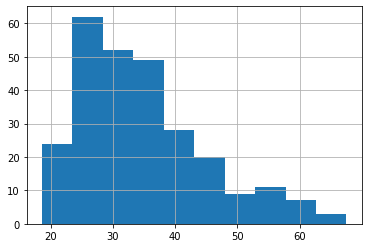

In [43]:
sem_eval_total_df[sem_eval_total_df.type == 'pos'].score.hist()

<AxesSubplot:>

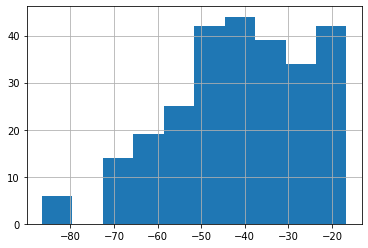

In [44]:
sem_eval_total_df[sem_eval_total_df.type == 'neg'].score.hist()

In [45]:
sem_eval_total_df['class'].value_counts(dropna=False)

SIMILAR            108
PART-WHOLE         100
ATTRIBUTE           97
REFERENCE           60
CONTRAST            57
CAS                 54
CLASS-INCLUSION     54
NaN                 24
Name: class, dtype: int64

In [46]:
print(f"Total samples: {len(sem_eval_total_df)}")

Total samples: 554


In [47]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from datetime import datetime

class SemEvalDS(Dataset):
    def __init__(self, dfX, dfY):
        self.source = np.array([list(a) + list(b) for a, b in zip(dfX.diffArr1.to_list(), dfX.diffArr2.to_list())]).astype(float)
        self.target = np.array(dfY.apply(lambda p: 1 if p == 'pos' else 0).to_list())
    def __len__(self):
        return len(self.source)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return {
            'input': torch.from_numpy(self.source[idx]).float(),
            'target': torch.from_numpy(np.array([self.target[idx]])).float()
        }

class NNet(nn.Module):
    def __init__(self, ip_size, hidden_size):
        super(NNet, self).__init__()
        self.linear1 = nn.Linear(ip_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
#         x = self.sigmoid(x)
        return x
    
def train_nnet(trainloader, valloader, epochs, learning_rate, device, weight_decay):
    """
        This function trains the LeNet model
    """
    net = NNet(200, 50).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 5, 0.5)
    
    # tensorboard writer
#     writer = SummaryWriter()
    
    try:
        train_accs, val_accs, train_losses, val_losses = [], [], [], []
        for epoch in range(epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            net.train(True)
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data['input'].to(device), data['target'].to(device)
    #             print(labels.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
    #             print(outputs.shape, labels.shape)
    #             print(labels)
    #             print(outputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            net.train(False)

            finalStr = f"Epoch: {epoch}"

            train_res_str, train_loss, train_acc = evaluate(net, trainloader, 'Train', device)
            finalStr += train_res_str

            val_res_str, val_loss, val_acc = evaluate(net, valloader, 'Val', device)
            finalStr += val_res_str

    #             writer.add_scalars("Loss", {'train': train_loss, 'val': val_loss}, epoch)
    #             writer.add_scalars("Accuracy", {'train': train_acc, 'val': val_acc}, epoch)

            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            if (epoch + 1) % 5 == 0:
                print(finalStr)
            scheduler.step()
    finally:
#         writer.close()
        print('Finished Training')
        today_date = datetime.now().strftime("%b_%d_%Y:%H_%M_%S")
        torch.save(net.state_dict(), '../data/analogical_proj/models/lenet.'+today_date+'.pt')
        print("Saved model to ",'../data/analogical_proj/models/lenet.'+today_date+'.pt')
        print()
#         print(evaluate(net, testloader, 'Test', device)[0])
        
        # plot the accuracy curves
        plt.figure(figsize=(10,10))
        plt.subplot(2,1,1)
        plot_curves(train_accs, val_accs, "", "Accuracy")
        
        # plot the loss curves
        plt.figure(figsize=(10,10))
        plt.subplot(2,1,2)
        plot_curves(train_losses, val_losses, "", "Loss")
        
    return net
    
def plot_curves(train_vals, val_vals, title, y_axis_label):
    """
        This function just plots the curves as per the training and validation values provided
    """
    plt.plot(list(range(len(train_vals))), train_vals, color='red', label='Training')
    plt.plot(list(range(len(val_vals))), val_vals, color='blue', label='Validation')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()
#     plt.savefig(filename)
    plt.close()

def evaluate(model, data_loader, data_type, device):
    """
        This function evaluates the model on the data_loader provided
    """
    model.eval()
    loss = 0
    correct = 0
    
    for batch in data_loader:
        data, target = batch['input'].to(device), batch['target'].to(device)
        
        output = model(data)
        loss += F.binary_cross_entropy_with_logits(output, target, size_average=False).data.item()
        pred = torch.round(torch.sigmoid(output))
#         print(pred.shape)
#         pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    
    acc = 100. * correct / (len(data_loader.dataset))
        
    return ' {} Loss: {:.4f}, Acc: {:.3f}%'.format(data_type, loss, acc), loss, acc

def generate_nnet_predictions_mcq_task(model, df, lines, device):
    model.eval()
    
    delta_emb = {}
    for _, row in df.iterrows():
        delta_emb[(row['node1_label'], row['node2_label'])] = np.array(row['diffArr1'])
        delta_emb[(row['other_node1_label'], row['other_node2_label'])] = np.array(row['diffArr1'])
    acc = 0
    for row in lines:
#         row = json.loads(row.strip())
        testrows = []
        stem_emb = delta_emb[(row['stem'][0], row['stem'][1])]
        for i in range(len(row['choice'])):
            cand = row['choice'][i]
            cand_emb = delta_emb[(cand[0], cand[1])]
            testrows.append((stem_emb.tolist(), cand_emb.tolist(), 'X'))
        dftest = pd.DataFrame(testrows, columns=['diffArr1', 'diffArr2', 'type'])
        sem_eval_test = SemEvalDS(dftest.drop(columns=['type']), dftest['type'])
        testloader = torch.utils.data.DataLoader(sem_eval_test,
                                batch_size=len(sem_eval_test))
        pred = []
        for batch in testloader:
            data, target = batch['input'].to(device), batch['target'].to(device)

            output = model(data)
            pred += torch.sigmoid(output).detach().cpu()
        
#         print(pred)
        if np.argmax(pred) == 0:
            acc += 1
            
    print(acc / len(lines))
    return acc / len(lines)

def generate_nnet_predictions_analogy_task(model, df, device):
    model.eval()
    
    delta_emb = {}
    for _, row in df.iterrows():
        dftest = pd.DataFrame([(np.array(row['diffArr1']).tolist(), np.array(row['diffArr1']).tolist(), 'X')], columns=['diffArr1', 'diffArr2', 'type'])
        sem_eval_test = SemEvalDS(dftest.drop(columns=['type']), dftest['type'])
        testloader = torch.utils.data.DataLoader(sem_eval_test,
                                batch_size=len(sem_eval_test))
        for batch in testloader:
            data, target = batch['input'].to(device), batch['target'].to(device)

            output = model(data)
            pred = torch.sigmoid(output).detach().cpu()[0]
        
            if pred == batch['target']:
                acc += 1
    
    print(acc / len(lines))
    return acc / len(lines)

def get_loaders(sem_eval_total_df1, bsize=128):
    X_train, X_test, y_train, y_test = train_test_split(sem_eval_total_df1.drop(columns=['type']), sem_eval_total_df1['type'], test_size=0.15, random_state=42, stratify=sem_eval_total_df1.type)
    sem_eval_train = SemEvalDS(X_train, y_train)
    sem_eval_test = SemEvalDS(X_test, y_test)
    assert len(sem_eval_train[0]['input']) == 200

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    trainloader = torch.utils.data.DataLoader(sem_eval_train,
                                batch_size=bsize, shuffle=True)
    testloader = torch.utils.data.DataLoader(sem_eval_test,
                                batch_size=len(sem_eval_test))
    return trainloader, testloader
    

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/nas/home/kshenoy/miniconda3/envs/kgtkEnv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 4 Train Loss: 0.2509, Acc: 91.702% Val Loss: 0.4681, Acc: 71.429%
Epoch: 9 Train Loss: 0.1153, Acc: 98.723% Val Loss: 0.3402, Acc: 82.143%
Epoch: 14 Train Loss: 0.0785, Acc: 99.149% Val Loss: 0.2872, Acc: 85.714%
Epoch: 19 Train Loss: 0.0667, Acc: 99.149% Val Loss: 0.2636, Acc: 85.714%
Finished Training
Saved model to  ../data/analogical_proj/models/lenet.Jan_10_2022:07_48_04.pt



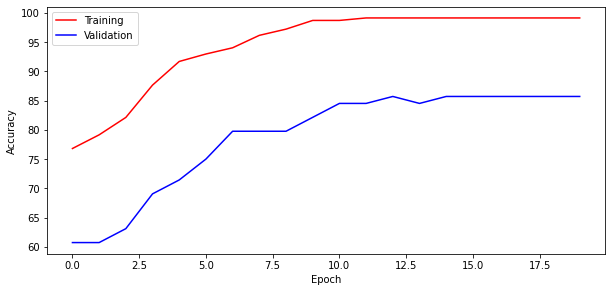

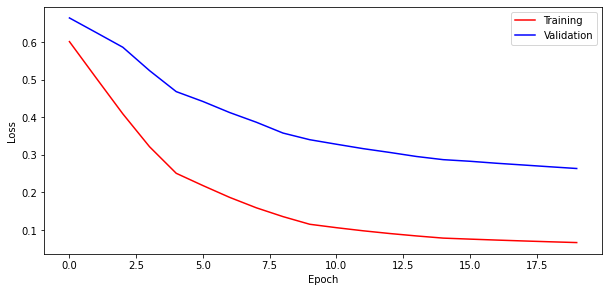

In [51]:
# Use complex embeddings for training
sem_eval_total_df = fetch_qnode_pair_embeddings(sem_eval_total_df, complex_emb_dict)
trainloader, testloader = get_loaders(sem_eval_total_df, bsize=128)
nnet_compl_og = train_nnet(trainloader, testloader, 20, 0.01, device, 1e-3)

In [52]:
def generate_all_permutations(sem_eval_total_df):
    def sampling_permutation(a, b, c, d):
        positive = [(a, b, c, d), (a, c, b, d),
                    (b, a, d, c), (b, d, a, c),
                    (c, d, a, b), (c, a, d, b),
                    (d, c, b, a), (d, b, c, a)]
        negative = [(a, b, d, c), (a, c, d, b), (a, d, b, c), (a, d, c, b),
                    (b, a, c, d), (b, c, a, d), (b, c, d, a), (b, d, c, a),
                    (c, a, b, d), (c, b, a, d), (c, b, d, a), (c, d, b, a),
                    (d, a, b, c), (d, a, c, b), (d, b, a, c), (d, c, a, b)]

        return positive, negative
    new_rows = []
    for _, row in sem_eval_total_df.iterrows():
        positive, negative = sampling_permutation(row['node1'], row['node2'], row['other_node1'], row['other_node2'])
        for pos in positive:
            new_rows.append(list(pos) + [row['type']])
        for neg in negative:
            new_rows.append(list(neg) + ['neg'])
    return pd.DataFrame(new_rows, columns=['node1', 'node2', 'other_node1', 'other_node2', 'type'])

In [53]:
sem_eval_total_df_permuted = generate_all_permutations(sem_eval_total_df)
sem_eval_total_df_permuted.type.value_counts()

neg    10984
pos     2312
Name: type, dtype: int64

/nas/home/kshenoy/miniconda3/envs/kgtkEnv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 4 Train Loss: 0.2813, Acc: 85.143% Val Loss: 0.3176, Acc: 83.910%
Epoch: 9 Train Loss: 0.1758, Acc: 93.293% Val Loss: 0.2206, Acc: 89.524%
Epoch: 14 Train Loss: 0.1456, Acc: 94.505% Val Loss: 0.1927, Acc: 90.326%
Epoch: 19 Train Loss: 0.1334, Acc: 95.222% Val Loss: 0.1852, Acc: 91.028%
Finished Training
Saved model to  ../data/analogical_proj/models/lenet.Jan_10_2022:07_49_44.pt



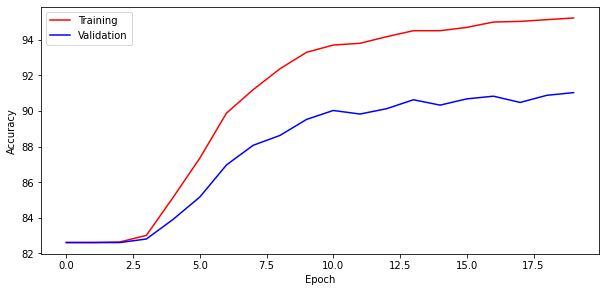

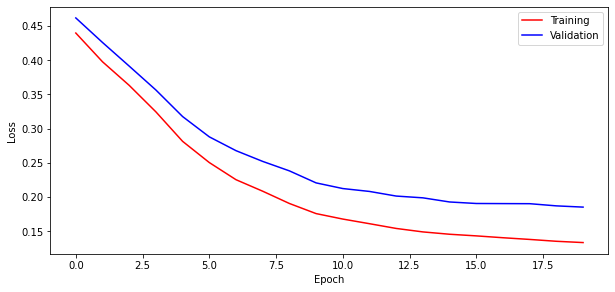

In [54]:
sem_eval_total_df_permuted = fetch_qnode_pair_embeddings(sem_eval_total_df_permuted, complex_emb_dict)
trainloader, testloader = get_loaders(sem_eval_total_df_permuted, bsize=1024)
nnet_complex_permutation = train_nnet(trainloader, testloader, 20, 0.01, device, 1e-3)

/nas/home/kshenoy/miniconda3/envs/kgtkEnv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 4 Train Loss: 0.2989, Acc: 84.497% Val Loss: 0.3371, Acc: 82.807%
Epoch: 9 Train Loss: 0.1909, Acc: 92.408% Val Loss: 0.2337, Acc: 89.524%
Epoch: 14 Train Loss: 0.1553, Acc: 94.204% Val Loss: 0.2013, Acc: 90.376%
Epoch: 19 Train Loss: 0.1427, Acc: 94.894% Val Loss: 0.1914, Acc: 90.777%
Epoch: 24 Train Loss: 0.1361, Acc: 95.169% Val Loss: 0.1857, Acc: 90.627%
Epoch: 29 Train Loss: 0.1336, Acc: 95.319% Val Loss: 0.1845, Acc: 90.727%
Epoch: 34 Train Loss: 0.1322, Acc: 95.425% Val Loss: 0.1839, Acc: 90.677%
Epoch: 39 Train Loss: 0.1314, Acc: 95.469% Val Loss: 0.1828, Acc: 90.727%
Finished Training
Saved model to  ../data/analogical_proj/models/lenet.Jan_10_2022:07_51_16.pt



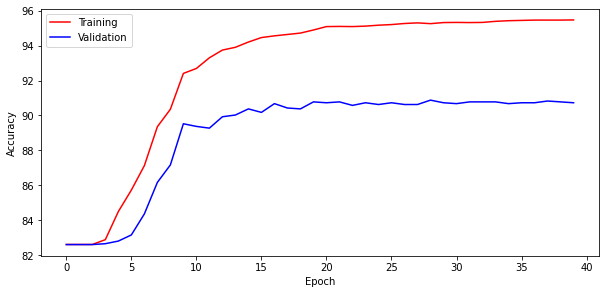

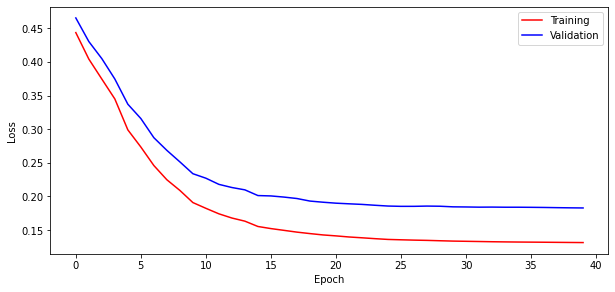

In [55]:
nnet_complex_permutation_2 = train_nnet(trainloader, testloader, 40, 0.01, device, 1e-3)

# Sem Eval 2012 Dataset Experiments

## Ph1-Te Complex, GLOVE, W2VEC, RoBERTA embeddings evaluation

In this set of experiments, we use complex, Glove, W2Vec, RoBERTA embeddings and use it on Ph1-Te to perform following  analysis:
* cosSim values distribution
* Visualize 2D, 3D t-SNE for the embeddings colored based on the relation to see if they are distinguishable
* Training and validation accuracies to predict the relation and the resulting confusion matrix for the same

In [56]:
def join_with_word_emb(sem_eval_df_wo_cosSim, word_emb_dict):
    sem_eval_df_og1 = sem_eval_df_wo_cosSim.copy()
    return sem_eval_df_og1.join(get_results(sem_eval_df_og1, word_emb_dict))

def join_with_bert_emb(sem_eval_df_wo_cosSim):
    # Fetch structure index 1: 
    # Pair 1 Embedding: node1_label node1_desc is related to node2_label node2_desc
    # Pair 2 Embedding: Same as above
    sem_eval_cosSimed_bert = get_bert_based_cosSim(sem_eval_df_wo_cosSim, 'sentence-transformers/all-distilroberta-v1', 1)
    sem_eval_cosSimed_bert['diffArr1'] = sem_eval_cosSimed_bert['pair1_emb']
    sem_eval_cosSimed_bert['diffArr2'] = sem_eval_cosSimed_bert['pair2_emb']
    return sem_eval_cosSimed_bert

def join_with_bert_word_style_emb(sem_eval_df):
    def getSentEmbeddings(valSeries, modelName):
        model = SentenceTransformer(modelName)
        start = time()
        encodings = model.encode(valSeries, show_progress_bar=True, batch_size=500)
        return encodings
    modelName = 'sentence-transformers/all-distilroberta-v1'
    sem_eval_df['diffArr1'] = pd.Series(list(getSentEmbeddings(sem_eval_df.apply(lambda p:p.node1_label + ' ' + p.node2_label, axis=1), modelName)))
    sem_eval_df['diffArr2'] = pd.Series(list(getSentEmbeddings(sem_eval_df.apply(lambda p:p.other_node1_label + ' ' + p.other_node2_label, axis=1), modelName)))
    sem_eval_df['cosSim'] = sem_eval_df.apply(lambda p: cosine_similarity(p.diffArr1.reshape(1, -1), p.diffArr1.reshape(1, -1))[0][0], axis=1)
    idx = sem_eval_df.groupby(by=['node1', 'node2'])['cosSim'].transform(max) == sem_eval_df['cosSim']
    sem_eval_df1 = sem_eval_df[idx]
    assert len(sem_eval_df1) == len(sem_eval_df)
    return sem_eval_df

Complex Embedding Visualizations on Ph1-Tr
Size of dataset reduced from 30 to 24
Extracted 30 embeddings
[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.000s...
[t-SNE] Computed neighbors for 30 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.536995
[t-SNE] KL divergence after 1000 iterations: 0.818812


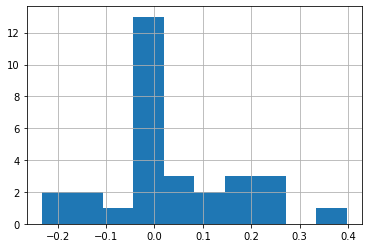

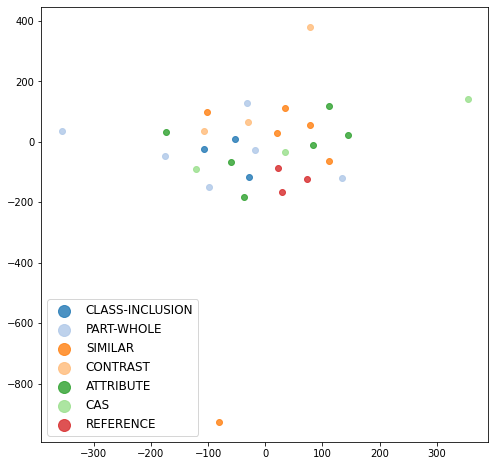

[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.001s...
[t-SNE] Computed neighbors for 30 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.321182
[t-SNE] KL divergence after 1000 iterations: 0.719101


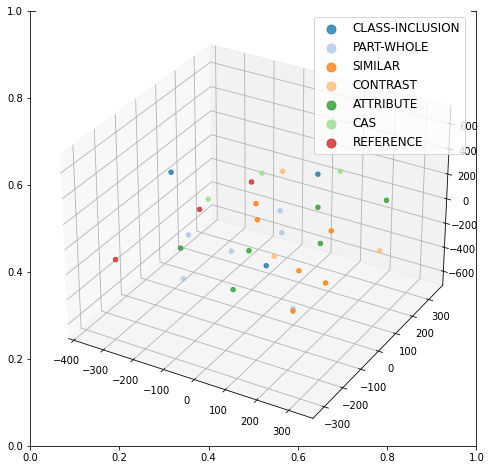

ValueError: n_splits=10 cannot be greater than the number of members in each class.

In [57]:
print("Complex Embedding Visualizations on Ph1-Tr")
sem_eval_training_df1, sem_eval_training_df_og1, ph1_tr_complex_train, ph1_tr_complex_val = analyze_df_w_embeddings(sem_eval_training_df, 'sem_eval.training.complex')


Complex Embedding Visualizations on Ph1-Te
Size of dataset reduced from 234 to 205
Extracted 215 embeddings
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 215 samples in 0.016s...
[t-SNE] Computed neighbors for 215 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 215 / 215
[t-SNE] Mean sigma: 1.710008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 135.889008
[t-SNE] KL divergence after 1000 iterations: 1.584649


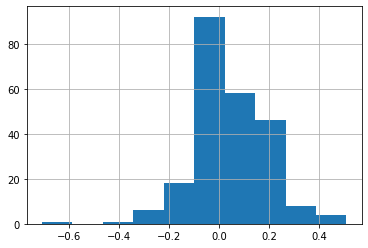

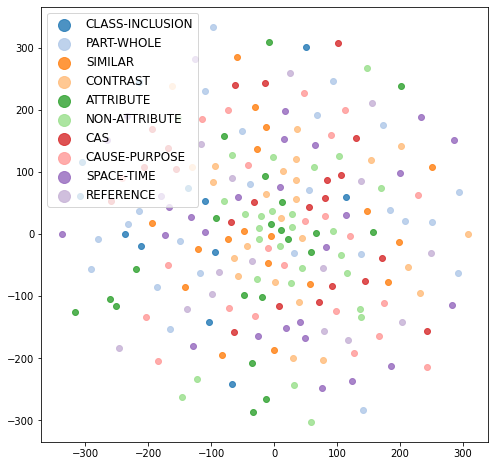

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 215 samples in 0.001s...
[t-SNE] Computed neighbors for 215 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 215 / 215
[t-SNE] Mean sigma: 1.710008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 208.843414
[t-SNE] KL divergence after 1000 iterations: 3.784409


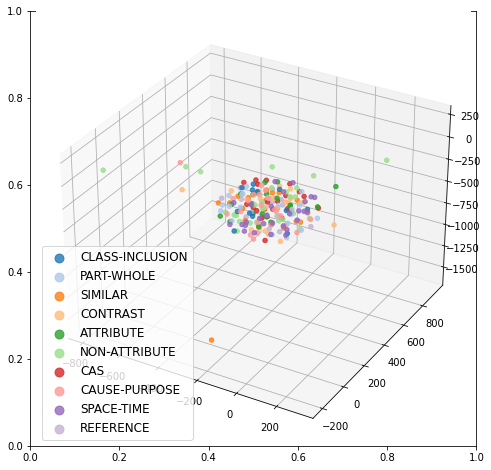

Train, Val accuracies for relation [0.9907843713278496], [0.61]
Extracted 215 embeddings
Saved emb file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.complex.emb.Jan_10_2022.tsv
Saved labels file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.complex.lab.Jan_10_2022.tsv


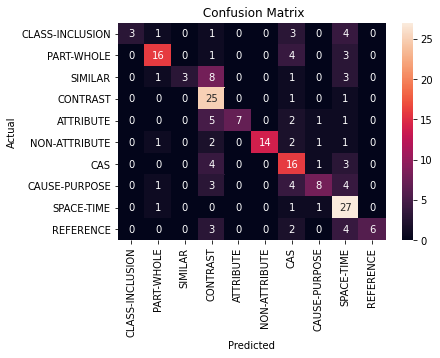

In [58]:
print("Complex Embedding Visualizations on Ph1-Te")
sem_eval_testing_df1, sem_eval_testing_df_og1, ph1_te_complex_train, ph1_te_complex_val = analyze_df_w_embeddings(sem_eval_testing_df, 'sem_eval.testing.complex')


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Size of dataset reduced from 205 to 205
Extracted 200 embeddings
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.002s...
[t-SNE] Computed neighbors for 200 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.027101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 121.900787
[t-SNE] KL divergence after 1000 iterations: 1.550116


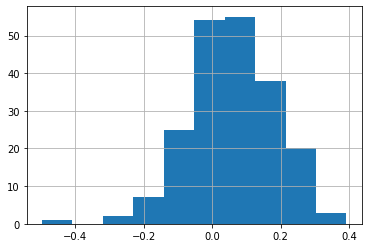

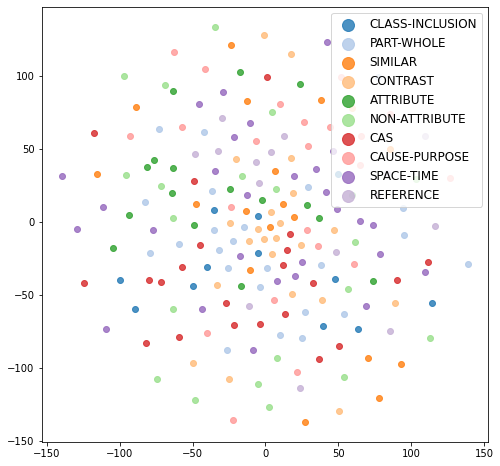

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 3.027101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 204.192841
[t-SNE] KL divergence after 1000 iterations: 3.607072


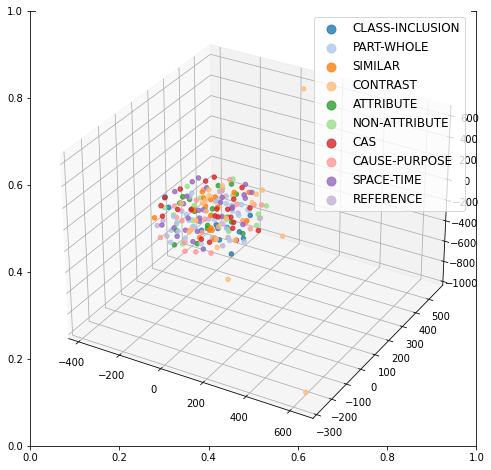

Train, Val accuracies for relation [1.0], [0.7173809523809525]
Extracted 200 embeddings
Saved emb file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.glove.emb.Jan_10_2022.tsv
Saved labels file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.glove.lab.Jan_10_2022.tsv


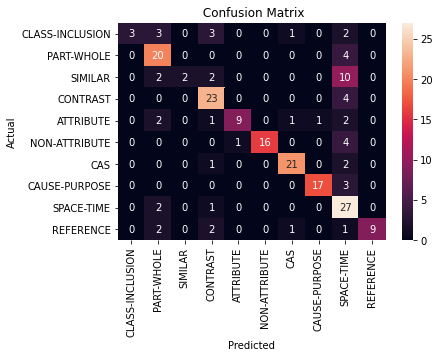

In [62]:
# GLOVE Embeddings on Ph1-Te
w_emb_model = model_glove
sem_eval_test_glove, _, ph1_te_glove_train, ph1_te_glove_val = analyze_df_w_embeddings(join_with_word_emb(sem_eval_testing_df_og1, w_emb_model), 'sem_eval.testing.glove')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Size of dataset reduced from 205 to 205
Extracted 200 embeddings
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.549350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 128.975784
[t-SNE] KL divergence after 1000 iterations: 1.666100


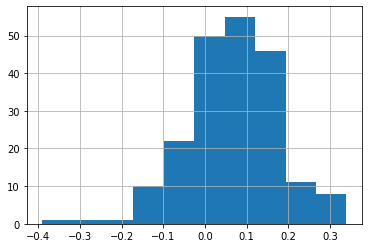

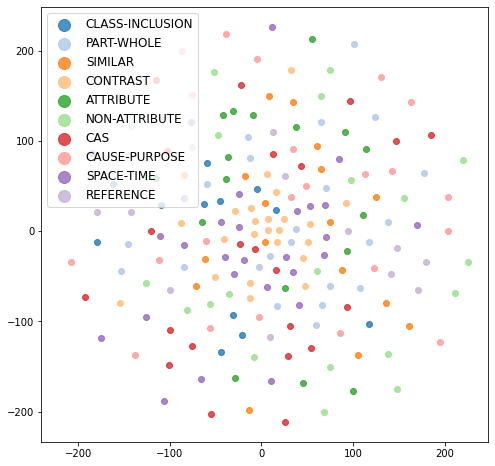

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.549350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 201.576294
[t-SNE] KL divergence after 1000 iterations: 3.481570


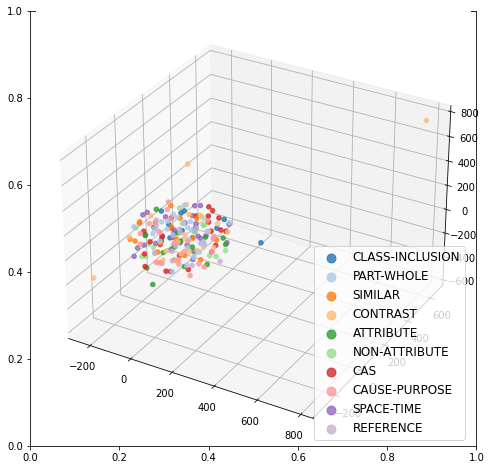

Train, Val accuracies for relation [1.0], [0.7761904761904761]
Extracted 200 embeddings
Saved emb file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.w2vec.emb.Jan_10_2022.tsv
Saved labels file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.w2vec.lab.Jan_10_2022.tsv


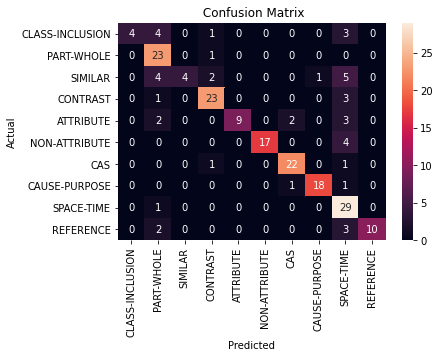

In [63]:
# W2Vec Embeddings on Ph1-Te
w_emb_model = model_w2v
sem_eval_test_w2vec, _, ph1_te_w2vec_train, ph1_te_w2vec_val = analyze_df_w_embeddings(join_with_word_emb(sem_eval_testing_df_og1, w_emb_model), 'sem_eval.testing.w2vec')

0it [00:00, ?it/s]

Exception when trying to download https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip not found. Try to create it from scratch
Try to create Transformer Model sentence-transformers/all-distilroberta-v1 with mean pooling
Exception when trying to download https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip not found. Try to create it from scratch
Try to create Transformer Model sentence-transformers/all-distilroberta-v1 with mean pooling


Size of dataset reduced from 205 to 205
Extracted 200 embeddings
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.013s...
[t-SNE] Computed neighbors for 200 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.973984
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.950516
[t-SNE] KL divergence after 1000 iterations: 0.913909


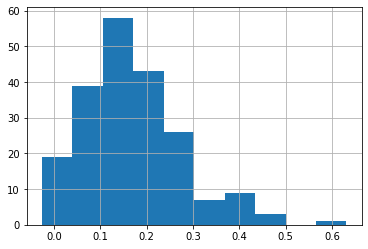

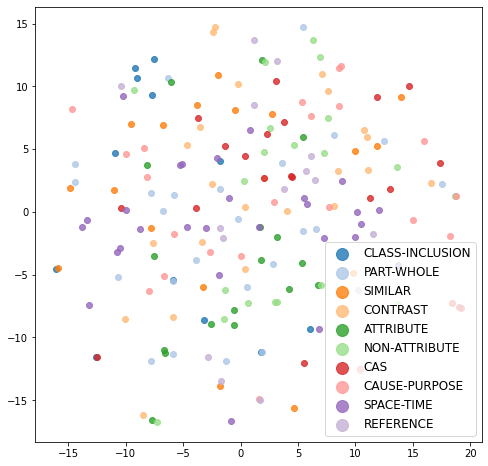

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.002s...
[t-SNE] Computed neighbors for 200 samples in 0.102s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.973984
[t-SNE] KL divergence after 250 iterations with early exaggeration: 153.338089
[t-SNE] KL divergence after 1000 iterations: 2.176382


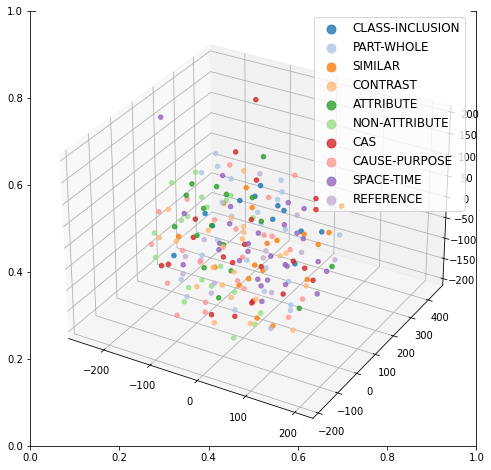

Train, Val accuracies for relation [1.0], [0.7464285714285713]
Extracted 200 embeddings
Saved emb file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.bert.emb.Jan_10_2022.tsv
Saved labels file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.bert.lab.Jan_10_2022.tsv


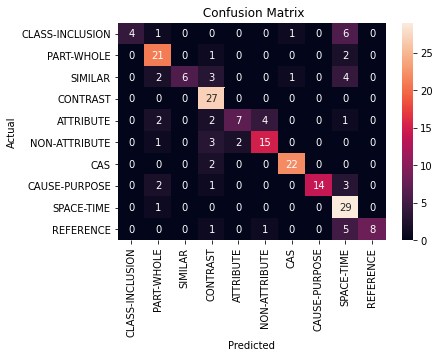

In [66]:
# BERT Embeddings: node1_label node1_desc is related to node2_label node2_desc
sem_eval_test_bert_1, _, ph1_te_bert_1_train, ph1_te_bert_1_val = analyze_df_w_embeddings(join_with_bert_emb(sem_eval_testing_df_og1), 'sem_eval.testing.bert')

Exception when trying to download https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip not found. Try to create it from scratch
Try to create Transformer Model sentence-transformers/all-distilroberta-v1 with mean pooling


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Exception when trying to download https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/sentence-transformers/all-distilroberta-v1.zip not found. Try to create it from scratch
Try to create Transformer Model sentence-transformers/all-distilroberta-v1 with mean pooling


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Size of dataset reduced from 205 to 205
Extracted 200 embeddings
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 4.069294
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.897087
[t-SNE] KL divergence after 1000 iterations: 1.022866


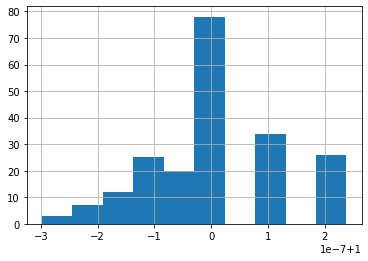

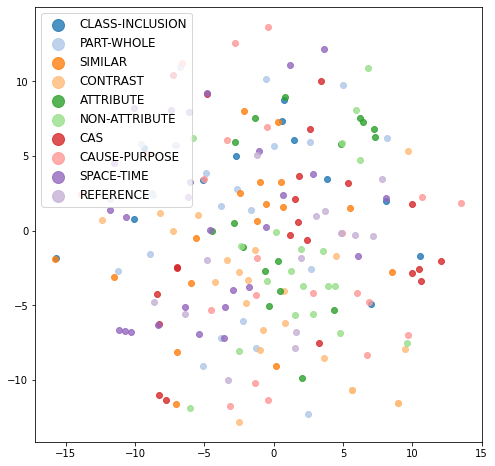

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 4.069294
[t-SNE] KL divergence after 250 iterations with early exaggeration: 161.312653
[t-SNE] KL divergence after 1000 iterations: 2.473603


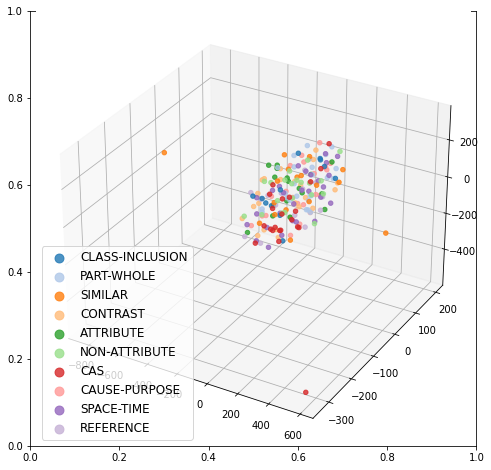

Train, Val accuracies for relation [1.0], [0.7361904761904762]
Extracted 200 embeddings
Saved emb file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.bert_2.emb.Jan_10_2022.tsv
Saved labels file: ../data/analogical_proj/emb_files_for_google_projections/sem_eval.testing.bert_2.lab.Jan_10_2022.tsv


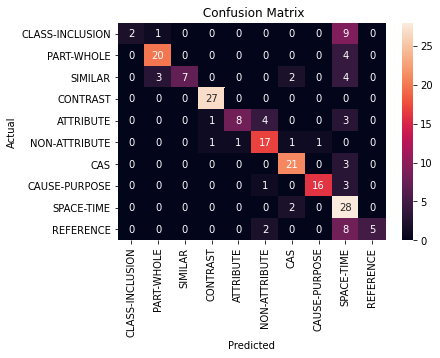

In [67]:
# BERT Embeddings: node1_label node2_label
sem_eval_test_bert_2, _, ph1_te_bert_2_train, ph1_te_bert_2_val = analyze_df_w_embeddings(join_with_bert_word_style_emb(sem_eval_testing_df_og1), 'sem_eval.testing.bert_2')

In [68]:
print("Accuracies on analogy task on Ph1-Te dataset (205 quadruples)")
res = [('Complex', ph1_te_complex_train[0], ph1_te_complex_val[0]),
      ('GLOVE', ph1_te_glove_train[0], ph1_te_glove_val[0]),
      ('W2VEC', ph1_te_w2vec_train[0], ph1_te_w2vec_val[0]),
      ('BERT v1 (197 quadruples)', ph1_te_bert_1_train[0], ph1_te_bert_1_val[0]),
      ('BERT v2', ph1_te_bert_2_train[0], ph1_te_bert_2_val[0]),]
pd.DataFrame(res, columns=['Algo', '10-fold SVC train acc', '10-fold SVC test acc'])

Accuracies on analogy task on Ph1-Te dataset (205 quadruples)


Algo  10-fold SVC train acc  10-fold SVC test acc
0                   Complex               0.990784              0.610000
1                     GLOVE               1.000000              0.717381
2                     W2VEC               1.000000              0.776190
3  BERT v1 (197 quadruples)               1.000000              0.746429
4                   BERT v2               1.000000              0.736190

## MCQ Complex, GLOVE, W2VEC, RoBERTA, NNet evaluation

In this set of experiments, we use all embeddings as well as the neural net predictions to evaluate how they fare on the MCQ task (whether they can predict the correct analogy).

In [69]:
def eval_alm_acc(sem_eval_df1, lines):
    delta_emb = {}
    for _, row in sem_eval_df1.iterrows():
        delta_emb[(row['node1_label'], row['node2_label'])] = np.array(row['diffArr1'])
        delta_emb[(row['other_node1_label'], row['other_node2_label'])] = np.array(row['diffArr1'])
    acc = 0
    for row in lines:
#         row = json.loads(row.strip())
        stem_emb = delta_emb[(row['stem'][0], row['stem'][1])]
        cos_sims = {}
        target = delta_emb[row['choice'][0][0], row['choice'][0][1]]
        target_cos_sim = cosine_similarity(stem_emb.reshape(1, -1), target.reshape(1, -1))[0][0]
        for i in range(1,len(row['choice'])):
            cand = row['choice'][i]
            cand_emb = delta_emb[(cand[0], cand[1])]
            cos_sim = cosine_similarity(stem_emb.reshape(1, -1), cand_emb.reshape(1, -1))[0][0]
            cos_sims[tuple(cand)] = cos_sim
        max_cos_sim = max(cos_sims.values())
        if target_cos_sim >= max_cos_sim:
            acc += 1
    print(acc / len(lines))
    return acc / len(lines)

In [70]:
complex_acc = eval_alm_acc(sem_eval_testing_df1, sem_eval_mcq_test_set)
glove_acc = eval_alm_acc(sem_eval_test_glove, sem_eval_mcq_test_set)
w2vec_acc = eval_alm_acc(sem_eval_test_w2vec, sem_eval_mcq_test_set)
bert_1_acc = eval_alm_acc(sem_eval_test_bert_1, sem_eval_mcq_test_set)
bert_2_acc = eval_alm_acc(sem_eval_test_bert_2, sem_eval_mcq_test_set)

0.5121951219512195
0.5853658536585366
0.6585365853658537
0.6634146341463415
0.6195121951219512


In [71]:
# NNet executions on MCQ dataset
nnet_compl_og_acc = generate_nnet_predictions_mcq_task(nnet_compl_og, sem_eval_testing_df1, sem_eval_mcq_test_set, device)
nnet_complex_permutation_acc = generate_nnet_predictions_mcq_task(nnet_complex_permutation, sem_eval_testing_df1, sem_eval_mcq_test_set, device)
nnet_complex_permutation_2_acc = generate_nnet_predictions_mcq_task(nnet_complex_permutation_2, sem_eval_testing_df1, sem_eval_mcq_test_set, device)

0.28292682926829266
0.4585365853658537
0.47317073170731705


In [72]:
print("Accuracies on MCQ task on MCQ dataset")
res = [('Complex', complex_acc),
      ('GLOVE', glove_acc),
      ('W2VEC', w2vec_acc),
      ('BERT v1 (197 quadruples)', bert_1_acc),
      ('BERT v2', bert_2_acc),
      ('NNet Complex OG', nnet_compl_og_acc),
      ('NNet Complex Permutation 20 epochs', nnet_complex_permutation_acc),
      ('NNet Complex Permutation 40 epochs', nnet_complex_permutation_2_acc),]
pd.DataFrame(res, columns=['Algo', 'Accuracy'])

Accuracies on MCQ task on MCQ dataset


Algo  Accuracy
0                             Complex  0.512195
1                               GLOVE  0.585366
2                               W2VEC  0.658537
3            BERT v1 (197 quadruples)  0.663415
4                             BERT v2  0.619512
5                     NNet Complex OG  0.282927
6  NNet Complex Permutation 20 epochs  0.458537
7  NNet Complex Permutation 40 epochs  0.473171

## Scores Dataset Complex, GLOVE, W2VEC evaluation

In this set of experiments, we use scores dataset and evaluate Glove, W2vec cosSim scores. We use 2 aspects for this:
* Correlation between the turker scores and the cosSim scores
* Group the rows as per the answer pairs such that their cosSim scores with multiple Q pairs gets averaged and then determine the correlation between the turker scores and the averaged cosSim scores

In [130]:
def determine_correlations_with_turker_scores(sem_eval_df_turked_glove):
    sem_eval_df_turked_glove['score'] = sem_eval_df_turked_glove.score / 100
    corr1 = stats.spearmanr(sem_eval_df_turked_glove['score'], sem_eval_df_turked_glove['cosSim']).correlation
    sem_eval_df_turked_glove_grouped = sem_eval_df_turked_glove.groupby(['file_id', 'other_node1_label', 'other_node2_label', 'score']).mean()
    sem_eval_df_turked_glove_grouped = sem_eval_df_turked_glove_grouped.reset_index()
    corr2 = stats.spearmanr(sem_eval_df_turked_glove_grouped['score'], sem_eval_df_turked_glove_grouped['cosSim']).correlation
    return corr1, corr2

In [137]:
# Complex
compl_corr1, compl_corr2 = determine_correlations_with_turker_scores(sem_eval_training_scores_df)

In [138]:
# W2Vec
w_emb_model = model_w2v
w2v_corr1, w2v_corr2 = determine_correlations_with_turker_scores(join_with_word_emb(sem_eval_training_scores_df.drop(columns=['diffArr1', 'diffArr2', 'cosSim']), w_emb_model))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [139]:
# Glove
w_emb_model = model_glove
glove_corr1, glove_corr2 = determine_correlations_with_turker_scores(join_with_word_emb(sem_eval_training_scores_df.drop(columns=['diffArr1', 'diffArr2', 'cosSim']), w_emb_model))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [140]:
res = [('Complex', compl_corr1, compl_corr2),
      ('W2Vec', w2v_corr1, w2v_corr2),
      ('Glove', glove_corr1, glove_corr2)]
pd.DataFrame(res, columns=['Embedding', 'Corr 1', 'Corr 2'])

Embedding    Corr 1    Corr 2
0   Complex  0.097457  0.171300
1     W2Vec  0.159471  0.222290
2     Glove  0.126575  0.175172